In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import font_manager
import seaborn as sns
from scipy import stats, optimize, integrate
from copy import copy
import pandas as pd
import datetime
from statsmodels.graphics.gofplots import qqplot

In [2]:
%matplotlib inline

label_font = font_manager.FontProperties(
    family=['Fira Sans'],
    weight='regular',
    size=20
)
tick_font = font_manager.FontProperties(
    family=['Fira Sans'],
    weight='regular',
    size=14
)
pub_font = font_manager.FontProperties(
#     family=['cmr10'],
    weight='regular',
    size=32
)
publish = False
if publish:
    matplotlib.rcParams.update(
        {
            'text.usetex': True,
            'font.family': 'cmr10',
            'mathtext.fontset': 'cm',
        }
    )

In [3]:
def seir(t, y, p):
    b, g, e, d, a, m = p[:6]
    S,E,I,H,G,R,D,cE,cH = y[:9]
    return [
        -b*S*I/(S+E+I+R+G+H),
        b*S*I/(S+E+I+R+G+H)-g*E,
        g*E-(e+a+m)*I,
        e*I-d*H,
        d*H,
        e*I,
        m*I,
        g*E,
        e*I
    ]

In [4]:
read_file = True
if read_file:
    raw_data = pd.read_csv("../samoa/samoa-data/samoa_press_release_data.csv", 
                           header=0, dayfirst=True, parse_dates=True, skiprows=[1])

In [5]:
the_dates = list(map(lambda t: datetime.datetime.strptime(t, "%d/%m/%Y"), raw_data.Date.values))
def time_conv(time: float):
    return the_dates[0] + datetime.timedelta(days=time)

In [6]:
date_tick = [datetime.date(2019, M, 1) for M in [10, 11, 12]] + [datetime.date(2020, 1, 1)]
date_tick_label = ['Oct\n2019', 'Nov', 'Dec', 'Jan\n2020']

ex_date_tick = date_tick + [datetime.date(2020,2,1)]
ex_date_label = date_tick_label + ['Feb']

In [7]:
time, cE, H, cH, D, G = raw_data.iloc[:,1:].values.T

In [8]:
data_pd = np.vstack([H, G, D, cE, cH]).astype(float).T
start = 0
clip = 17
data_time = time[start:clip]
data_pd = data_pd[start:clip,:]

p0 = [2, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6]
config = {
    "grid_size": 200,
    "basis_number": 40,
    "model_form": {
        "state": 9,
        "parameters": 6
    },
    "time_span": [time[0], time[-1]*1.25],
#     "time_span": [time[0], 150],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(data_time)},
    "observation_vector": [3,4,6,7,8],
    "weightings":[
        [1]*9,
        np.sqrt((data_time+1)/np.mean(data_time+1))
    ],
    "regularisation_value": copy(p0),
}

In [9]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
config['regularisation_value'][2] = model.ps[2]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 50,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [10]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
fr_ex = ca.Function('fr_ex', [solver_setup['x']], [objective.regularisation])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)

In [11]:
c0 = [2500*np.ones(config['basis_number']) for _ in range(9)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*9) + [0]*len(config['regularisation_value'])
alpha = 3e1

In [12]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange[:51]:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0


1500  3.8180856e+01 0.00e+00 5.49e-05  -9.0 1.74e+02    -  1.00e+00 1.00e+00h  1
1550  3.8180856e+01 0.00e+00 1.27e-03  -9.0 1.34e+04    -  1.00e+00 6.25e-02h  5
1600  3.8180856e+01 0.00e+00 2.50e-04  -9.0 3.96e+02    -  1.00e+00 1.00e+00h  1
1650  3.8180856e+01 0.00e+00 2.93e-03  -9.0 1.11e+04    -  1.00e+00 1.25e-01h  4
1700  3.8180856e+01 0.00e+00 3.52e-04  -9.0 5.07e+02    -  1.00e+00 1.00e+00h  1
1750  3.8180856e+01 0.00e+00 1.21e-04  -9.0 3.12e+02    -  1.00e+00 1.00e+00h  1
1800  3.8180856e+01 0.00e+00 2.16e-03  -9.0 5.29e+03    -  1.00e+00 2.50e-01h  3
1850  3.8180855e+01 0.00e+00 1.78e-03  -9.0 2.01e+04    -  1.00e+00 6.25e-02h  5
1900  3.8180855e+01 0.00e+00 7.60e-06  -9.0 9.69e+01    -  1.00e+00 1.00e+00h  1
1950  3.8180855e+01 0.00e+00 1.33e-03  -9.0 1.17e+03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  3.8180855e+01 0.00e+00 1.65e-03  -9.0 5.20e+03    -  1.00e+00 2.50e-01h  3
2050  3.8180855e+01 0.00e+00

  50  3.9326229e+01 0.00e+00 1.53e+01  -2.5 9.86e+01  -6.0 1.00e+00 1.00e+00f  1
 100  3.8734022e+01 0.00e+00 4.60e-01  -5.7 2.94e+03 -13.2 1.00e+00 1.00e+00f  1
 150  3.8386674e+01 0.00e+00 2.97e-01  -5.7 1.76e+03    -  1.00e+00 1.00e+00f  1
 200  3.8346520e+01 0.00e+00 7.10e-02  -5.7 1.32e+01    -  1.00e+00 1.00e+00f  1
 250  3.8343282e+01 0.00e+00 2.95e-02  -5.7 5.38e+00    -  1.00e+00 1.00e+00h  1
 300  3.8342407e+01 0.00e+00 3.24e-02  -5.7 2.04e+02    -  1.00e+00 3.12e-02h  6
 350  3.8342118e+01 0.00e+00 8.80e-04  -5.7 1.92e+00    -  1.00e+00 1.00e+00h  1
 400  3.8341579e+01 0.00e+00 1.71e-01  -8.6 4.45e+01    -  1.00e+00 1.00e+00h  1
 450  3.8341800e+01 0.00e+00 8.33e-01  -8.6 3.36e+02    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.8341432e+01 0.00e+00 2.60e-02  -8.6 7.22e+02    -  1.00e+00 6.25e-02h  5
 550  3.8341408e+01 0.00e+00 3.08e-02  -8.6 2.70e+02    -  1.00e+00 2.50e-01h  3
 600  3.8341391e+01 0.00e+00

 550  3.8445600e+01 0.00e+00 2.00e-02  -8.6 2.39e+01    -  1.00e+00 1.00e+00h  1
 600  3.8445551e+01 0.00e+00 5.11e-02  -8.6 1.11e+02    -  1.00e+00 5.00e-01h  2
 650  3.8445523e+01 0.00e+00 5.00e-03  -8.6 2.51e+01    -  1.00e+00 1.00e+00h  1
 700  3.8445504e+01 0.00e+00 3.17e-02  -8.6 1.63e+02    -  1.00e+00 5.00e-01h  2
 750  3.8445491e+01 0.00e+00 2.36e-03  -8.6 3.08e+01    -  1.00e+00 1.00e+00h  1
 800  3.8445491e+01 0.00e+00 1.49e-01  -8.6 6.11e+02    -  1.00e+00 5.00e-01h  2
 850  3.8445476e+01 0.00e+00 1.55e-03  -8.6 4.05e+01    -  1.00e+00 1.00e+00h  1
 900  3.8445471e+01 0.00e+00 5.08e-03  -8.6 2.82e+03    -  1.00e+00 3.12e-02h  6
 950  3.8445467e+01 0.00e+00 4.18e-04  -8.6 3.24e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.8445464e+01 0.00e+00 2.38e-03  -8.6 9.06e+01    -  1.00e+00 1.00e+00h  1
1050  3.8445462e+01 0.00e+00 2.64e-03  -8.6 1.14e+02    -  1.00e+00 1.00e+00h  1
1100  3.8445459e+01 0.00e+00

 850  3.8567612e+01 0.00e+00 2.75e-02  -8.6 1.15e+04    -  1.00e+00 7.81e-03h  8
In iteration 871, 1 Slack too small, adjusting variable bound
 900  3.8567592e+01 0.00e+00 3.36e-02  -9.0 7.69e+02    -  1.00e+00 5.00e-01h  2
 950  3.8567589e+01 0.00e+00 3.53e-03  -9.0 1.51e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.8567588e+01 0.00e+00 4.62e-02  -9.0 1.95e+04    -  1.00e+00 1.56e-02h  7
In iteration 1036, 1 Slack too small, adjusting variable bound
In iteration 1040, 1 Slack too small, adjusting variable bound
1050  3.8567585e+01 0.00e+00 3.88e-03  -9.0 2.86e+02    -  1.00e+00 1.00e+00h  1
1100  3.8567584e+01 0.00e+00 4.24e-02  -9.0 1.79e+04    -  1.00e+00 1.56e-02h  7
1150  3.8567583e+01 0.00e+00 5.53e-03  -9.0 1.73e+03    -  1.00e+00 2.50e-01h  3
1200  3.8567583e+01 0.00e+00 5.12e-04  -9.0 1.53e+02    -  1.00e+00 1.00e+00h  1
1250  3.8567582e+01 0.00e+00 1.48e-02  -9.0 1.82e+03    -  1.00e+00 5.00e-01h  2
13

 750  3.8867825e+01 0.00e+00 5.59e-02  -8.6 3.31e+02    -  1.00e+00 1.25e-01h  4
 800  3.8867793e+01 0.00e+00 6.70e-02  -8.6 1.17e+02    -  1.00e+00 5.00e-01h  2
 850  3.8867768e+01 0.00e+00 1.80e-03  -8.6 1.33e+01    -  1.00e+00 1.00e+00h  1
 900  3.8867750e+01 0.00e+00 3.64e-03  -8.6 2.37e+01    -  1.00e+00 1.00e+00h  1
 950  3.8867738e+01 0.00e+00 8.58e-03  -8.6 4.48e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.8867729e+01 0.00e+00 2.42e-03  -8.6 2.93e+01    -  1.00e+00 1.00e+00h  1
1050  3.8867722e+01 0.00e+00 2.12e-02  -8.6 1.03e+02    -  1.00e+00 1.00e+00h  1
1100  3.8867716e+01 0.00e+00 6.37e-03  -8.6 6.74e+01    -  1.00e+00 1.00e+00h  1
1150  3.8867712e+01 0.00e+00 1.90e-02  -8.6 5.26e+02    -  1.00e+00 2.50e-01h  3
1200  3.8867708e+01 0.00e+00 1.67e-02  -8.6 1.51e+02    -  1.00e+00 1.00e+00h  1
1250  3.8867705e+01 0.00e+00 2.26e-04  -8.6 2.15e+01    -  1.00e+00 1.00e+00h  1
1300  3.8867702e+01 0.00e+00

2450  3.9046228e+01 0.00e+00 2.20e-02  -8.6 2.42e+03    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  3.9046228e+01 0.00e+00 1.72e-02  -8.6 2.63e+03    -  1.00e+00 2.50e-01h  3
2550  3.9046228e+01 0.00e+00 5.95e-03  -8.6 6.73e+02    -  1.00e+00 1.00e+00h  1
2600  3.9046228e+01 0.00e+00 4.34e-04  -8.6 1.89e+02    -  1.00e+00 1.00e+00h  1
2650  3.9046228e+01 0.00e+00 1.34e-02  -8.6 1.07e+03    -  1.00e+00 1.00e+00H  1
2700  3.9046228e+01 0.00e+00 1.54e-01  -8.6 1.82e+04    -  1.00e+00 3.12e-02h  6
2750  3.9046228e+01 0.00e+00 2.73e-04  -8.6 1.63e+02    -  1.00e+00 1.00e+00h  1
2800  3.9046228e+01 0.00e+00 1.65e-02  -8.6 2.53e+03    -  1.00e+00 5.00e-01h  2
2850  3.9046228e+01 0.00e+00 9.14e-05  -8.6 1.02e+02    -  1.00e+00 1.00e+00h  1
2900  3.9046227e+01 0.00e+00 9.08e-03  -8.6 1.92e+03    -  1.00e+00 5.00e-01h  2
2950  3.9046227e+01 0.00e+00 1.25e-01  -8.6 1.53e+04    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr 

2500  3.9245017e+01 0.00e+00 1.80e-03  -8.6 2.72e+02    -  1.00e+00 1.00e+00h  1
2550  3.9245017e+01 0.00e+00 3.95e-04  -8.6 1.32e+02    -  1.00e+00 1.00e+00h  1
2600  3.9245017e+01 0.00e+00 1.77e-02  -8.6 9.00e+02    -  1.00e+00 1.00e+00H  1
2650  3.9245017e+01 0.00e+00 8.10e-06  -8.6 3.04e+01    -  1.00e+00 1.00e+00h  1
2700  3.9245017e+01 0.00e+00 3.62e-03  -8.6 4.32e+02    -  1.00e+00 1.00e+00h  1
2750  3.9245017e+01 0.00e+00 1.18e-02  -8.6 8.02e+02    -  1.00e+00 1.00e+00h  1
2800  3.9245017e+01 0.00e+00 2.55e-01  -8.6 2.57e+04    -  1.00e+00 3.12e-02h  6
2850  3.9245017e+01 0.00e+00 9.25e-04  -8.6 2.38e+02    -  1.00e+00 1.00e+00h  1
2900  3.9245017e+01 0.00e+00 3.44e-03  -8.6 4.69e+02    -  1.00e+00 1.00e+00h  1
2950  3.9245016e+01 0.00e+00 1.50e-01  -8.6 1.51e+04    -  1.00e+00 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  3.9245016e+01 0.00e+00 3.25e-03  -8.6 4.79e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3

 100  3.9801685e+01 0.00e+00 6.82e-01  -3.8 7.76e+01    -  1.00e+00 1.00e+00f  1
 150  3.9802236e+01 0.00e+00 1.13e+00  -3.8 3.20e+01    -  1.00e+00 1.00e+00f  1
 200  3.9803679e+01 0.00e+00 8.48e-01  -3.8 8.79e+00    -  1.00e+00 1.00e+00f  1
 250  3.9809116e+01 0.00e+00 2.47e+00  -3.8 3.28e+01    -  1.00e+00 5.00e-01f  2
 300  3.9820246e+01 0.00e+00 2.16e-01  -3.8 1.21e+01    -  1.00e+00 1.00e+00h  1
 350  3.9750965e+01 0.00e+00 4.82e-01  -5.7 9.38e+00    -  1.00e+00 1.00e+00f  1
 400  3.9746142e+01 0.00e+00 4.02e-01  -5.7 4.56e+00    -  1.00e+00 1.00e+00h  1
 450  3.9744278e+01 0.00e+00 2.14e-01  -5.7 2.49e+01    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.9743362e+01 0.00e+00 4.28e-02  -5.7 2.43e+00    -  1.00e+00 1.00e+00h  1
 550  3.9742884e+01 0.00e+00 2.55e-01  -5.7 1.61e+01    -  1.00e+00 5.00e-01h  2
 600  3.9742560e+01 0.00e+00 6.27e-03  -5.7 1.99e+00    -  1.00e+00 1.00e+00h  1
 650  3.9742411e+01 0.00e+00

1250  4.0093277e+01 0.00e+00 4.92e-03  -8.6 1.91e+01    -  1.00e+00 1.00e+00h  1
1300  4.0093270e+01 0.00e+00 4.60e-02  -8.6 6.62e+01    -  1.00e+00 1.00e+00h  1
1350  4.0093265e+01 0.00e+00 4.12e-02  -8.6 2.73e+02    -  1.00e+00 2.50e-01h  3
1400  4.0093260e+01 0.00e+00 9.75e-03  -8.6 3.88e+01    -  1.00e+00 1.00e+00h  1
1450  4.0093256e+01 0.00e+00 1.05e-03  -8.6 1.46e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  4.0093253e+01 0.00e+00 3.21e-02  -8.6 3.41e+02    -  1.00e+00 2.50e-01h  3
1550  4.0093250e+01 0.00e+00 2.55e-03  -8.6 2.81e+01    -  1.00e+00 1.00e+00h  1
1600  4.0093247e+01 0.00e+00 6.84e-02  -8.6 2.18e+03    -  1.00e+00 3.12e-02h  6
1650  4.0093245e+01 0.00e+00 3.27e-03  -8.6 3.93e+01    -  1.00e+00 1.00e+00h  1
1700  4.0093243e+01 0.00e+00 5.41e-02  -8.6 1.78e+03    -  1.00e+00 6.25e-02h  5
1750  4.0093241e+01 0.00e+00 6.70e-04  -8.6 2.19e+01    -  1.00e+00 1.00e+00h  1
1800  4.0093240e+01 0.00e+00

1350  4.0529185e+01 0.00e+00 5.06e-02  -8.6 6.74e+02    -  1.00e+00 6.25e-02h  5
1400  4.0529174e+01 0.00e+00 9.77e-03  -8.6 7.58e+01    -  2.77e-01 1.00e+00f  1
1450  4.0529165e+01 0.00e+00 3.65e-02  -8.6 5.48e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  4.0529158e+01 0.00e+00 1.64e-02  -8.6 4.39e+01    -  1.00e+00 1.00e+00h  1
1550  4.0529155e+01 0.00e+00 3.36e-02  -8.6 6.93e+01    -  1.00e+00 1.00e+00h  1
1600  4.0529152e+01 0.00e+00 9.03e-03  -8.6 3.96e+01    -  1.00e+00 1.00e+00h  1
1650  4.0529150e+01 0.00e+00 2.87e-03  -8.6 2.48e+01    -  1.00e+00 1.00e+00h  1
1700  4.0529147e+01 0.00e+00 3.13e-02  -8.6 7.14e+02    -  1.00e+00 1.25e-01h  4
1750  4.0529145e+01 0.00e+00 1.19e-02  -8.6 6.19e+01    -  1.00e+00 1.00e+00h  1
1800  4.0529143e+01 0.00e+00 5.20e-02  -8.6 1.12e+03    -  1.00e+00 1.25e-01h  4
1850  4.0529142e+01 0.00e+00 9.11e-03  -8.6 6.41e+01    -  1.00e+00 1.00e+00h  1
1900  4.0529141e+01 0.00e+00

1450  4.1036063e+01 0.00e+00 1.94e-02  -8.6 1.88e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  4.1036055e+01 0.00e+00 9.83e-02  -8.6 9.35e+01    -  1.00e+00 5.00e-01h  2
1550  4.1036048e+01 0.00e+00 3.64e-03  -8.6 1.04e+01    -  1.00e+00 1.00e+00h  1
1600  4.1036043e+01 0.00e+00 7.81e-02  -8.6 1.03e+02    -  1.00e+00 5.00e-01h  2
1650  4.1036038e+01 0.00e+00 9.32e-03  -8.6 2.04e+01    -  1.00e+00 1.00e+00h  1
1700  4.1036034e+01 0.00e+00 2.47e-03  -8.6 1.16e+01    -  1.00e+00 1.00e+00h  1
1750  4.1036031e+01 0.00e+00 2.10e-02  -8.6 3.72e+01    -  1.00e+00 1.00e+00h  1
1800  4.1036029e+01 0.00e+00 2.63e-01  -8.6 2.89e+02    -  1.00e+00 5.00e-01h  2
1850  4.1036024e+01 0.00e+00 4.08e-02  -8.6 5.05e+02    -  1.00e+00 1.25e-01h  4
1900  4.1036021e+01 0.00e+00 3.48e-02  -8.6 1.23e+02    -  1.00e+00 5.00e-01h  2
1950  4.1036019e+01 0.00e+00 3.35e-02  -8.6 2.65e+02    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr 

1500  4.1625113e+01 0.00e+00 1.97e-02  -8.6 1.74e+01    -  1.00e+00 1.00e+00h  1
1550  4.1625108e+01 0.00e+00 2.84e-03  -8.6 7.37e+00    -  1.00e+00 1.00e+00h  1
1600  4.1625103e+01 0.00e+00 7.66e-02  -8.6 4.15e+01    -  1.00e+00 1.00e+00h  1
1650  4.1625099e+01 0.00e+00 8.32e-02  -8.6 8.73e+02    -  1.00e+00 3.12e-02h  6
1700  4.1625096e+01 0.00e+00 5.79e-02  -8.6 8.43e+01    -  1.00e+00 5.00e-01h  2
1750  4.1625093e+01 0.00e+00 3.86e-02  -8.6 7.25e+01    -  1.00e+00 5.00e-01h  2
1800  4.1625090e+01 0.00e+00 4.13e-02  -8.6 4.49e+01    -  1.00e+00 1.00e+00h  1
1850  4.1625088e+01 0.00e+00 1.50e-01  -8.6 1.85e+02    -  1.00e+00 5.00e-01h  2
1900  4.1625085e+01 0.00e+00 3.76e-01  -8.6 3.85e+03    -  1.00e+00 7.81e-03h  8
1950  4.1625083e+01 0.00e+00 6.08e-03  -8.6 2.20e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  4.1625082e+01 0.00e+00 2.32e-02  -8.6 1.72e+02    -  1.00e+00 2.50e-01h  3
2050  4.1625080e+01 0.00e+00

1650  4.3811598e+01 0.00e+00 6.48e-02  -8.6 3.65e+01    -  1.00e+00 1.00e+00h  1
1700  4.3811579e+01 0.00e+00 2.80e-02  -8.6 2.77e+01    -  1.00e+00 1.00e+00h  1
1750  4.3811565e+01 0.00e+00 1.53e-01  -8.6 8.40e+02    -  1.00e+00 6.25e-02h  5
1800  4.3811553e+01 0.00e+00 1.17e-01  -8.6 6.41e+02    -  1.00e+00 6.25e-02h  5
1850  4.3811542e+01 0.00e+00 4.00e-03  -8.6 1.51e+01    -  1.00e+00 1.00e+00h  1
1900  4.3811534e+01 0.00e+00 1.02e-01  -8.6 3.22e+02    -  1.00e+00 2.50e-01h  3
1950  4.3811525e+01 0.00e+00 2.96e-03  -8.6 1.61e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  4.3811519e+01 0.00e+00 5.31e-02  -8.6 1.32e+02    -  1.00e+00 5.00e-01h  2
2050  4.3811512e+01 0.00e+00 2.70e-02  -8.6 5.87e+01    -  1.00e+00 1.00e+00h  1
2100  4.3811507e+01 0.00e+00 9.02e-02  -8.6 4.59e+02    -  1.00e+00 2.50e-01h  3
2150  4.3811502e+01 0.00e+00 1.50e-02  -8.6 5.29e+01    -  1.00e+00 1.00e+00h  1
2200  4.3811497e+01 0.00e+00

1750  4.4754135e+01 0.00e+00 1.91e-01  -8.6 5.23e+01    -  1.00e+00 1.00e+00h  1
1800  4.4754117e+01 0.00e+00 1.72e-02  -8.6 1.79e+01    -  1.00e+00 1.00e+00h  1
1850  4.4754101e+01 0.00e+00 7.39e-02  -8.6 4.16e+01    -  1.00e+00 1.00e+00h  1
1900  4.4754088e+01 0.00e+00 1.61e-02  -8.6 2.18e+01    -  1.00e+00 1.00e+00h  1
1950  4.4754076e+01 0.00e+00 1.33e-01  -8.6 2.69e+02    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  4.4754066e+01 0.00e+00 2.07e-01  -8.6 8.83e+02    -  1.00e+00 6.25e-02h  5
2050  4.4754058e+01 0.00e+00 3.43e-02  -8.6 4.36e+01    -  1.00e+00 1.00e+00h  1
2100  4.4754050e+01 0.00e+00 4.56e-02  -8.6 5.53e+01    -  1.00e+00 1.00e+00h  1
2150  4.4754044e+01 0.00e+00 4.20e-03  -8.6 1.87e+01    -  1.00e+00 1.00e+00h  1
2200  4.4754037e+01 0.00e+00 8.24e-03  -8.6 2.87e+01    -  1.00e+00 1.00e+00h  1
2250  4.4754032e+01 0.00e+00 3.86e-03  -8.6 2.16e+01    -  1.00e+00 1.00e+00h  1
2300  4.4754028e+01 0.00e+00

  50  4.8142406e+01 0.00e+00 9.87e+00  -3.8 2.92e+03 -11.9 1.00e+00 1.00e+00f  1
 100  4.8113056e+01 0.00e+00 2.24e+00  -5.7 1.49e+05    -  2.22e-01 1.83e-02f  5
 150  4.8108956e+01 0.00e+00 4.27e-01  -5.7 2.37e+02 -12.1 1.00e+00 1.00e+00f  1
 200  4.8104364e+01 0.00e+00 4.60e+00  -5.7 2.33e+03 -13.4 1.00e+00 2.50e-01f  3
 250  4.8096621e+01 0.00e+00 1.95e+00  -5.7 1.05e+02  -9.7 1.00e+00 1.00e+00f  1
 300  4.8083651e+01 0.00e+00 9.13e+00  -5.7 1.97e+03 -11.9 1.00e+00 2.79e-01f  2
 350  4.8074955e+01 0.00e+00 3.46e-02  -5.7 2.99e+01  -9.0 1.00e+00 1.00e+00h  1
 400  4.8069812e+01 0.00e+00 7.86e-02  -5.7 1.99e+03    -  1.00e+00 1.00e+00h  1
 450  4.8069386e+01 0.00e+00 6.58e-03  -8.6 3.94e+02 -12.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 459

                                   (scaled)                 (unscaled)
Objective...............:   4.8069344276476272e+01    4.8069344276476272e+01
Dual infea

  50  5.3502772e+01 0.00e+00 1.34e+02  -2.5 1.58e+04    -  7.18e-01 2.50e-01f  3
 100  5.2793678e+01 0.00e+00 6.29e+00  -3.8 3.01e+03    -  1.00e+00 2.50e-01f  3
 150  5.2760014e+01 0.00e+00 6.61e+00  -5.7 9.76e+02 -11.1 1.00e+00 5.00e-01f  2
 200  5.2737032e+01 0.00e+00 1.00e+01  -5.7 1.34e+03 -12.4 1.00e+00 5.00e-01f  2
 250  5.2694954e+01 0.00e+00 1.22e+01  -5.7 1.63e+03 -11.9 1.00e+00 2.50e-01f  3
 300  5.2637819e+01 0.00e+00 2.04e+01  -5.7 6.59e+02 -11.7 1.00e+00 1.00e+00f  1
 350  5.2611500e+01 0.00e+00 2.28e+00  -5.7 4.69e+02 -11.2 1.00e+00 1.00e+00f  1
 400  5.2601659e+01 0.00e+00 4.10e-02  -8.6 1.06e+01  -9.4 2.12e-01 1.00e+00f  1

Number of Iterations....: 415

                                   (scaled)                 (unscaled)
Objective...............:   5.2601547775247660e+01    5.2601547775247660e+01
Dual infeasibility......:   1.5548664967351993e-09    1.5548664967351993e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

  50  9.6202674e+01 0.00e+00 5.68e+02  -1.0 2.84e+04    -  4.23e-01 4.23e-01f  2
 100  6.2200173e+01 0.00e+00 8.64e+00  -3.8 5.57e+03 -11.7 1.00e+00 1.00e+00f  1
 150  5.9739674e+01 0.00e+00 6.07e+00  -3.8 4.91e+02 -10.1 1.00e+00 1.00e+00f  1
 200  5.9657445e+01 0.00e+00 2.15e+00  -3.8 2.09e+02 -11.0 1.00e+00 1.00e+00f  1
 250  5.9639909e+01 0.00e+00 5.49e+00  -3.8 1.32e+03    -  1.00e+00 1.00e+00f  1
 300  5.9627411e+01 0.00e+00 4.12e-01  -3.8 8.84e+01 -11.4 1.00e+00 1.00e+00f  1
 350  5.9611653e+01 0.00e+00 4.67e+00  -3.8 8.25e+02    -  1.00e+00 5.00e-01f  2
 400  5.9584052e+01 0.00e+00 9.43e+00  -3.8 5.87e+02    -  1.00e+00 5.00e-01f  2
 450  5.9535803e+01 0.00e+00 1.56e+01  -3.8 3.75e+02 -12.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  5.9479645e+01 0.00e+00 1.52e+01  -3.8 2.90e+02 -12.0 1.00e+00 1.00e+00f  1
 550  5.9427787e+01 0.00e+00 1.32e+01  -3.8 1.47e+04    -  6.75e-01 6.25e-02f  5
 600  5.9377133e+01 0.00e+00

 450  6.6626064e+01 0.00e+00 2.03e+01  -3.8 3.04e+02 -11.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  6.6565425e+01 0.00e+00 1.12e+01  -3.8 1.93e+02 -11.7 1.00e+00 1.00e+00f  1
 550  6.6516808e+01 0.00e+00 1.19e+01  -3.8 8.94e+01  -9.1 1.00e+00 1.00e+00f  1
 600  6.6479801e+01 0.00e+00 1.88e+01  -5.7 6.99e+02 -11.7 1.00e+00 1.00e+00f  1
 650  6.6477967e+01 0.00e+00 6.78e-01  -8.6 1.25e+03 -13.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 665

                                   (scaled)                 (unscaled)
Objective...............:   6.6477924585714362e+01    6.6477924585714362e+01
Dual infeasibility......:   6.1176166354925954e-09    6.1176166354925954e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059783136270656e-09    2.5059783136270656e-09
Overall NLP error.......:   6.1176166354925954e-09    6.1176166354925954e-09


Number of objective func

  50  8.7193588e+01 0.00e+00 4.53e+02  -1.7 3.90e+03 -10.1 1.00e+00 1.00e+00f  1
 100  8.2241208e+01 0.00e+00 5.34e+01  -3.8 3.31e+03  -9.4 1.00e+00 2.33e-01f  1
 150  8.1309821e+01 0.00e+00 9.03e+01  -3.8 4.56e+02 -11.0 1.00e+00 1.00e+00f  1
 200  8.1285199e+01 0.00e+00 8.99e+00  -3.8 4.57e+02 -11.2 1.00e+00 1.00e+00f  1
 250  8.1251143e+01 0.00e+00 4.16e+00  -3.8 1.88e+02 -11.0 1.00e+00 1.00e+00f  1
 300  8.1198652e+01 0.00e+00 5.31e+01  -3.8 7.78e+02 -11.8 1.00e+00 5.00e-01f  2
 350  8.1123841e+01 0.00e+00 3.34e+01  -3.8 2.69e+02 -11.3 1.00e+00 1.00e+00f  1
 400  8.1053496e+01 0.00e+00 1.70e+01  -3.8 4.39e+02 -11.7 1.00e+00 1.00e+00f  1
 450  8.1012345e+01 0.00e+00 1.50e+01  -3.8 1.53e+02 -11.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  8.0966127e+01 0.00e+00 5.52e+00  -5.7 1.53e+02 -11.1 1.00e+00 1.00e+00f  1
 550  8.0963619e+01 0.00e+00 1.58e-05  -8.6 1.96e-01    -  1.00e+00 5.00e-01h  2

Number of Iterations....: 5

 500  9.1959139e+01 0.00e+00 1.62e+01  -3.8 1.50e+04    -  1.00e+00 1.25e-01f  4
 550  9.1930092e+01 0.00e+00 8.29e+01  -5.7 5.03e+03    -  1.00e+00 2.50e-01f  3

Number of Iterations....: 576

                                   (scaled)                 (unscaled)
Objective...............:   9.1929593477631627e+01    9.1929593477631627e+01
Dual infeasibility......:   2.3837811505809676e-11    2.3837811505809676e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035613624466e-09    2.5059035613624466e-09
Overall NLP error.......:   2.5059035613624466e-09    2.5059035613624466e-09


Number of objective function evaluations             = 1050
Number of objective gradient evaluations             = 577
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1050
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

  50  1.3635882e+02 0.00e+00 2.82e+03  -1.0 1.62e+03  -8.8 1.00e+00 1.00e+00f  1
 100  1.1297308e+02 0.00e+00 6.22e+02  -2.5 1.72e+03  -8.7 1.00e+00 2.50e-01f  3
 150  1.1142996e+02 0.00e+00 1.20e+01  -2.5 8.17e+01    -  1.00e+00 1.00e+00h  1
 200  1.1105299e+02 0.00e+00 1.16e+02  -3.8 4.24e+02  -9.7 1.00e+00 1.00e+00f  1
 250  1.1099611e+02 0.00e+00 3.19e+01  -3.8 1.84e+02 -10.5 1.00e+00 1.00e+00f  1
 300  1.1097631e+02 0.00e+00 1.78e+00  -3.8 2.84e+01  -9.5 1.00e+00 1.00e+00f  1
 350  1.1095752e+02 0.00e+00 9.07e+00  -3.8 1.70e+02 -10.3 1.00e+00 5.00e-01f  2
 400  1.1093239e+02 0.00e+00 1.38e+01  -3.8 8.46e+02 -11.1 1.00e+00 1.00e+00f  1
 450  1.1090091e+02 0.00e+00 1.14e+01  -3.8 1.18e+03 -10.5 1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.1085019e+02 0.00e+00 1.14e+01  -3.8 2.58e+02 -10.0 1.00e+00 1.00e+00f  1
 550  1.1077144e+02 0.00e+00 2.94e+00  -3.8 1.67e+02  -9.5 1.00e+00 1.00e+00f  1
 600  1.1056044e+02 0.00e+00

 250  1.2570533e+02 0.00e+00 1.35e+02  -3.8 2.17e+03  -9.1 1.00e+00 1.25e-01f  4
 300  1.2546237e+02 0.00e+00 8.69e+01  -3.8 1.19e+03  -8.6 1.00e+00 1.25e-01f  4
 350  1.2533938e+02 0.00e+00 5.22e+00  -3.8 1.71e+02  -9.4 1.00e+00 1.00e+00f  1
 400  1.2529552e+02 0.00e+00 1.54e+01  -3.8 1.10e+03 -10.7 1.00e+00 1.25e-01f  4
 450  1.2524750e+02 0.00e+00 9.87e-01  -3.8 4.91e+01  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.2516597e+02 0.00e+00 4.40e-03  -3.8 2.74e+00  -7.8 1.00e+00 1.00e+00f  1
 550  1.2497535e+02 0.00e+00 2.16e-01  -3.8 1.10e+02  -9.1 1.00e+00 1.00e+00f  1
 600  1.2465101e+02 0.00e+00 1.80e+00  -3.8 8.89e+01  -8.5 1.00e+00 1.00e+00f  1
 650  1.2390854e+02 0.00e+00 2.20e+01  -3.8 5.28e+02  -8.9 1.00e+00 5.00e-01f  2
 700  1.2306948e+02 0.00e+00 1.21e+01  -3.8 2.39e+03    -  1.00e+00 1.00e+00f  1
 750  1.2308471e+02 0.00e+00 1.07e-04  -3.8 2.42e-01    -  1.00e+00 1.00e+00h  1
 800  1.2305777e+02 0.00e+00

 200  1.4511208e+02 0.00e+00 7.43e+00  -2.5 4.38e+01  -8.5 1.00e+00 1.00e+00f  1
 250  1.4479522e+02 0.00e+00 2.21e+01  -2.5 4.85e+01  -8.3 1.00e+00 1.00e+00f  1
 300  1.4443554e+02 0.00e+00 2.23e+02  -2.5 1.40e+02  -8.6 1.00e+00 1.00e+00f  1
 350  1.4394466e+02 0.00e+00 2.83e+01  -2.5 1.36e+02  -8.8 1.00e+00 1.00e+00f  1
 400  1.4351885e+02 0.00e+00 1.19e-01  -2.5 4.98e+00  -7.8 1.00e+00 1.00e+00f  1
 450  1.4306296e+02 0.00e+00 1.02e+01  -3.8 1.83e+02  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.4293714e+02 0.00e+00 6.20e-01  -3.8 5.47e+01  -9.1 1.00e+00 1.00e+00f  1
 550  1.4279255e+02 0.00e+00 5.03e-01  -3.8 2.86e+01  -8.6 1.00e+00 1.00e+00f  1
 600  1.4252626e+02 0.00e+00 6.47e-02  -3.8 1.65e+01  -8.1 1.00e+00 1.00e+00f  1
 650  1.4201327e+02 0.00e+00 4.44e+00  -3.8 9.52e+01  -8.5 1.00e+00 1.00e+00f  1
 700  1.3998286e+02 0.00e+00 4.33e-01  -3.8 2.32e+01  -7.0 1.00e+00 1.00e+00f  1
 750  1.3889515e+02 0.00e+00

 500  1.6529413e+02 0.00e+00 1.86e+01  -3.8 8.27e+01  -8.2 1.00e+00 5.00e-01f  2
 550  1.6452811e+02 0.00e+00 9.36e+01  -3.8 1.10e+03  -9.4 1.00e+00 1.00e+00f  1
 600  1.6166689e+02 0.00e+00 3.26e+01  -3.8 8.44e+02  -9.8 1.00e+00 1.00e+00f  1
 650  1.5920847e+02 0.00e+00 1.35e-02  -8.6 4.41e-01 -10.2 9.97e-01 9.85e-01f  1

Number of Iterations....: 660

                                   (scaled)                 (unscaled)
Objective...............:   1.5920837993708307e+02    1.5920837993708307e+02
Dual infeasibility......:   2.2214812277697022e-12    2.2214812277697022e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5061448393278283e-09    2.5061448393278283e-09
Overall NLP error.......:   2.5061448393278283e-09    2.5061448393278283e-09


Number of objective function evaluations             = 1203
Number of objective gradient evaluations             = 661
Number of equality constraint evaluations            = 0
Number of 

  50  2.5019445e+02 0.00e+00 2.87e+03  -1.0 1.25e+04    -  4.00e-01 1.05e-01f  4
 100  2.4874350e+02 0.00e+00 1.80e+03  -1.0 3.51e+02  -7.8 1.00e+00 1.00e+00f  1
 150  2.5006077e+02 0.00e+00 1.61e+03  -1.0 5.23e+02    -  1.00e+00 5.00e-01f  2
 200  2.3866086e+02 0.00e+00 8.37e+02  -1.7 3.83e+02    -  1.00e+00 5.00e-01f  2
 250  2.3820267e+02 0.00e+00 2.53e+02  -1.7 8.80e+01  -8.6 1.00e+00 1.00e+00f  1
 300  2.3722355e+02 0.00e+00 1.23e+02  -1.7 5.25e+01  -8.3 1.00e+00 1.00e+00f  1
 350  2.3545262e+02 0.00e+00 1.02e+02  -1.7 3.96e+01  -7.7 1.00e+00 1.00e+00f  1
 400  2.3266579e+02 0.00e+00 2.73e+02  -1.7 4.91e+03    -  1.00e+00 1.25e-01f  4
 450  2.3059112e+02 0.00e+00 6.79e+01  -1.7 3.27e+01 -10.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.2784148e+02 0.00e+00 8.75e+01  -2.5 9.48e+01  -7.9 1.00e+00 1.00e+00f  1
 550  2.2718590e+02 0.00e+00 1.15e+02  -2.5 9.31e+01  -7.6 1.00e+00 1.00e+00f  1
 600  2.2629397e+02 0.00e+00

  50  2.4378792e+02 0.00e+00 2.72e+01  -2.5 5.20e+04    -  6.02e-01 1.25e-01f  4

Number of Iterations....: 80

                                   (scaled)                 (unscaled)
Objective...............:   2.4324145886150836e+02    2.4324145886150836e+02
Dual infeasibility......:   7.7456087771308645e-09    7.7456087771308645e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.8270982183628199e-09    1.8270982183628199e-09
Overall NLP error.......:   7.7456087771308645e-09    7.7456087771308645e-09


Number of objective function evaluations             = 160
Number of objective gradient evaluations             = 81
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 160
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 81
Number of Lagrangian Hessian evaluations             = 80
Total CPU secs in IPOPT 

  50  3.3423552e+02 0.00e+00 1.57e-07  -3.8 6.45e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 65

                                   (scaled)                 (unscaled)
Objective...............:   3.3421781566318407e+02    3.3421781566318407e+02
Dual infeasibility......:   7.9649660758309476e-10    7.9649660758309476e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.1301130026691750e-09    1.1301130026691750e-09
Overall NLP error.......:   1.1301130026691750e-09    1.1301130026691750e-09


Number of objective function evaluations             = 97
Number of objective gradient evaluations             = 66
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 97
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 66
Number of Lagrangian Hessian evaluations             = 65
Total CPU secs in IPOPT (w

In [13]:
idx = 50

(DM(19.3124), DM(0.579463), DM(0.225398), DM(0.230009), DM(0.610375), DM(0.0152926))


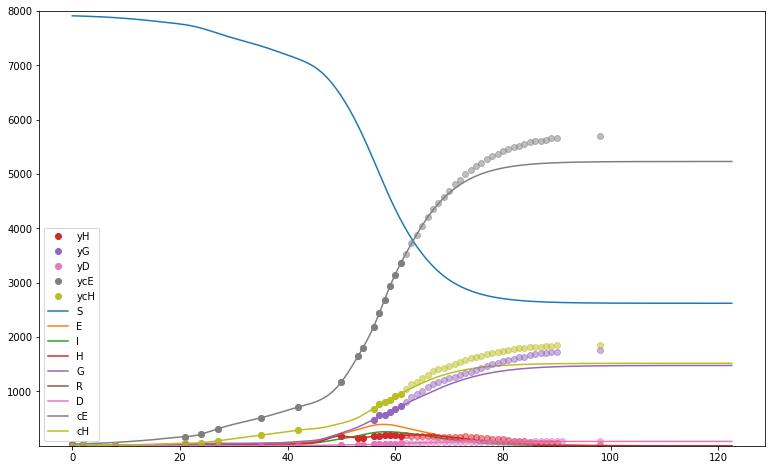

In [14]:
fig, ax=plt.subplots(figsize=[13, 8])
dColours = plt.rcParams['axes.prop_cycle'].by_key()['color']
for clr, data_dots in zip([3,4,6,7,8],[H,G,D,cE,cH]):
    ax.plot(time[start:clip], data_dots[start:clip], 'o', color=dColours[clr])
for clr, data_stripe in zip(dColours, getx(sols[idx]['x'])):
    ax.plot(model.observation_times, data_stripe, color=clr)
for clr, data_dots in zip([3,4,6,7,8],[H,G,D,cE,cH]):
    ax.plot(time, data_dots, 'o', alpha=0.5, color=dColours[clr])
plt.legend(['yH', 'yG', 'yD', 'ycE', 'ycH', 'S', 'E', 'I', 'H', 'G', 'R', 'D', 'cE', 'cH'])
plt.ylim([1e-5, 8000])
# plt.yscale('log')
print(getp(sols[idx]['x']))

In [15]:
solref = sols[idx]['x']
rho = prange[idx]

xref = getx(solref)
pref = getp(solref)

# Data resampling

(0.9749886989593506, 0.9458519816398621)
(0.8220465183258057, 0.026827484369277954)
(0.8587473630905151, 0.014622163958847523)
(0.9643665552139282, 0.7411691546440125)
(0.8617876768112183, 0.032230913639068604)


<Figure size 432x288 with 0 Axes>

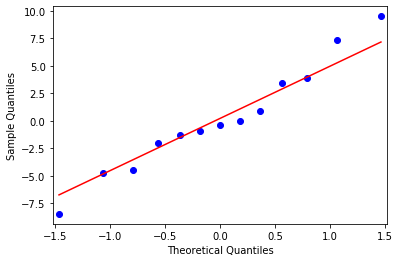

<Figure size 432x288 with 0 Axes>

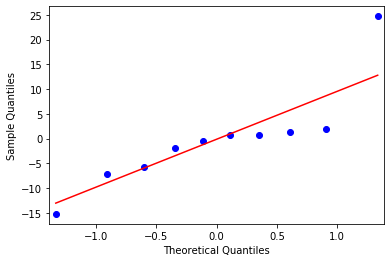

<Figure size 432x288 with 0 Axes>

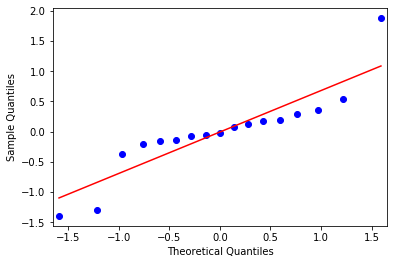

<Figure size 432x288 with 0 Axes>

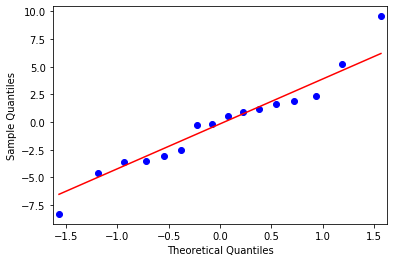

<Figure size 432x288 with 0 Axes>

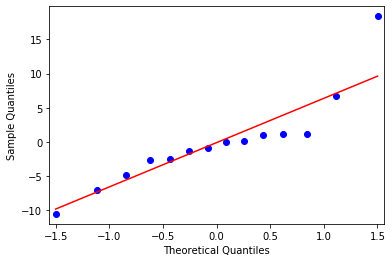

In [43]:
# add model
for obs, i, cm in zip(objective.observations, config['observation_vector'], objective.collocation_matrices):
    cmfilter = np.diag(cm) == 1
    comp = ca.interp1d(model.observation_times,xref[i],objective.observation_times).toarray().flatten()[cmfilter]
    delta = obs[cmfilter] - comp
#     plt.plot(data_time[cmfilter], delta, 'o--')
    plt.figure();
    qqplot(delta, line='s');
    print(stats.shapiro(delta));

In [54]:
add_fits = []
for obs, i, cm in zip(objective.observations, config['observation_vector'], objective.collocation_matrices):
    cmfilter = np.diag(cm) == 1
    comp = ca.interp1d(model.observation_times,xref[i],objective.observation_times).toarray().flatten()[cmfilter]
    delta = obs[cmfilter] - comp
    add_fits.append((stats.norm(*stats.norm.fit(delta)), cmfilter))


In [55]:
def resample_add_fits(add_fits):
    out = []
    for npdf, c in add_fits:
        temp = np.empty((len(c)))
        temp[:] = np.nan
        temp[c] = npdf.rvs(len(c[c]), random_state=None).flatten()
        out.append(temp)
    return out

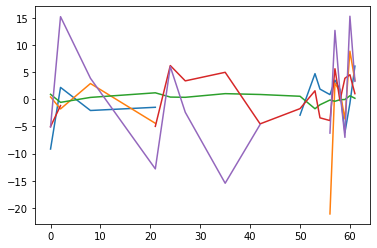

In [57]:
for x in resample_add_fits(add_fits):
    plt.plot(data_time, x)

(0.5797921419143677, 4.4052580051356927e-05)
(0.7216047644615173, 0.001610922976396978)
(0.9323681592941284, 0.23837298154830933)
(0.5081713199615479, 2.478923306625802e-06)
(0.8293094635009766, 0.011771920137107372)


<Figure size 432x288 with 0 Axes>

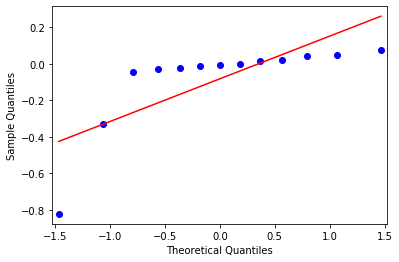

<Figure size 432x288 with 0 Axes>

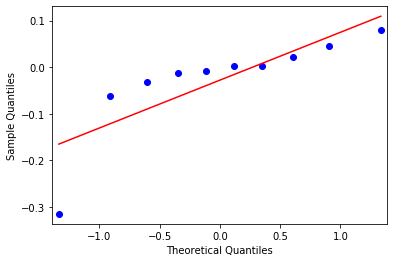

<Figure size 432x288 with 0 Axes>

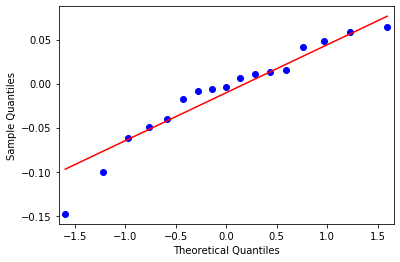

<Figure size 432x288 with 0 Axes>

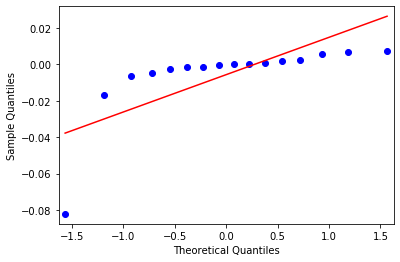

<Figure size 432x288 with 0 Axes>

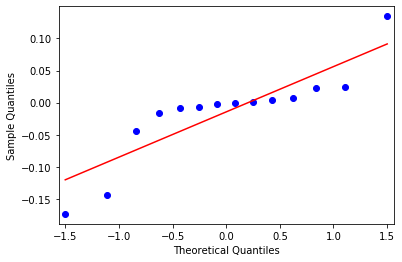

In [16]:
# log model
for obs, i, cm in zip(objective.observations, config['observation_vector'], objective.collocation_matrices):
    cmfilter = np.diag(cm) == 1
    comp = ca.interp1d(model.observation_times,xref[i],objective.observation_times).toarray().flatten()[cmfilter]
    delta = np.log(obs[cmfilter]+1) - np.log(comp+1)
#     plt.plot(data_time[cmfilter], delta, 'o--')
    plt.figure();
    qqplot(delta, line='s');
    print(stats.shapiro(delta));

# do GP reg

In [17]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

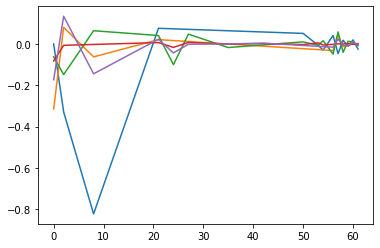

In [18]:
gps = []
for obs, i, cm in zip(objective.observations, config['observation_vector'], objective.collocation_matrices):
    cmfilter = np.diag(cm) == 1
    comp = ca.interp1d(model.observation_times,xref[i],objective.observation_times).toarray().flatten()[cmfilter]
    delta = (np.log(obs[cmfilter]+1) - np.log(comp+1)).reshape(-1,1)
    gptime = data_time[cmfilter].reshape(-1,1)
    plt.plot(gptime, delta)
    gp = gaussian_process.GaussianProcessRegressor(alpha=0.35, kernel=kernel)
    gp.fit(gptime, delta)
    gps.append((gp, gptime, comp, cmfilter))
    

In [19]:
def resample_gp(gps):
    out = []
    for gp, t, x, c in gps:
        temp = np.empty((len(c)))
        temp[:] = np.nan
        y = gp.sample_y(t, random_state=None).flatten()
        temp[c] = np.exp(y+np.log(x+1)).flatten() - 1
        out.append(temp)
    return out

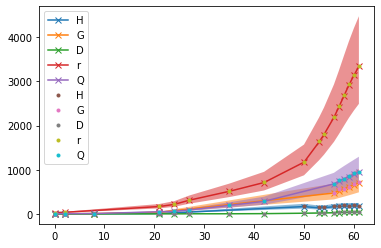

In [20]:
plt.figure()
def GP2Y(x, y):
    return np.exp(y+np.log(x+1)).flatten() - 1
for gp, t, x, c in gps:
    y,s = gp.predict(t, return_std=True)
    y=y.flatten(); s=s.flatten()
    temp = GP2Y(x, y)
    plt.plot(data_time[c], temp, 'x-')
    plt.fill(np.concatenate([data_time[c], data_time[c][::-1]]),
             np.concatenate([GP2Y(x, y - 2*s),
                             GP2Y(x, (y + 2*s))[::-1]]),
         alpha=.5, label='95% CI')
plt.plot(data_time, data_pd, '.')
plt.legend('HGDrQHGDrQ')

In [21]:
yg = [resample_gp(gps) for _ in range(200)]

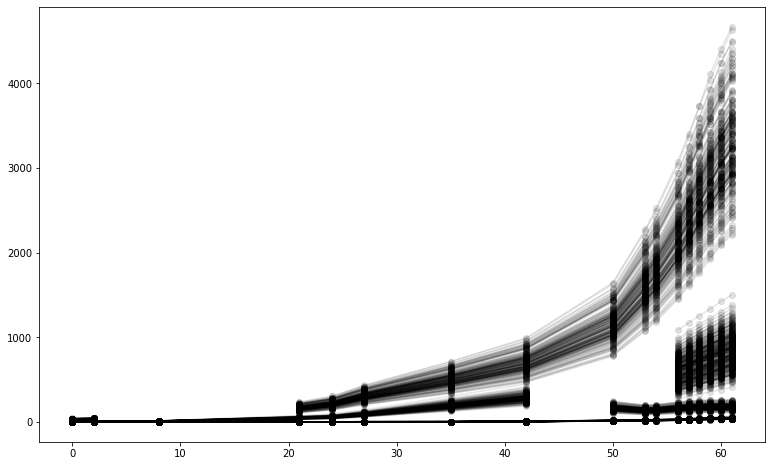

In [22]:
plt.figure(figsize=[13,8])
for y in yg:
    for x in y:
        plt.plot(objective.observation_times, x, 'ko-', alpha=0.1)

# RTO style

In [23]:
# We will the GP model from above, since it seems relatively OK

# need to model the model error

In [24]:
# Dx = model.phi@cs
# f(x;theta): model.model(stuff)

merrfn = ca.Function('merr', [solver_setup['x']], 
                     [model.xdash[:, i]
                       - model.model(model.observation_times, *model.cs, *model.ps)[:, i]
                      for i in range(model.s)])

In [25]:
model_error = merrfn(solref)

(0.8173084259033203, 1.426074834392707e-14)
(0.8601073026657104, 1.367518294784209e-12)
(0.8384461998939514, 1.2220229710958874e-13)
(0.5124450922012329, 2.9996543206112084e-23)
(0.7307533025741577, 9.711329520402222e-18)
(0.8275172710418701, 3.932633366632472e-14)
(0.6789535284042358, 2.7412747405431438e-19)
(0.6983720660209656, 9.89386284578884e-19)
(0.7810161709785461, 5.211629082426587e-16)


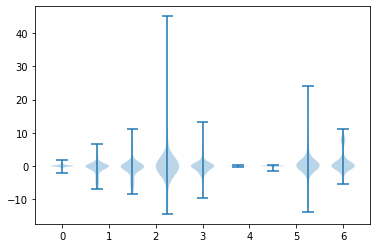

In [26]:
plt.violinplot([m.toarray().flatten() for m in model_error], 
               positions=np.arange(0, len(model_error)*0.75, 0.75))
for state in model_error:
    print(stats.shapiro(state))

In [27]:
dmflat = [m.toarray().flatten().reshape(-1,1) for m in model_error]

NormaltestResult(statistic=array([31.58016336]), pvalue=array([1.38820837e-07]))


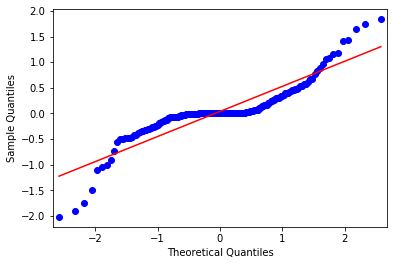

In [28]:
qqplot(np.array([sorted(d) for d in dmflat][0]), line='s')
print(stats.normaltest(np.array([sorted(d) for d in dmflat][0])))
# print(stats.anderson(np.array([sorted(d) for d in dmflat][0])))

In [29]:
me = stats.cauchy(*stats.cauchy.fit(dmflat[0]))
mg = stats.norm(*stats.norm.fit(dmflat[0]))

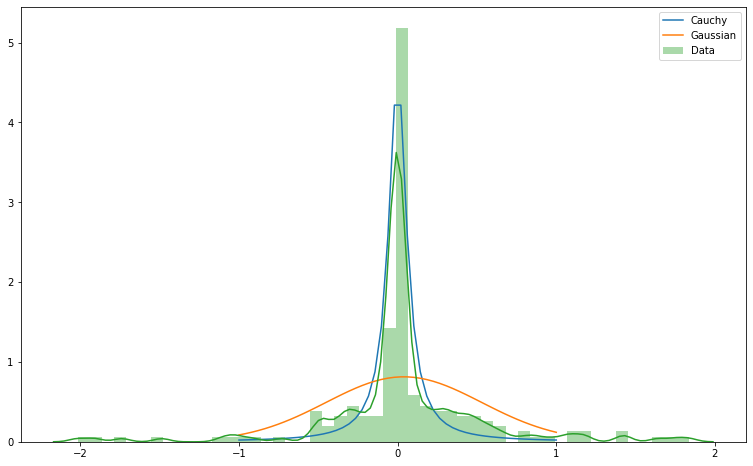

In [73]:
plt.figure(figsize=(13,8))
plt.plot(np.linspace(-1,1), me.pdf(np.linspace(-1,1)), label='Cauchy')
plt.plot(np.linspace(-1,1), mg.pdf(np.linspace(-1,1)), label='Gaussian')
sns.distplot(dmflat[0], label='Data')
plt.legend()


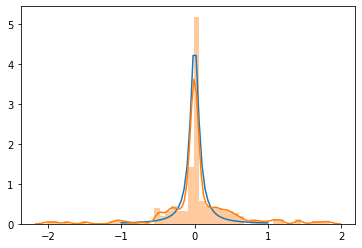

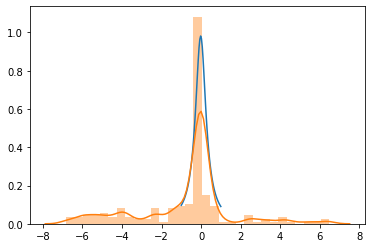

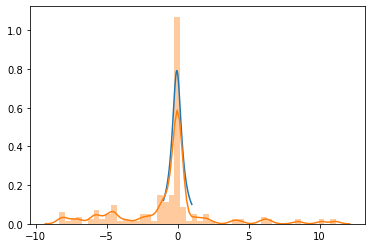

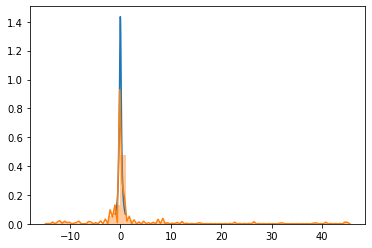

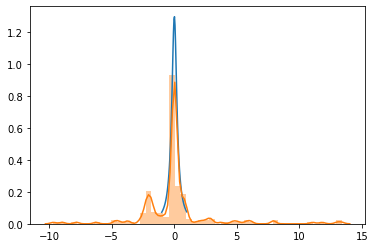

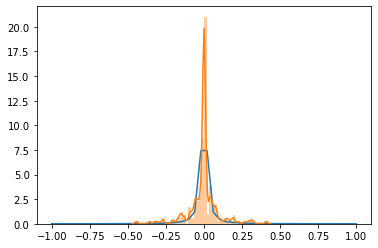

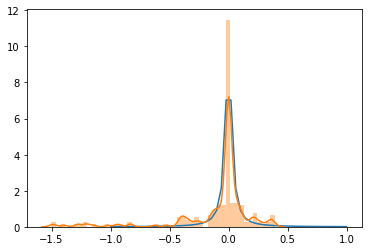

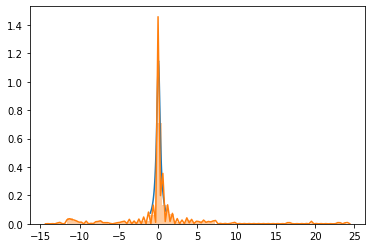

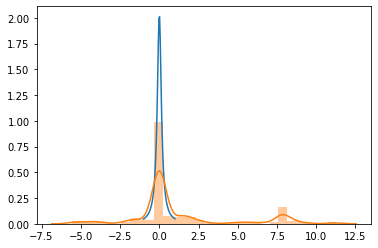

In [31]:
me_cauchies = []
for d in dmflat:
    me_cauchies.append(stats.cauchy(*stats.cauchy.fit(d)))
    plt.figure()
    plt.plot(np.linspace(-1,1), me_cauchies[-1].pdf(np.linspace(-1,1)))
    sns.distplot(d)

In [32]:
def resample_model_error(frozen_dists):
    out = []
    for dist in frozen_dists:
        out.append(dist.rvs(size=(model.n, ), random_state=None))
    return np.vstack(out)

In [34]:
# modify objective.obj2
objective.r = ca.SX.sym('r', 200, 9)
objective.y = ca.SX.sym('y', *data_pd.shape)
objective.obj_1 = sum(w/objective.y.shape[0] * ca.sumsqr(objective.densities*( 
                            objective.y[:,i] - cm@ca.interp1d(model.observation_times,
                            om(model.observation_times, model.ps, 
                               *(model.xs[j] for j in oj)),
                            objective.observation_times)
                        ))
                         for i, (om, oj, w, cm) in enumerate(zip(objective.observation_model,
                                                      objective.observation_vector,
                                                      objective.weightings,
                                                      objective.collocation_matrices)))
objective.obj_2 = ca.sumsqr(model.xdash -model.model(model.observation_times, *model.cs, *model.ps) - objective.r)
objective.objective = objective.obj_1 + objective.rho*objective.obj_2 + objective.alpha*objective.regularisation

In [35]:
resample_opts = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.vcat([objective.rho, objective.alpha, 
                  ca.reshape(objective.y, (-1,1)), ca.reshape(objective.r, (-1,1))]),
    'g': ca.vcat(model.xs),
}
resample_solver = ca.nlpsol('resampler', 'ipopt', resample_opts, ipopt_opts)

In [36]:
# compute y
resample_ys = yg # sample length 500
# compute r
resample_rs = [resample_model_error(me_cauchies) for _ in resample_ys]

# hold sols
resample_rto_sols = []
# run solver
for y, r in zip(resample_ys, resample_rs):
    yf = np.hstack(objective.observations_from_pandas(y).T)[:np.prod(objective.y.shape)]
    resample_run_opts = {
        'x0': solref,
        'p': [rho, alpha, *yf, *r.reshape(-1,1)],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    resample_rto_sols.append(resample_solver(**resample_run_opts))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  50  6.5822045e+04 0.00e+00 6.49e+02  -1.0 1.67e+02  -6.5 1.00e+00 1.00e+00f  1
 100  6.4767342e+04 0.00e+00 3.16e+03  -1.0 4.29e+04    -  2.99e-01 3.12e-02f  6
 150  6.2518415e+04 0.00e+00 8.26e+00  -1.0 2.50e+01  -7.4 1.00e+00 1.00e+00f  1
 200  4.9484631e+04 0.00e+00 4.05e+02  -1.7 2.39e+02    -  1.00e+00 5.00e-01f  2
 250  4.7500111e+04 0.00e+00 7.61e+01  -2.5 1.12e+03    -  1.00e+00 1.25e-01f  4
 300  4.7478558e+04 0.00e+00 1.92e+02  -2.5 3.92e+02    -  1.00e+00 2.50e-01f  3
 350  4.7263558e+04 0.00e+00 5.80e+02  -3.8 4.47e+02  -9.9 1.00e+00 5.00e-01f  2
 400  4.7216797e+04 0.00e+00 8.51e+02  -3.8 1.80e+02  -9.3 1.00e+00 1.00e+00f  1
 450  4.7163798e+04 0.00e+00 1.40e+03  -3.8 6.00e+02 -10.6 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.7118528e+04 0.00e+00 3.95e+02  -3.8 7.22e+01  -9.2 1.00e+00 1.00e+00f  1
 550  4.7078650e+04 0.00e+00 2.07e+02  -3.8 1.08e+03 -11.4 1.00e+00 2.50e-01f  3
 600  4.7050729e+04 0.00e+00

 150  4.7758177e+06 0.00e+00 9.49e-01  -1.0 1.53e+01  -8.0 1.00e+00 1.00e+00f  1
 200  4.7581277e+06 0.00e+00 4.57e+02  -2.5 1.94e+02  -8.6 1.00e+00 1.00e+00f  1
 250  4.7577987e+06 0.00e+00 5.22e+01  -2.5 6.52e+01  -8.4 1.00e+00 1.00e+00f  1
 300  4.7574046e+06 0.00e+00 8.45e+02  -2.5 1.11e+04    -  1.00e+00 1.56e-02f  7
 350  4.7568630e+06 0.00e+00 4.92e+02  -2.5 4.59e+02  -8.5 1.00e+00 2.50e-01f  3
 400  4.7562523e+06 0.00e+00 2.34e+02  -2.5 3.99e+02  -8.4 1.00e+00 2.50e-01f  3
 450  4.7556378e+06 0.00e+00 2.15e+02  -2.5 5.76e+01  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.7549931e+06 0.00e+00 1.19e+02  -2.5 2.42e+01  -7.2 1.00e+00 1.00e+00f  1
 550  4.7543914e+06 0.00e+00 2.74e+02  -2.5 1.14e+02  -7.9 1.00e+00 2.50e-01f  3
 600  4.7538657e+06 0.00e+00 3.89e+02  -2.5 2.47e+02  -8.3 1.00e+00 5.00e-01f  2
 650  4.7535001e+06 0.00e+00 4.46e+01  -2.5 1.11e+01  -7.3 1.00e+00 1.00e+00f  1
 700  4.7533254e+06 0.00e+00

  50  1.2692208e+04 0.00e+00 2.32e+01  -2.5 8.85e-01  -5.0 1.00e+00 2.92e-01f  1
 100  1.2358351e+04 0.00e+00 1.17e-02  -3.8 1.18e-01  -3.9 1.00e+00 1.00e+00f  1
 150  1.2224326e+04 0.00e+00 6.34e+00  -5.7 2.56e+01  -7.0 1.00e+00 5.00e-01f  2
 200  1.2085968e+04 0.00e+00 1.43e-01  -5.7 3.40e-01  -4.7 1.00e+00 1.00e+00f  1
 250  1.2079989e+04 0.00e+00 1.30e-05  -8.6 1.20e+00  -9.3 1.00e+00 1.00e+00h  1
 300  1.2079498e+04 0.00e+00 1.24e-05  -8.6 1.30e-01  -6.8 1.00e+00 1.00e+00h  1
 350  1.2078735e+04 0.00e+00 2.83e-04  -8.6 4.00e+00  -8.9 1.00e+00 1.00e+00h  1
 400  1.2077879e+04 0.00e+00 8.87e-02  -8.6 1.66e+00  -8.1 1.00e+00 1.00e+00f  1
 450  1.2076725e+04 0.00e+00 1.22e+00  -8.6 3.67e+03    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.2075664e+04 0.00e+00 1.02e-07  -8.6 6.58e-02  -6.9 1.00e+00 1.00e+00h  1
 550  1.2073871e+04 0.00e+00 2.86e-04  -8.6 1.90e-02  -5.3 1.00e+00 1.00e+00h  1
 600  1.2072376e+04 0.00e+00

2750  9.3880599e+04 0.00e+00 1.46e+02  -8.6 1.81e+02 -10.2 1.00e+00 1.00e+00f  1
2800  9.3877495e+04 0.00e+00 6.20e-01  -8.6 1.22e+00  -7.9 1.00e+00 1.00e+00h  1
2850  9.3875881e+04 0.00e+00 5.41e-02  -8.6 1.31e+01  -9.2 1.00e+00 1.00e+00h  1
2900  9.3874324e+04 0.00e+00 8.31e-02  -8.6 3.60e+00  -8.7 1.00e+00 1.00e+00h  1
2950  9.3872659e+04 0.00e+00 4.12e-02  -8.6 2.70e-02  -6.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  9.3870779e+04 0.00e+00 5.39e+01  -8.6 8.41e+01 -10.1 1.00e+00 1.00e+00f  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   1.2247406202125350e+02    9.3870779345120565e+04
Dual infeasibility......:   5.3864118051140231e+01    4.1284388357435819e+04
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    1.9206607197372003e-06
Overall NLP error....

 250  2.5730901e+04 0.00e+00 4.16e+03  -2.5 3.85e+02  -8.1 1.00e+00 1.00e+00f  1
 300  2.5060213e+04 0.00e+00 6.68e+01  -2.5 2.01e+03    -  1.00e+00 6.25e-02f  5
 350  2.5043550e+04 0.00e+00 4.33e+00  -2.5 4.81e+01 -11.1 1.00e+00 1.00e+00f  1
 400  2.5036581e+04 0.00e+00 6.55e+01  -2.5 3.82e+01    -  1.00e+00 1.00e+00h  1
 450  2.4966782e+04 0.00e+00 2.10e+02  -3.8 8.12e+01  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.4957659e+04 0.00e+00 1.39e+02  -3.8 5.82e+01 -10.1 1.00e+00 1.00e+00f  1
 550  2.4955059e+04 0.00e+00 7.03e+01  -3.8 4.31e+01 -10.4 1.00e+00 1.00e+00h  1
 600  2.4953593e+04 0.00e+00 4.73e+01  -3.8 3.59e+01 -10.8 1.00e+00 1.00e+00f  1
 650  2.4951659e+04 0.00e+00 9.33e+01  -3.8 3.98e+01 -10.2 1.00e+00 1.00e+00f  1
 700  2.4949136e+04 0.00e+00 6.23e+02  -3.8 3.17e+02 -11.5 1.00e+00 1.00e+00f  1
 750  2.4945357e+04 0.00e+00 5.04e+01  -3.8 2.18e+01  -9.5 1.00e+00 1.00e+00f  1
 800  2.4940498e+04 0.00e+00

 350  8.8566337e+06 0.00e+00 4.96e+01  -5.7 7.46e+01  -9.2 1.00e+00 1.00e+00f  1
 400  8.8562826e+06 0.00e+00 7.59e-01  -5.7 2.86e+00  -6.8 1.00e+00 1.00e+00f  1
 450  8.8558752e+06 0.00e+00 9.04e+01  -5.7 5.53e+01  -8.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  8.8555180e+06 0.00e+00 8.51e+01  -5.7 3.07e+02  -9.4 1.00e+00 1.25e-01f  4
 550  8.8553306e+06 0.00e+00 5.44e+01  -5.7 1.22e+02  -9.8 1.00e+00 1.00e+00f  1
 600  8.8553028e+06 0.00e+00 6.74e+00  -5.7 3.80e+01  -9.2 1.00e+00 1.00e+00f  1
 650  8.8552755e+06 0.00e+00 2.95e+01  -5.7 7.85e+01  -9.6 1.00e+00 1.00e+00f  1
 700  8.8552530e+06 0.00e+00 5.21e-02  -5.7 2.94e+00  -8.2 1.00e+00 1.00e+00h  1
 750  8.8552324e+06 0.00e+00 1.42e+01  -5.7 5.12e+01  -9.5 1.00e+00 1.00e+00f  1
 800  8.8552128e+06 0.00e+00 1.05e+00  -5.7 1.35e+01  -8.9 1.00e+00 1.00e+00h  1
 850  8.8551932e+06 0.00e+00 4.17e+01  -5.7 1.39e+02 -10.2 1.00e+00 1.00e+00f  1
 900  8.8551769e+06 0.00e+00

  50  2.4645077e+06 0.00e+00 9.79e+00  -1.7 3.45e+01  -5.2 1.00e+00 1.00e+00f  1
 100  2.4618211e+06 0.00e+00 3.41e+00  -3.8 2.26e+00  -4.2 1.00e+00 1.00e+00f  1
 150  2.4595829e+06 0.00e+00 1.95e-01  -3.8 8.58e+00  -5.0 1.00e+00 1.00e+00f  1
 200  2.4583303e+06 0.00e+00 3.85e+00  -8.6 1.18e+01  -3.6 6.21e-01 1.25e-01f  4
 250  2.4580939e+06 0.00e+00 9.73e-03  -8.6 3.26e+01  -7.4 1.00e+00 1.00e+00f  1
 300  2.4579059e+06 0.00e+00 1.41e+00  -8.6 5.03e-01  -4.5 1.00e+00 1.00e+00f  1
 350  2.4578725e+06 0.00e+00 6.71e-01  -8.6 2.47e+03    -  6.99e-01 2.50e-01f  3

Number of Iterations....: 379

                                   (scaled)                 (unscaled)
Objective...............:   1.9671924460649447e+04    2.4578712141826428e+06
Dual infeasibility......:   2.0340505184428996e-11    2.5414057620415615e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.1050153648734531e-10    1.1376088401914449e-07
Overall NLP error.....

 150  6.5372352e+04 0.00e+00 8.91e+02  -1.0 1.51e+02  -7.9 1.00e+00 1.00e+00f  1
 200  5.9617410e+04 0.00e+00 6.81e+01  -1.7 9.77e+01  -8.7 1.00e+00 1.00e+00f  1
 250  5.9512339e+04 0.00e+00 4.39e+02  -1.7 1.91e+02    -  1.00e+00 5.00e-01f  2
 300  5.8618939e+04 0.00e+00 4.85e+02  -2.5 8.28e+01  -8.7 1.00e+00 1.00e+00f  1
 350  5.8501927e+04 0.00e+00 1.02e+03  -2.5 2.04e+02  -9.3 1.00e+00 5.00e-01f  2
 400  5.8411442e+04 0.00e+00 1.76e+03  -2.5 1.30e+02  -8.2 1.00e+00 1.00e+00f  1
 450  5.8321567e+04 0.00e+00 4.21e+02  -2.5 6.68e+02    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  5.8238674e+04 0.00e+00 1.23e+02  -2.5 4.73e+01  -9.1 1.00e+00 1.00e+00f  1
 550  5.8160995e+04 0.00e+00 6.18e+01  -2.5 2.08e+01  -8.5 1.00e+00 1.00e+00f  1
 600  5.8089016e+04 0.00e+00 2.38e+02  -2.5 1.43e+02 -10.5 1.00e+00 4.46e-01f  2
 650  5.8020566e+04 0.00e+00 1.89e+02  -2.5 3.94e+01  -8.8 1.00e+00 1.00e+00f  1
 700  5.7958721e+04 0.00e+00

1400  4.5892389e+04 0.00e+00 6.93e+00  -5.7 2.16e+01  -7.6 1.00e+00 1.00e+00f  1
1450  4.5810191e+04 0.00e+00 1.99e-02  -5.7 9.15e-01  -6.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  4.5710021e+04 0.00e+00 8.11e+00  -5.7 2.48e+01  -7.5 1.00e+00 1.00e+00f  1
1550  4.5564072e+04 0.00e+00 6.61e-01  -5.7 9.27e+00  -7.0 1.00e+00 1.00e+00f  1
1600  4.5379204e+04 0.00e+00 1.53e-01  -5.7 5.67e-01  -4.6 1.00e+00 1.00e+00f  1
1650  4.5195956e+04 0.00e+00 1.31e-03  -5.7 1.45e-01  -5.0 1.00e+00 1.00e+00f  1
1700  4.5051011e+04 0.00e+00 7.49e-04  -5.7 1.16e-01  -4.5 1.00e+00 1.00e+00f  1
1750  4.4942310e+04 0.00e+00 1.77e-01  -5.7 7.43e-01  -4.8 1.00e+00 1.00e+00f  1
1800  4.4891225e+04 0.00e+00 2.71e-01  -5.7 6.63e+01  -7.9 8.80e-01 5.38e-02f  5
1850  4.4845804e+04 0.00e+00 5.22e-02  -5.7 6.91e-01  -5.6 1.00e+00 1.00e+00f  1
1900  4.4819213e+04 0.00e+00 1.50e-01  -5.7 6.17e+01 -10.5 1.00e+00 1.00e+00f  1
1950  4.4818150e+04 0.00e+00

2400  3.8701574e+04 0.00e+00 1.34e-02  -5.7 2.96e-01  -5.1 1.00e+00 1.00e+00f  1
2450  3.8661039e+04 0.00e+00 4.19e+00  -5.7 4.44e+01  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  3.8616757e+04 0.00e+00 6.04e-01  -5.7 1.23e+01  -6.8 1.00e+00 1.00e+00f  1
2550  3.8578116e+04 0.00e+00 8.08e-01  -5.7 2.82e+01  -7.1 1.00e+00 1.00e+00f  1
2600  3.8531816e+04 0.00e+00 1.71e-01  -5.7 8.26e+00  -6.6 1.00e+00 1.00e+00f  1
2650  3.8476027e+04 0.00e+00 6.47e+00  -5.7 2.18e+01  -5.2 1.00e+00 6.25e-02f  5
2700  3.8432931e+04 0.00e+00 7.28e-02  -5.7 1.61e-01  -4.7 1.00e+00 1.00e+00f  1
2750  3.8403971e+04 0.00e+00 1.98e+00  -5.7 1.45e+02  -8.6 1.00e+00 1.00e+00f  1
2800  3.8389247e+04 0.00e+00 6.36e-03  -5.7 5.49e+01  -9.0 1.00e+00 1.00e+00f  1
2850  3.8360511e+04 0.00e+00 2.65e-01  -5.7 2.96e-01  -4.3 1.00e+00 1.00e+00f  1
2900  3.8332759e+04 0.00e+00 2.29e-04  -5.7 1.51e+00  -7.2 1.00e+00 1.00e+00h  1
2950  3.8293492e+04 0.00e+00


                                   (scaled)                 (unscaled)
Objective...............:   3.8602566375962812e+02    5.6048694428128649e+04
Dual infeasibility......:   3.8395278949484196e-12    5.5747725069968889e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    3.6384270805975535e-07
Overall NLP error.......:   2.5059035596800622e-09    3.6384270805975535e-07


Number of objective function evaluations             = 922
Number of objective gradient evaluations             = 628
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 922
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 628
Number of Lagrangian Hessian evaluations             = 627
Total CPU secs in IPOPT (w/o function evaluations)   =      5.933
Total CPU secs in NLP function evaluations           =      1.207


1200  2.8997680e+05 0.00e+00 1.24e+03  -8.6 3.95e+02  -8.8 1.00e+00 1.00e+00f  1
1250  2.8984322e+05 0.00e+00 2.61e-02  -8.6 1.84e+00  -6.5 1.00e+00 1.00e+00f  1
1300  2.8949144e+05 0.00e+00 2.75e+01  -8.6 1.18e+00  -5.8 1.00e+00 1.00e+00f  1
1350  2.8948620e+05 0.00e+00 8.02e+00  -8.6 1.59e+02 -11.2 1.00e+00 1.00e+00h  1
1400  2.8948588e+05 0.00e+00 1.37e+00  -8.6 1.63e+02 -11.2 1.00e+00 1.00e+00h  1
1450  2.8948551e+05 0.00e+00 6.78e-01  -8.6 1.34e+01 -10.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  2.8948502e+05 0.00e+00 1.24e-01  -8.6 1.86e+00  -8.9 1.00e+00 1.00e+00h  1
1550  2.8948449e+05 0.00e+00 1.42e-02  -8.6 9.96e-02  -7.8 1.00e+00 1.00e+00h  1
1600  2.8948401e+05 0.00e+00 5.08e-02  -8.6 1.07e-01  -7.8 1.00e+00 1.00e+00h  1
1650  2.8948356e+05 0.00e+00 9.72e-02  -8.6 5.18e-03  -5.8 1.00e+00 1.00e+00h  1
1700  2.8948307e+05 0.00e+00 2.16e-03  -8.6 7.63e-04  -3.8 1.00e+00 1.00e+00h  1
1750  2.8948271e+05 0.00e+00

 250  4.6746910e+05 0.00e+00 8.37e-01  -3.8 3.07e+00  -5.7 1.00e+00 1.00e+00f  1
 300  4.6737122e+05 0.00e+00 3.65e+00  -3.8 5.43e+01  -7.9 1.00e+00 1.00e+00f  1
 350  4.6730519e+05 0.00e+00 1.66e-02  -5.7 1.94e-01  -5.5 1.00e+00 1.00e+00h  1
 400  4.6724747e+05 0.00e+00 3.51e-01  -5.7 2.68e+01  -7.7 1.00e+00 1.00e+00f  1
 450  4.6719036e+05 0.00e+00 3.69e-02  -5.7 8.09e+00  -7.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.6712847e+05 0.00e+00 3.83e-03  -5.7 2.51e+00  -6.6 1.00e+00 1.00e+00f  1
 550  4.6706907e+05 0.00e+00 5.78e-04  -5.7 1.02e-01  -5.2 1.00e+00 1.00e+00f  1
 600  4.6701566e+05 0.00e+00 6.67e+00  -5.7 1.22e+02  -8.3 1.00e+00 1.00e+00f  1
 650  4.6696983e+05 0.00e+00 1.00e+00  -5.7 3.88e+01  -7.8 1.00e+00 1.00e+00f  1
 700  4.6691767e+05 0.00e+00 4.06e-02  -5.7 1.62e+00  -6.3 1.00e+00 1.00e+00f  1
 750  4.6686637e+05 0.00e+00 1.75e+00  -5.7 1.20e+00  -5.8 1.00e+00 1.00e+00f  1
 800  4.6678077e+05 0.00e+00

1700  6.4247550e+04 0.00e+00 3.94e+01  -3.8 2.43e+01  -7.6 1.00e+00 1.00e+00f  1
1750  6.4220661e+04 0.00e+00 2.80e+00  -3.8 8.21e+00  -7.0 1.00e+00 1.00e+00f  1
1800  6.4185992e+04 0.00e+00 3.59e+01  -3.8 1.81e+01  -7.4 1.00e+00 5.00e-01f  2
1850  6.4158130e+04 0.00e+00 5.39e+01  -3.8 4.79e+01  -7.8 1.00e+00 5.00e-01f  2
1900  6.4121240e+04 0.00e+00 2.66e+01  -3.8 4.05e+02  -7.2 1.00e+00 1.56e-02f  7
1950  6.4092054e+04 0.00e+00 5.72e+01  -3.8 5.45e+01  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  6.4066322e+04 0.00e+00 6.64e+00  -3.8 1.82e+00  -6.2 1.00e+00 1.00e+00f  1
2050  6.4041602e+04 0.00e+00 6.90e-01  -3.8 5.15e-01  -5.7 1.00e+00 1.00e+00f  1
2100  6.4018168e+04 0.00e+00 8.45e-01  -3.8 8.58e+00  -6.9 1.00e+00 1.00e+00f  1
2150  6.3991060e+04 0.00e+00 7.83e+00  -5.7 2.36e+01  -7.3 1.00e+00 6.25e-02f  5
2200  6.3971547e+04 0.00e+00 7.23e-01  -5.7 3.74e+01  -7.7 1.00e+00 1.00e+00f  1
2250  6.3945856e+04 0.00e+00

 150  1.5541632e+05 0.00e+00 5.49e+00  -5.7 2.23e+03 -11.6 1.00e+00 1.00e+00f  1
 200  1.5541470e+05 0.00e+00 7.98e-03  -5.7 7.08e+01 -10.0 1.00e+00 1.00e+00f  1
 250  1.5541261e+05 0.00e+00 4.50e-01  -5.7 3.70e+00  -7.7 1.00e+00 1.00e+00f  1
 300  1.5540947e+05 0.00e+00 1.67e-01  -5.7 1.13e+02  -9.8 1.00e+00 1.00e+00f  1
 350  1.5540464e+05 0.00e+00 4.93e-02  -5.7 5.57e+01  -9.2 1.00e+00 1.00e+00f  1
 400  1.5539911e+05 0.00e+00 2.91e-02  -5.7 1.10e+00  -6.8 1.00e+00 1.00e+00f  1
 450  1.5539260e+05 0.00e+00 3.16e+00  -5.7 2.58e+02  -9.4 1.00e+00 3.78e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.5538412e+05 0.00e+00 7.23e-01  -5.7 4.04e+01  -8.4 1.00e+00 1.00e+00f  1

Number of Iterations....: 508

                                   (scaled)                 (unscaled)
Objective...............:   1.3732862143250757e+03    1.5538377408946279e+05
Dual infeasibility......:   1.0667508524420420e-11    1.2070009276766793e-09
Constraint vio

2800  5.5778949e+04 0.00e+00 7.45e-04  -8.6 2.09e-01  -5.5 1.00e+00 1.00e+00h  1
2850  5.5778718e+04 0.00e+00 7.56e-03  -8.6 1.80e+00  -9.2 1.00e+00 1.00e+00h  1

Number of Iterations....: 2893

                                   (scaled)                 (unscaled)
Objective...............:   9.5346867648722736e+01    5.5778628864811086e+04
Dual infeasibility......:   4.8571112397579323e-09    2.8414463094445396e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5476711958436099e-09    1.4904066552671255e-06
Overall NLP error.......:   4.8571112397579323e-09    2.8414463094445396e-06


Number of objective function evaluations             = 4583
Number of objective gradient evaluations             = 2894
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 4583
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations 

  50  2.1132491e+06 0.00e+00 1.24e+01  -1.0 9.63e+00  -4.8 1.00e+00 1.00e+00f  1
 100  2.1116912e+06 0.00e+00 1.30e+03  -1.0 2.62e+02  -6.7 1.00e+00 5.00e-01f  2
 150  2.1120661e+06 0.00e+00 1.37e+04  -1.0 4.09e+02  -7.2 1.00e+00 1.00e+00f  1
 200  2.1118462e+06 0.00e+00 6.99e+03  -1.0 1.22e+04    -  1.00e+00 1.25e-01f  4
 250  2.1076761e+06 0.00e+00 5.55e+02  -2.5 1.54e+02  -8.8 1.00e+00 1.00e+00f  1
 300  2.1075654e+06 0.00e+00 1.12e+03  -2.5 1.32e+02  -8.6 1.00e+00 1.00e+00f  1
 350  2.1074218e+06 0.00e+00 8.61e+02  -2.5 5.99e+02  -8.0 1.00e+00 2.50e-01f  3
 400  2.1072286e+06 0.00e+00 1.09e+03  -2.5 1.33e+02  -8.3 1.00e+00 1.00e+00f  1
 450  2.1069831e+06 0.00e+00 3.02e+03  -2.5 2.10e+02  -8.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.1066287e+06 0.00e+00 1.86e+02  -2.5 2.44e+01  -6.7 1.00e+00 1.00e+00f  1
 550  2.1062078e+06 0.00e+00 4.75e+02  -2.5 2.99e+01  -7.1 1.00e+00 1.00e+00f  1
 600  2.1057825e+06 0.00e+00

 850  4.8563944e+05 0.00e+00 9.29e-03  -5.7 2.22e+00  -7.3 1.00e+00 1.00e+00h  1
 900  4.8557505e+05 0.00e+00 1.39e+00  -5.7 3.20e+01  -8.6 1.00e+00 1.00e+00f  1
 950  4.8553210e+05 0.00e+00 3.88e+00  -5.7 5.19e+01  -9.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  4.8550442e+05 0.00e+00 5.24e+00  -5.7 6.69e+01  -9.3 1.00e+00 1.00e+00f  1
1050  4.8548906e+05 0.00e+00 2.89e-02  -5.7 5.75e+00  -8.8 1.00e+00 1.00e+00h  1
1100  4.8548257e+05 0.00e+00 3.70e-01  -5.7 2.87e+02 -11.4 1.00e+00 1.00e+00h  1
1150  4.8547871e+05 0.00e+00 3.07e-05  -5.7 4.10e-01  -9.1 1.00e+00 1.00e+00h  1
1200  4.8547642e+05 0.00e+00 8.01e-04  -5.7 8.37e+00 -10.4 1.00e+00 1.00e+00h  1
1250  4.8547371e+05 0.00e+00 2.90e-02  -5.7 4.01e+00  -9.8 1.00e+00 1.00e+00h  1
1300  4.8547086e+05 0.00e+00 3.28e-04  -5.7 7.11e+00 -10.2 1.00e+00 1.00e+00h  1
1350  4.8546796e+05 0.00e+00 7.91e-03  -5.7 6.11e-01  -7.9 1.00e+00 1.00e+00h  1
1400  4.8546556e+05 0.00e+00

  50  7.4845699e+04 0.00e+00 2.67e+03  -1.0 2.51e+02  -6.7 1.00e+00 1.00e+00f  1
 100  6.9234527e+04 0.00e+00 4.17e+03  -1.0 2.63e+04    -  1.00e+00 1.25e-01f  4
 150  5.7894914e+04 0.00e+00 1.35e+03  -1.7 6.14e+02  -7.9 1.00e+00 1.00e+00f  1
 200  5.3693380e+04 0.00e+00 4.86e+00  -2.5 2.54e+02    -  1.00e+00 1.00e+00h  1
 250  5.3518967e+04 0.00e+00 9.27e+01  -3.8 5.14e+01  -9.6 1.00e+00 1.00e+00f  1
 300  5.3508803e+04 0.00e+00 1.87e+02  -3.8 2.22e+02 -10.0 1.00e+00 2.50e-01f  3
 350  5.3498871e+04 0.00e+00 3.48e+01  -3.8 2.04e+01  -9.5 1.00e+00 1.00e+00f  1
 400  5.3488956e+04 0.00e+00 3.05e+02  -3.8 5.02e+01  -9.8 1.00e+00 1.00e+00f  1
 450  5.3479301e+04 0.00e+00 3.18e+02  -3.8 4.54e+01 -10.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  5.3470013e+04 0.00e+00 5.59e+01  -3.8 1.69e+01  -9.7 1.00e+00 1.00e+00f  1
 550  5.3461297e+04 0.00e+00 6.94e+01  -3.8 1.42e+01  -9.2 1.00e+00 1.00e+00f  1
 600  5.3453227e+04 0.00e+00

 150  1.1059828e+07 0.00e+00 9.98e+02  -3.8 3.89e+03  -9.5 1.00e+00 5.00e-01f  2
 200  1.0870240e+07 0.00e+00 1.66e+02  -3.8 4.01e+02  -8.0 1.00e+00 5.00e-01f  2
 250  1.0804642e+07 0.00e+00 1.36e+02  -3.8 6.76e+01  -7.5 1.00e+00 1.00e+00f  1
 300  1.0773050e+07 0.00e+00 6.92e+01  -3.8 3.46e+01  -7.0 1.00e+00 1.00e+00f  1
 350  1.0756260e+07 0.00e+00 1.39e+00  -3.8 6.71e+01  -7.4 1.00e+00 1.00e+00f  1
 400  1.0745763e+07 0.00e+00 2.93e+01  -3.8 1.93e+02  -7.7 1.00e+00 1.00e+00f  1
 450  1.0739439e+07 0.00e+00 3.82e+00  -3.8 6.24e+01  -7.2 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.0732951e+07 0.00e+00 1.23e+00  -5.7 7.08e+00  -5.8 3.50e-02 6.86e-02f  1
 550  1.0722321e+07 0.00e+00 2.00e+01  -5.7 6.79e+01  -7.1 1.00e+00 1.00e+00f  1
 600  1.0714613e+07 0.00e+00 2.69e-01  -5.7 3.56e-01  -4.7 1.00e+00 1.00e+00f  1
 650  1.0708056e+07 0.00e+00 2.23e-01  -5.7 4.70e-01  -4.2 1.00e+00 1.00e+00f  1
 700  1.0698904e+07 0.00e+00

 250  4.9857960e+04 0.00e+00 1.34e+00  -5.7 1.39e+00  -4.9 1.00e+00 1.00e+00f  1
 300  4.9607368e+04 0.00e+00 1.66e+01  -5.7 2.53e+01  -6.2 1.00e+00 1.00e+00f  1
 350  4.9404184e+04 0.00e+00 9.18e-01  -5.7 7.82e-01  -4.7 1.00e+00 1.00e+00f  1
 400  4.9288932e+04 0.00e+00 1.75e+00  -5.7 9.23e+00  -6.0 1.00e+00 1.00e+00f  1
 450  4.9210976e+04 0.00e+00 5.80e+00  -5.7 7.13e+01  -7.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.9007766e+04 0.00e+00 1.01e-02  -5.7 6.45e-01  -5.9 1.00e+00 1.00e+00f  1
 550  4.8988470e+04 0.00e+00 2.76e-04  -8.6 2.11e+00  -8.8 1.00e+00 1.00e+00h  1
 600  4.8985002e+04 0.00e+00 1.46e-02  -8.6 9.35e+00  -9.1 1.00e+00 1.00e+00h  1
 650  4.8981494e+04 0.00e+00 1.67e-02  -8.6 1.25e+02 -10.0 1.00e+00 1.00e+00f  1
 700  4.8976790e+04 0.00e+00 1.36e-04  -8.6 1.03e-01  -5.5 1.00e+00 1.00e+00h  1
 750  4.8969931e+04 0.00e+00 9.57e-01  -8.6 1.33e+00  -7.0 1.00e+00 1.00e+00f  1
 800  4.8962044e+04 0.00e+00

 800  6.3816823e+05 0.00e+00 2.90e+00  -5.7 3.74e+03    -  1.00e+00 6.25e-02f  5

Number of Iterations....: 841

                                   (scaled)                 (unscaled)
Objective...............:   1.8678200077279212e+02    6.3816719256450981e+05
Dual infeasibility......:   1.0320215386675346e-10    3.5260479343441243e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596801098e-09    8.5617748653617327e-06
Overall NLP error.......:   2.5059035596801098e-09    8.5617748653617327e-06


Number of objective function evaluations             = 1971
Number of objective gradient evaluations             = 842
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1971
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 842
Number of Lagrangian Hessian evaluations             = 841
Total CPU secs in 

 300  1.1012961e+06 0.00e+00 4.69e-01  -8.6 5.40e+02 -10.8 1.00e+00 1.00e+00f  1
 350  1.1012913e+06 0.00e+00 1.13e-04  -8.6 2.66e+01 -10.4 1.00e+00 1.00e+00h  1
 400  1.1012891e+06 0.00e+00 4.27e-07  -8.6 8.42e-02  -7.6 1.00e+00 1.00e+00h  1

Number of Iterations....: 426

                                   (scaled)                 (unscaled)
Objective...............:   2.4270255073955145e+03    1.1012873842302039e+06
Dual infeasibility......:   4.2517742699452227e-09    1.9292856007558225e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    1.1370790986596259e-06
Overall NLP error.......:   4.2517742699452227e-09    1.9292856007558225e-06


Number of objective function evaluations             = 593
Number of objective gradient evaluations             = 427
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 593
Number of equality constraint Jac

 150  3.1179492e+05 0.00e+00 1.10e+01  -1.7 1.69e+01  -6.3 1.00e+00 1.00e+00f  1
 200  3.1186972e+05 0.00e+00 2.73e+03  -1.7 1.41e+02  -7.4 1.00e+00 1.00e+00f  1
 250  3.1187617e+05 0.00e+00 8.51e+01  -1.7 1.64e+01  -6.3 1.00e+00 1.00e+00f  1
 300  3.1187629e+05 0.00e+00 3.06e+02  -1.7 4.30e+01  -7.1 1.00e+00 1.00e+00f  1
 350  3.1187694e+05 0.00e+00 1.48e+03  -1.7 1.30e+02  -7.6 1.00e+00 1.00e+00f  1
 400  3.1187980e+05 0.00e+00 1.92e+03  -1.7 5.97e+04    -  2.35e-01 7.66e-03f  3
 450  3.1188267e+05 0.00e+00 1.29e+04  -1.7 1.17e+03  -8.9 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.1188146e+05 0.00e+00 1.96e+04  -1.7 2.06e+04    -  1.00e+00 3.12e-02f  6
 550  3.1186958e+05 0.00e+00 1.34e+02  -1.7 1.62e+02  -8.9 1.00e+00 1.00e+00f  1
 600  3.1186649e+05 0.00e+00 1.42e+01  -1.7 1.07e+01    -  1.00e+00 1.00e+00h  1
 650  3.1164117e+05 0.00e+00 9.28e+01  -2.5 2.66e+01  -7.6 1.00e+00 1.00e+00f  1
 700  3.1159568e+05 0.00e+00

  50  1.2005748e+05 0.00e+00 2.40e+00  -1.7 2.92e+00  -5.1 1.00e+00 1.00e+00f  1
 100  1.1994580e+05 0.00e+00 1.07e+03  -1.7 6.28e+01  -6.3 1.00e+00 1.00e+00f  1
 150  1.1995029e+05 0.00e+00 5.58e+02  -1.7 6.10e+01  -6.8 1.00e+00 1.00e+00f  1
 200  1.1993995e+05 0.00e+00 7.27e+02  -1.7 7.28e+01  -7.1 1.00e+00 1.00e+00f  1
 250  1.1994524e+05 0.00e+00 3.55e+00  -1.7 2.49e+01  -6.8 1.00e+00 1.00e+00f  1
 300  1.1993380e+05 0.00e+00 4.77e+02  -1.7 7.31e+01  -7.5 1.00e+00 1.00e+00f  1
 350  1.1991362e+05 0.00e+00 4.04e+00  -1.7 4.15e+01  -7.5 1.00e+00 1.00e+00f  1
 400  1.1990509e+05 0.00e+00 3.96e+03  -1.7 2.36e+04    -  9.21e-01 3.12e-02f  6
 450  1.1989387e+05 0.00e+00 4.44e+03  -1.7 1.35e+04    -  1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.1990017e+05 0.00e+00 2.34e+03  -1.7 2.75e+03    -  1.00e+00 6.25e-02f  5
 550  1.1991519e+05 0.00e+00 2.64e+02  -1.7 3.56e+01    -  1.00e+00 1.00e+00h  1
 600  1.1963962e+05 0.00e+00

2200  3.2267885e+05 0.00e+00 6.87e-04  -8.6 4.13e-02  -8.6 1.00e+00 1.00e+00h  1
2250  3.2267882e+05 0.00e+00 2.17e-03  -8.6 9.44e-03  -7.1 1.00e+00 1.00e+00h  1
2300  3.2267880e+05 0.00e+00 5.14e-01  -8.6 3.29e+01 -11.5 1.00e+00 1.00e+00h  1
2350  3.2267878e+05 0.00e+00 1.30e+01  -8.6 2.61e+04    -  2.65e-01 1.38e-02f  3

Number of Iterations....: 2365

                                   (scaled)                 (unscaled)
Objective...............:   7.9325582524476829e+02    3.2267876619058393e+05
Dual infeasibility......:   1.2493132937136614e-09    5.0819276628271766e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596835657e-09    1.0193456424751521e-06
Overall NLP error.......:   2.5059035596835657e-09    1.0193456424751521e-06


Number of objective function evaluations             = 4424
Number of objective gradient evaluations             = 2366
Number of equality constraint evaluations            = 0
Number o

 100  7.2789529e+05 0.00e+00 1.91e+03  -1.0 4.55e+02  -8.2 1.00e+00 1.00e+00f  1
 150  7.2844401e+05 0.00e+00 7.72e+00  -1.0 2.72e+01    -  1.00e+00 1.00e+00f  1
 200  6.9685619e+05 0.00e+00 5.33e+00  -3.8 2.94e+01  -7.4 1.00e+00 1.00e+00f  1
 250  6.9586017e+05 0.00e+00 6.03e+02  -3.8 2.23e+03    -  1.00e+00 1.00e+00f  1
 300  6.9547938e+05 0.00e+00 4.16e+02  -3.8 3.65e+03    -  1.00e+00 1.25e-01f  4
 350  6.9466074e+05 0.00e+00 3.91e+02  -3.8 1.33e+04    -  3.79e-01 2.50e-01f  3
 400  6.9336688e+05 0.00e+00 7.56e+02  -3.8 7.50e+02    -  1.00e+00 1.00e+00f  1
 450  6.9210126e+05 0.00e+00 3.47e+02  -3.8 3.61e+01  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  6.9124908e+05 0.00e+00 7.00e+02  -3.8 4.21e+01 -11.1 1.00e+00 1.00e+00f  1
 550  6.9076316e+05 0.00e+00 4.96e+01  -3.8 4.15e+00  -8.1 1.00e+00 1.00e+00f  1
 600  6.9042943e+05 0.00e+00 3.13e+02  -3.8 6.83e+02    -  1.00e+00 1.00e+00f  1
 650  6.9031868e+05 0.00e+00

 600  3.8417681e+04 0.00e+00 1.93e+02  -3.8 3.80e+02 -11.3 1.00e+00 1.00e+00f  1
 650  3.8407945e+04 0.00e+00 7.85e+02  -3.8 2.37e+02 -10.2 1.00e+00 5.00e-01f  2
 700  3.8397063e+04 0.00e+00 5.62e+01  -3.8 1.36e+04    -  4.09e-01 2.64e-02f  6
 750  3.8386652e+04 0.00e+00 2.50e+01  -3.8 2.90e+01  -8.9 1.00e+00 1.00e+00f  1
 800  3.8375081e+04 0.00e+00 3.01e+02  -3.8 1.80e+03    -  1.00e+00 1.25e-01f  4
 850  3.8362067e+04 0.00e+00 4.32e+02  -3.8 1.02e+02  -9.7 1.00e+00 1.00e+00f  1
 900  3.8348226e+04 0.00e+00 2.91e+02  -3.8 9.14e+01 -10.1 1.00e+00 1.00e+00f  1
 950  3.8332849e+04 0.00e+00 4.22e+01  -3.8 3.04e+01  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.8317255e+04 0.00e+00 4.87e+02  -3.8 5.55e+02  -9.1 1.00e+00 6.25e-02f  5
1050  3.8300134e+04 0.00e+00 4.11e+02  -3.8 2.82e+01  -7.5 1.00e+00 1.00e+00f  1
1100  3.8281667e+04 0.00e+00 2.82e+02  -3.8 5.78e+01 -10.6 1.00e+00 5.00e-01f  2
1150  3.8263847e+04 0.00e+00

  50  8.9925626e+04 0.00e+00 1.10e+03  -1.0 2.96e+02  -6.6 1.00e+00 5.00e-01f  2
 100  8.7892780e+04 0.00e+00 4.09e+03  -1.0 1.62e+03  -7.5 1.00e+00 2.50e-01f  3
 150  8.6463503e+04 0.00e+00 2.17e+02  -1.0 9.35e+01  -7.6 1.00e+00 1.00e+00f  1
 200  7.3733339e+04 0.00e+00 3.02e+03  -2.5 5.49e+02  -8.3 1.00e+00 5.00e-01f  2
 250  7.2622590e+04 0.00e+00 2.50e+02  -2.5 3.63e+02    -  1.00e+00 1.00e+00f  1
 300  7.2615020e+04 0.00e+00 3.86e+01  -2.5 6.37e+01    -  1.00e+00 5.00e-01h  2
 350  7.2470353e+04 0.00e+00 4.05e+02  -3.8 5.86e+02 -10.6 1.00e+00 2.50e-01f  3
 400  7.2454670e+04 0.00e+00 1.59e+02  -3.8 3.42e+02 -10.5 1.00e+00 2.50e-01f  3
 450  7.2441145e+04 0.00e+00 1.53e+02  -3.8 1.96e+02 -10.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  7.2429805e+04 0.00e+00 5.13e+00  -3.8 1.04e+01  -8.4 1.00e+00 1.00e+00f  1
 550  7.2417491e+04 0.00e+00 5.29e+01  -3.8 5.19e+01  -9.2 1.00e+00 1.00e+00f  1
 600  7.2406911e+04 0.00e+00

 150  2.0727816e+05 0.00e+00 7.19e+02  -1.7 2.36e+02  -7.6 1.00e+00 1.00e+00f  1
 200  2.0698370e+05 0.00e+00 5.52e+01  -1.7 9.23e+01  -7.9 1.00e+00 1.00e+00f  1
 250  2.0695869e+05 0.00e+00 1.66e+03  -1.7 1.48e+04    -  1.00e+00 6.25e-02f  5
 300  2.0707172e+05 0.00e+00 3.94e+02  -1.7 1.14e+02    -  1.00e+00 1.00e+00f  1
 350  2.0718909e+05 0.00e+00 8.24e+01  -1.7 3.82e+01    -  1.00e+00 1.00e+00h  1
 400  2.0547616e+05 0.00e+00 2.85e+03  -3.8 4.27e+02 -10.3 1.00e+00 5.00e-01f  2
 450  2.0532345e+05 0.00e+00 7.65e+01  -3.8 5.84e+01  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.0530867e+05 0.00e+00 7.30e+00  -5.7 8.16e+01 -10.1 1.00e+00 1.00e+00f  1

Number of Iterations....: 522

                                   (scaled)                 (unscaled)
Objective...............:   3.9052047431719268e+02    2.0530776375700792e+05
Dual infeasibility......:   3.0873068032736285e-09    1.6230853373825280e-06
Constraint vio

  50  5.4790051e+04 0.00e+00 8.50e+00  -1.0 5.99e+00  -3.4 1.00e+00 1.00e+00f  1
 100  5.5065836e+04 0.00e+00 2.00e+02  -1.0 2.18e+01  -5.4 1.00e+00 1.00e+00f  1
 150  5.5032570e+04 0.00e+00 2.27e+03  -1.0 2.11e+04    -  6.57e-01 6.25e-02f  5
 200  5.4850888e+04 0.00e+00 5.61e+03  -1.0 9.57e+02  -7.7 1.00e+00 2.50e-01f  3
 250  5.4594670e+04 0.00e+00 6.67e+02  -1.0 5.79e+01  -6.8 1.00e+00 1.00e+00f  1
 300  5.4517749e+04 0.00e+00 3.26e+02  -1.0 4.36e+01  -7.1 1.00e+00 1.00e+00f  1
 350  5.4541278e+04 0.00e+00 4.57e+01  -1.0 2.15e+01  -8.3 1.00e+00 1.00e+00f  1
 400  5.3035462e+04 0.00e+00 1.54e+02  -2.5 3.94e+01  -8.6 1.00e+00 1.00e+00f  1
 450  5.3010794e+04 0.00e+00 1.43e+02  -2.5 2.75e+03    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  5.2990070e+04 0.00e+00 1.44e+03  -2.5 3.12e+02  -9.9 1.00e+00 2.50e-01f  3
 550  5.2972987e+04 0.00e+00 1.41e+03  -2.5 1.44e+02  -9.7 1.00e+00 5.00e-01f  2
 600  5.2957628e+04 0.00e+00

 350  2.7306687e+04 0.00e+00 9.94e-01  -5.7 1.32e+00  -5.2 1.00e+00 1.00e+00f  1
 400  2.7212451e+04 0.00e+00 2.03e+01  -5.7 2.45e+01  -6.4 1.00e+00 1.00e+00f  1
 450  2.7138947e+04 0.00e+00 1.93e+01  -5.7 5.30e+01  -6.8 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.7053142e+04 0.00e+00 8.39e+00  -5.7 4.44e+01  -7.2 1.00e+00 1.00e+00f  1
 550  2.6980653e+04 0.00e+00 5.96e-01  -5.7 1.75e+02  -8.5 1.00e+00 1.00e+00f  1
 600  2.6933215e+04 0.00e+00 1.10e+00  -5.7 1.42e+04    -  7.26e-01 9.48e-02f  4

Number of Iterations....: 631

                                   (scaled)                 (unscaled)
Objective...............:   1.5815785447069598e+02    2.6929928390153775e+04
Dual infeasibility......:   1.4513079956073190e-09    2.4711779585378894e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035972193928e-09    4.2668639285474514e-07
Overall NLP error.....

2900  4.5143010e+04 0.00e+00 3.87e-02  -5.7 1.95e-01  -5.0 1.00e+00 1.00e+00f  1
2950  4.5058866e+04 0.00e+00 1.60e+00  -5.7 5.19e+00  -6.3 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  4.4997969e+04 0.00e+00 8.27e-02  -5.7 4.39e+00  -6.6 1.00e+00 1.00e+00f  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   8.1132074573597379e+01    4.4997968943691289e+04
Dual infeasibility......:   8.2652871888102455e-02    4.5841442880323726e+01
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.8449144625279512e-06    1.0232377777212147e-03
Overall NLP error.......:   8.2652871888102455e-02    4.5841442880323726e+01


Number of objective function evaluations             = 4412
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number o

 150  2.5708795e+05 0.00e+00 6.38e+02  -1.7 2.84e+03  -7.1 4.25e-01 1.78e-02f  6
 200  2.5714136e+05 0.00e+00 2.42e+03  -1.7 1.86e+04    -  3.44e-01 3.12e-02f  6
 250  2.5708607e+05 0.00e+00 1.37e+02  -1.7 3.19e+01  -6.7 1.00e+00 1.00e+00f  1
 300  2.5711273e+05 0.00e+00 6.98e+02  -1.7 1.09e+02  -7.8 1.00e+00 1.00e+00f  1
 350  2.5711591e+05 0.00e+00 1.78e+01  -1.7 1.54e+01  -7.0 1.00e+00 1.00e+00f  1
 400  2.5713247e+05 0.00e+00 9.07e+02  -1.7 1.79e+02  -8.4 1.00e+00 1.00e+00f  1
 450  2.5714533e+05 0.00e+00 1.18e+02  -1.7 1.05e+02  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.5715106e+05 0.00e+00 2.64e+02  -1.7 6.23e+02    -  1.00e+00 2.50e-01f  3
 550  2.5684282e+05 0.00e+00 1.23e+03  -3.8 1.85e+02 -10.1 1.00e+00 1.00e+00f  1
 600  2.5683805e+05 0.00e+00 1.23e+03  -3.8 1.09e+02  -9.6 1.00e+00 1.00e+00f  1
 650  2.5683322e+05 0.00e+00 1.07e+02  -3.8 2.81e+01  -9.0 1.00e+00 1.00e+00f  1
 700  2.5682731e+05 0.00e+00

 300  1.0365167e+05 0.00e+00 3.16e+02  -2.5 5.96e+02    -  1.00e+00 2.50e-01f  3
 350  1.0362918e+05 0.00e+00 6.26e+01  -2.5 2.67e+02    -  1.00e+00 2.50e-01h  3
 400  1.0333725e+05 0.00e+00 1.48e+02  -3.8 2.75e+02  -9.6 1.00e+00 5.00e-01f  2
 450  1.0327179e+05 0.00e+00 5.81e+01  -3.8 6.85e+01  -9.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.0323396e+05 0.00e+00 3.58e+02  -3.8 8.47e+02 -10.4 1.00e+00 2.50e-01f  3
 550  1.0319626e+05 0.00e+00 8.74e+00  -3.8 1.20e+01  -8.0 1.00e+00 1.00e+00f  1
 600  1.0315163e+05 0.00e+00 2.28e+02  -3.8 8.81e+01 -10.7 1.00e+00 1.00e+00f  1
 650  1.0312173e+05 0.00e+00 1.74e+02  -3.8 6.48e+01 -10.1 1.00e+00 1.00e+00f  1
 700  1.0308652e+05 0.00e+00 1.76e+02  -3.8 2.17e+01  -9.6 1.00e+00 1.00e+00f  1
 750  1.0304463e+05 0.00e+00 9.05e+02  -3.8 1.93e+02 -10.9 1.00e+00 1.00e+00f  1
 800  1.0299837e+05 0.00e+00 1.13e+03  -3.8 5.18e+01 -10.3 1.00e+00 1.00e+00f  1
 850  1.0294634e+05 0.00e+00

 100  4.5934552e+05 0.00e+00 4.25e+02  -1.0 5.13e+01  -6.1 1.00e+00 1.00e+00f  1
 150  4.5953495e+05 0.00e+00 1.04e+02  -1.0 2.39e+02  -7.6 1.00e+00 1.00e+00f  1
 200  4.5906131e+05 0.00e+00 1.41e+04  -1.0 1.01e+04    -  1.00e+00 1.25e-01f  4
 250  4.5428149e+05 0.00e+00 6.41e+02  -2.5 2.37e+04    -  4.67e-01 3.12e-02f  6
 300  4.5423180e+05 0.00e+00 2.22e+03  -2.5 1.86e+02  -8.9 1.00e+00 1.00e+00f  1
 350  4.5414664e+05 0.00e+00 1.53e+03  -2.5 1.72e+02  -8.8 1.00e+00 1.00e+00f  1
 400  4.5401560e+05 0.00e+00 3.65e+03  -2.5 3.00e+02  -9.2 1.00e+00 1.00e+00f  1
 450  4.5384120e+05 0.00e+00 2.44e+03  -2.5 2.84e+02  -9.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.5359753e+05 0.00e+00 1.66e+03  -2.5 4.12e+02  -9.5 1.00e+00 5.00e-01f  2
 550  4.5334545e+05 0.00e+00 2.41e+03  -2.5 5.04e+02  -9.9 1.00e+00 5.00e-01f  2
 600  4.5321374e+05 0.00e+00 1.18e+03  -2.5 3.34e+02  -8.4 1.00e+00 1.25e-01f  4
 650  4.5317868e+05 0.00e+00

  50  3.6598084e+06 0.00e+00 5.40e+03  -1.0 2.08e+02  -4.1 9.25e-01 1.01e-01f  4
 100  3.6511655e+06 0.00e+00 2.36e+03  -1.7 4.80e+02  -8.1 1.00e+00 1.00e+00f  1
 150  3.6499310e+06 0.00e+00 9.01e+03  -1.7 3.47e+03  -9.9 1.00e+00 5.00e-01f  2
 200  3.6493932e+06 0.00e+00 3.06e+03  -3.8 6.02e+02  -9.1 1.00e+00 1.00e+00f  1

Number of Iterations....: 219

                                   (scaled)                 (unscaled)
Objective...............:   4.5189640608194852e+04    3.6493590519833602e+06
Dual infeasibility......:   9.3784316523330488e-09    7.5736969763911656e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909130706047241e-10    7.3415069158547228e-08
Overall NLP error.......:   9.3784316523330488e-09    7.5736969763911656e-07


Number of objective function evaluations             = 419
Number of objective gradient evaluations             = 220
Number of equality constraint evaluations            = 0
Number of i

  50  1.2915971e+07 0.00e+00 9.37e+01  -1.0 3.28e+02  -8.0 1.00e+00 1.00e+00f  1
 100  1.2520589e+07 0.00e+00 2.33e+00  -2.5 9.67e+01    -  1.00e+00 1.00e+00h  1
 150  1.2510149e+07 0.00e+00 2.41e+02  -3.8 1.02e+03 -10.8 1.00e+00 5.00e-01f  2
 200  1.2448869e+07 0.00e+00 3.72e+02  -3.8 2.75e+03  -9.8 1.00e+00 1.00e+00f  1
 250  1.2436639e+07 0.00e+00 7.82e+01  -3.8 2.79e+04    -  3.50e-01 2.40e-02f  6
 300  1.2433867e+07 0.00e+00 1.69e+01  -3.8 1.30e+02  -9.0 1.00e+00 1.00e+00f  1
 350  1.2432966e+07 0.00e+00 2.64e+00  -3.8 3.51e+01  -8.9 1.00e+00 1.00e+00f  1
 400  1.2432862e+07 0.00e+00 9.27e-02  -3.8 1.31e+01  -8.6 1.00e+00 1.00e+00f  1
 450  1.2432869e+07 0.00e+00 1.31e-02  -3.8 6.95e+00  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.2432873e+07 0.00e+00 3.42e+01  -3.8 3.26e+03 -11.0 1.00e+00 6.25e-02f  5
 550  1.2432882e+07 0.00e+00 4.56e+01  -3.8 1.18e+04    -  1.00e+00 3.12e-02f  6
 600  1.2432893e+07 0.00e+00

  50  4.6510009e+06 0.00e+00 4.87e+03  -1.0 2.60e+04    -  1.00e+00 2.50e-01f  3
 100  4.4830445e+06 0.00e+00 7.15e+00  -1.7 1.06e+02  -9.0 1.00e+00 1.00e+00f  1
 150  4.4557258e+06 0.00e+00 2.04e+02  -2.5 4.03e+02    -  1.00e+00 5.00e-01f  2
 200  4.4554044e+06 0.00e+00 1.07e+01  -2.5 4.10e+01 -10.1 1.00e+00 1.00e+00f  1
 250  4.4549215e+06 0.00e+00 5.89e+01  -2.5 2.55e+03    -  1.00e+00 1.25e-01f  4
 300  4.4538924e+06 0.00e+00 2.70e+01  -2.5 5.91e+01  -9.2 1.00e+00 1.00e+00f  1
 350  4.4511726e+06 0.00e+00 4.89e+02  -2.5 5.22e+02    -  1.00e+00 2.50e-01f  3
 400  4.4449583e+06 0.00e+00 4.64e+02  -2.5 1.29e+02  -9.5 1.00e+00 1.00e+00f  1
 450  4.4375250e+06 0.00e+00 3.30e+02  -2.5 1.90e+02  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.4337205e+06 0.00e+00 1.74e+01  -2.5 1.31e+02  -9.3 1.00e+00 1.00e+00f  1
 550  4.4326902e+06 0.00e+00 2.22e+00  -2.5 8.06e+00    -  1.00e+00 1.00e+00h  1
 600  4.4289426e+06 0.00e+00

 750  2.4914136e+05 0.00e+00 2.65e-03  -5.7 1.13e-03  -3.9 1.00e+00 1.00e+00f  1
 800  2.4914116e+05 0.00e+00 7.37e-02  -5.7 4.81e-03  -5.9 1.00e+00 1.00e+00h  1
 850  2.4914097e+05 0.00e+00 3.33e-03  -5.7 1.15e-01  -7.9 1.00e+00 1.00e+00h  1
 900  2.4914075e+05 0.00e+00 4.77e+00  -5.7 8.23e-02  -6.8 1.00e+00 1.00e+00h  1
 950  2.4914057e+05 0.00e+00 2.02e-02  -5.7 8.95e-01  -8.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  2.4914034e+05 0.00e+00 5.81e-01  -8.6 4.13e-02  -6.8 1.00e+00 1.00e+00h  1
1050  2.4914014e+05 0.00e+00 5.63e-02  -8.6 1.93e-02  -6.8 1.00e+00 1.00e+00h  1
1100  2.4913998e+05 0.00e+00 4.02e-01  -8.6 1.46e-01  -7.8 1.00e+00 1.00e+00h  1
1150  2.4914001e+05 0.00e+00 3.16e+01  -8.6 3.74e+00  -7.1 1.00e+00 1.00e+00f  1
1200  2.4913967e+05 0.00e+00 1.42e-01  -8.6 1.81e+01 -10.0 1.00e+00 1.00e+00h  1
1250  2.4913940e+05 0.00e+00 8.31e-03  -8.6 1.60e-03  -4.6 1.00e+00 1.00e+00h  1
1300  2.4913926e+05 0.00e+00

 100  1.5612624e+05 0.00e+00 2.18e+03  -2.5 1.02e+03  -8.5 1.00e+00 5.00e-01f  2
 150  1.4998466e+05 0.00e+00 1.45e+02  -2.5 3.40e+02  -9.1 1.00e+00 5.00e-01f  2
 200  1.4987795e+05 0.00e+00 3.10e+01  -2.5 5.79e+02    -  1.00e+00 2.50e-01f  3
 250  1.4893101e+05 0.00e+00 1.36e+02  -3.8 9.35e+02 -11.1 1.00e+00 5.00e-01f  2
 300  1.4867435e+05 0.00e+00 4.06e+02  -3.8 2.29e+03 -10.6 1.00e+00 6.25e-02f  5
 350  1.4843616e+05 0.00e+00 5.65e+02  -3.8 1.72e+02 -10.1 1.00e+00 5.00e-01f  2
 400  1.4822610e+05 0.00e+00 9.37e+02  -3.8 1.60e+02 -10.4 1.00e+00 1.00e+00f  1
 450  1.4802808e+05 0.00e+00 3.26e+02  -3.8 4.35e+02 -10.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.4784714e+05 0.00e+00 2.82e+02  -3.8 1.62e+02 -10.3 1.00e+00 2.50e-01f  3
 550  1.4768297e+05 0.00e+00 2.89e+02  -3.8 1.81e+02 -10.7 1.00e+00 5.00e-01f  2
 600  1.4753846e+05 0.00e+00 4.52e+02  -3.8 1.78e+02 -11.0 1.00e+00 1.00e+00f  1
 650  1.4741538e+05 0.00e+00

  50  9.1049181e+04 0.00e+00 7.27e+00  -1.7 3.14e+00  -4.9 1.00e+00 1.00e+00f  1
 100  9.1116592e+04 0.00e+00 4.82e+01  -1.7 1.41e+01  -6.0 1.00e+00 1.00e+00f  1
 150  9.0918039e+04 0.00e+00 8.48e+01  -2.5 3.10e+01  -6.2 1.00e+00 2.50e-01f  3
 200  9.0596809e+04 0.00e+00 4.21e+02  -2.5 2.55e+02  -7.3 1.00e+00 3.68e-01f  2
 250  9.0325052e+04 0.00e+00 3.27e+00  -3.8 7.14e+00  -5.8 1.00e+00 1.00e+00f  1
 300  9.0151851e+04 0.00e+00 1.14e+02  -3.8 2.24e+02  -7.1 1.00e+00 2.50e-01f  3
 350  8.9878679e+04 0.00e+00 9.79e+01  -3.8 1.26e+02  -6.6 1.00e+00 2.50e-01f  3
 400  8.9614503e+04 0.00e+00 7.67e-01  -3.8 2.63e+00  -5.1 1.00e+00 1.00e+00f  1
 450  8.9327072e+04 0.00e+00 1.91e+00  -3.8 6.89e+00  -5.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  8.9050230e+04 0.00e+00 3.29e+00  -3.8 1.88e+01  -5.9 1.00e+00 1.00e+00f  1
 550  8.8821026e+04 0.00e+00 6.67e-01  -5.7 8.71e-01  -4.5 1.00e+00 1.00e+00f  1
 600  8.8618840e+04 0.00e+00

In iteration 1586, 1 Slack too small, adjusting variable bound
In iteration 1588, 1 Slack too small, adjusting variable bound
In iteration 1593, 1 Slack too small, adjusting variable bound
In iteration 1596, 1 Slack too small, adjusting variable bound
In iteration 1599, 1 Slack too small, adjusting variable bound
1600  7.0881094e+05 0.00e+00 2.03e+06  -8.6 5.54e+02  -6.7 1.23e-01 1.20e-01f  1
In iteration 1605, 1 Slack too small, adjusting variable bound
In iteration 1607, 1 Slack too small, adjusting variable bound
In iteration 1611, 1 Slack too small, adjusting variable bound
In iteration 1616, 1 Slack too small, adjusting variable bound
In iteration 1618, 1 Slack too small, adjusting variable bound
In iteration 1621, 1 Slack too small, adjusting variable bound
In iteration 1622, 1 Slack too small, adjusting variable bound
In iteration 1626, 1 Slack too small, adjusting variable bound
In iteration 1648, 1 Slack too small, adjusting variable bound
1650  3.6587468e+05 0.00e+00 2.22e+01

  50  5.2410376e+05 0.00e+00 8.34e+01  -1.7 1.32e+01  -4.0 1.00e+00 1.00e+00f  1
 100  5.1474273e+05 0.00e+00 3.22e+01  -3.8 7.80e+00  -3.9 1.00e+00 1.00e+00f  1
 150  4.9213958e+05 0.00e+00 4.21e+03  -3.8 4.46e+00  -2.9 1.00e+00 1.00e+00f  1
 200  4.8609634e+05 0.00e+00 9.08e+02  -3.8 4.66e+02    -  3.81e-01 1.00e+00f  1
 250  4.8438294e+05 0.00e+00 8.47e+02  -3.8 1.58e+03    -  1.00e+00 5.00e-01f  2
 300  4.8310408e+05 0.00e+00 1.79e+03  -3.8 7.81e+03    -  3.59e-01 2.50e-01f  3
 350  4.8255510e+05 0.00e+00 1.83e+03  -3.8 8.12e+04    -  3.42e-02 1.69e-02f  2
 400  4.8237579e+05 0.00e+00 1.36e-01  -5.7 5.88e+00  -7.5 1.00e+00 1.00e+00f  1
 450  4.8232828e+05 0.00e+00 4.15e+00  -5.7 8.17e-01  -5.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.8228285e+05 0.00e+00 1.55e+01  -5.7 4.13e-01  -4.6 1.00e+00 1.00e+00f  1
 550  4.8223341e+05 0.00e+00 3.02e+00  -5.7 1.48e-01  -4.6 1.00e+00 1.00e+00f  1

Number of Iterations....: 5

  50  5.4630063e+07 0.00e+00 5.27e+01  -1.0 1.37e+01  -3.2 1.00e+00 1.00e+00f  1
 100  5.3749514e+07 0.00e+00 6.47e+02  -2.5 9.63e+03    -  1.50e-01 2.96e-01f  1
 150  5.3705360e+07 0.00e+00 1.98e+01  -2.5 1.82e+00  -2.7 1.00e+00 1.00e+00f  1
 200  5.3664242e+07 0.00e+00 5.94e-01  -2.5 1.30e-01  -1.1 1.00e+00 1.00e+00f  1
 250  5.3632067e+07 0.00e+00 6.87e+00  -2.5 5.14e-01    -  1.00e+00 1.00e+00f  1
 300  5.3632122e+07 0.00e+00 2.94e+00  -2.5 6.06e-01    -  1.00e+00 5.00e-01h  2
 350  5.3631339e+07 0.00e+00 1.12e+01  -3.8 7.47e-01    -  1.00e+00 1.00e+00f  1
 400  5.3631244e+07 0.00e+00 2.20e+01  -3.8 1.33e+00    -  1.00e+00 1.00e+00f  1
 450  5.3631176e+07 0.00e+00 2.40e+01  -3.8 1.73e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  5.3631127e+07 0.00e+00 3.90e+01  -3.8 1.04e+01    -  1.00e+00 2.50e-01f  3
 550  5.3631090e+07 0.00e+00 7.75e+00  -3.8 1.47e+00    -  1.00e+00 1.00e+00f  1
 600  5.3631061e+07 0.00e+00

 250  7.5157527e+05 0.00e+00 2.17e+01  -3.8 9.88e+02    -  1.00e+00 1.25e-01f  4
 300  7.5156698e+05 0.00e+00 6.11e+00  -3.8 2.78e+01 -10.8 1.00e+00 1.00e+00h  1
 350  7.5155970e+05 0.00e+00 2.63e+00  -3.8 3.47e+01 -11.3 1.00e+00 1.00e+00h  1
 400  7.5155300e+05 0.00e+00 5.58e+01  -3.8 2.57e+02    -  1.00e+00 5.00e-01h  2
 450  7.5154651e+05 0.00e+00 2.44e+01  -3.8 3.11e+03    -  1.00e+00 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  7.5153997e+05 0.00e+00 2.53e+01  -3.8 1.84e+02 -11.8 1.00e+00 2.50e-01h  3
 550  7.5153276e+05 0.00e+00 1.16e+01  -3.8 3.49e+01 -11.4 1.00e+00 1.00e+00h  1
 600  7.5152371e+05 0.00e+00 3.08e+01  -3.8 4.87e+01 -11.2 1.00e+00 1.00e+00h  1
 650  7.5151207e+05 0.00e+00 1.93e+01  -3.8 1.46e+02 -10.1 1.00e+00 2.50e-01f  3
 700  7.5149749e+05 0.00e+00 4.31e+00  -3.8 2.91e+01 -10.9 1.00e+00 1.00e+00f  1
 750  7.5147735e+05 0.00e+00 2.44e+01  -3.8 1.47e+02 -11.7 1.00e+00 1.00e+00f  1
 800  7.5144946e+05 0.00e+00

 400  8.6431802e+04 0.00e+00 1.89e+01  -3.8 2.86e+01  -8.9 1.00e+00 1.00e+00f  1
 450  8.6401142e+04 0.00e+00 1.50e+01  -3.8 3.58e+01  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  8.6363911e+04 0.00e+00 1.67e+02  -3.8 2.44e+02  -9.6 1.00e+00 5.00e-01f  2
 550  8.6317675e+04 0.00e+00 1.74e+02  -3.8 1.31e+02  -9.1 1.00e+00 5.00e-01f  2
 600  8.6258842e+04 0.00e+00 3.34e+01  -3.8 2.69e+01  -8.6 1.00e+00 1.00e+00f  1
 650  8.6186341e+04 0.00e+00 1.79e+02  -3.8 1.10e+02  -9.0 1.00e+00 5.00e-01f  2
 700  8.6094209e+04 0.00e+00 2.65e+01  -3.8 2.02e+01  -8.4 1.00e+00 1.00e+00f  1
 750  8.5983602e+04 0.00e+00 1.23e+02  -3.8 5.67e+01  -8.8 1.00e+00 1.00e+00f  1
 800  8.5857784e+04 0.00e+00 6.33e+01  -3.8 1.85e+01  -8.3 1.00e+00 1.00e+00f  1
 850  8.5737210e+04 0.00e+00 8.25e+01  -3.8 8.38e+01  -8.6 1.00e+00 1.00e+00f  1
 900  8.5633717e+04 0.00e+00 8.35e+01  -3.8 5.99e+01  -9.0 1.00e+00 5.00e-01f  2
 950  8.5558694e+04 0.00e+00

 500  1.6407433e+07 0.00e+00 2.98e-02  -5.7 9.35e+00  -5.2 6.50e-01 1.00e+00f  1
 550  1.6380356e+07 0.00e+00 1.12e+00  -5.7 7.55e+03  -9.0 4.77e-02 1.34e-01f  1
 600  1.6345654e+07 0.00e+00 1.08e+00  -5.7 8.59e+00  -4.5 1.00e+00 4.10e-01f  1
 650  1.6329904e+07 0.00e+00 3.88e-03  -5.7 1.84e+01  -6.5 1.00e+00 1.00e+00f  1
 700  1.6309209e+07 0.00e+00 9.16e-01  -5.7 1.22e+04  -9.6 2.55e-03 3.86e-02f  1
 750  1.6289908e+07 0.00e+00 3.79e-01  -5.7 2.03e+02  -7.8 1.00e+00 1.00e+00f  1
 800  1.6278354e+07 0.00e+00 1.29e-02  -5.7 3.17e+01  -7.0 1.00e+00 1.00e+00f  1
 850  1.6271052e+07 0.00e+00 3.55e-03  -5.7 3.04e+00  -6.5 1.00e+00 1.00e+00f  1
 900  1.6267040e+07 0.00e+00 1.94e-01  -5.7 8.44e+00  -6.9 1.00e+00 1.00e+00f  1
 950  1.6261820e+07 0.00e+00 9.33e-02  -5.7 2.98e+00  -6.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.6258061e+07 0.00e+00 4.89e-01  -5.7 4.53e+02  -8.4 1.00e+00 8.21e-01f  1
1050  1.6253159e+07 0.00e+00

  50  2.2810583e+06 0.00e+00 3.44e+02  -1.0 1.93e+02  -7.2 1.00e+00 1.00e+00f  1
 100  2.2018231e+06 0.00e+00 8.42e+02  -1.7 1.83e+03  -9.4 1.00e+00 1.25e-01f  4
 150  2.1975401e+06 0.00e+00 3.09e+02  -1.7 1.75e+02  -9.7 1.00e+00 1.00e+00f  1
 200  2.1925617e+06 0.00e+00 1.77e+02  -1.7 1.20e+02  -8.7 1.00e+00 1.00e+00f  1
 250  2.1804712e+06 0.00e+00 3.76e+02  -1.7 3.55e+02  -8.9 1.00e+00 1.00e+00f  1
 300  2.1596968e+06 0.00e+00 4.55e+02  -1.7 1.75e+02  -8.8 1.00e+00 1.00e+00f  1
 350  2.1493460e+06 0.00e+00 1.60e+01  -1.7 4.26e+01  -9.8 1.00e+00 1.00e+00f  1
 400  2.1310644e+06 0.00e+00 2.69e+02  -3.8 2.11e+02  -8.5 1.00e+00 1.00e+00f  1
 450  2.1286095e+06 0.00e+00 2.27e+02  -3.8 9.55e+02  -9.8 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.1284297e+06 0.00e+00 9.60e-04  -3.8 1.14e-01  -6.0 1.00e+00 1.00e+00f  1
 550  2.1283461e+06 0.00e+00 7.84e+01  -5.7 5.79e+04 -11.3 5.69e-01 7.63e-03f  7
 600  2.1283037e+06 0.00e+00

  50  7.0881423e+07 0.00e+00 1.90e+02  -2.5 3.76e+01  -4.9 1.00e+00 1.00e+00f  1
 100  7.0651773e+07 0.00e+00 4.06e+01  -2.5 5.03e+00  -4.3 1.00e+00 1.00e+00f  1
 150  7.0405358e+07 0.00e+00 9.01e+01  -3.8 1.44e+03    -  4.00e-01 1.75e-02f  5
 200  7.0399786e+07 0.00e+00 1.39e-03  -3.8 2.82e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 229

                                   (scaled)                 (unscaled)
Objective...............:   1.1161512887435354e+04    7.0399611270696595e+07
Dual infeasibility......:   2.7485535563386514e-09    1.7336099852624251e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6635532088341017e-09    1.6799972583629142e-05
Overall NLP error.......:   2.7485535563386514e-09    1.7336099852624251e-05


Number of objective function evaluations             = 328
Number of objective gradient evaluations             = 230
Number of equality constraint evaluations            = 0
Number of i

 400  1.4040906e+05 0.00e+00 7.60e+01  -3.8 2.63e+02 -12.6 1.00e+00 1.00e+00f  1
 450  1.4040190e+05 0.00e+00 2.24e-03  -3.8 2.28e+00 -11.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.4037223e+05 0.00e+00 5.37e+00  -5.7 8.75e+01 -10.8 1.00e+00 1.00e+00h  1
 550  1.4037018e+05 0.00e+00 9.40e+00  -5.7 1.19e+02 -12.8 1.00e+00 5.00e-01h  2
 600  1.4036995e+05 0.00e+00 9.47e-03  -5.7 9.19e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 621

                                   (scaled)                 (unscaled)
Objective...............:   8.5146707815091602e+01    1.4036978335217162e+05
Dual infeasibility......:   9.2420251034053411e-10    1.5236068367054382e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035669685197e-09    4.1311419997668974e-06
Overall NLP error.......:   2.5059035669685197e-09    4.1311419997668974e-06


Number of objective func

  50  4.0086039e+05 0.00e+00 4.01e+02  -1.0 4.49e+01  -5.4 1.00e+00 1.00e+00f  1
 100  3.9387021e+05 0.00e+00 3.24e+02  -1.7 8.07e+01  -6.6 1.00e+00 1.00e+00f  1
 150  3.9404750e+05 0.00e+00 1.10e+03  -1.7 1.08e+04    -  1.33e-01 1.06e-02f  6
 200  3.9409657e+05 0.00e+00 2.16e+02  -1.7 3.80e+01  -6.7 1.00e+00 1.00e+00f  1
 250  3.9417250e+05 0.00e+00 1.18e+03  -1.7 2.64e+04    -  2.14e-01 1.56e-02f  7
 300  3.9420435e+05 0.00e+00 1.35e+03  -1.7 1.31e+02  -7.9 1.00e+00 1.00e+00f  1
 350  3.9426115e+05 0.00e+00 5.92e+03  -1.7 8.00e+02  -8.9 1.00e+00 5.00e-01f  2
 400  3.9430566e+05 0.00e+00 1.71e+03  -1.7 2.34e+04    -  5.67e-01 1.56e-02f  7
 450  3.9433438e+05 0.00e+00 1.30e+03  -1.7 1.33e+03    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.9392537e+05 0.00e+00 7.29e+02  -3.8 1.82e+02  -9.3 1.00e+00 5.00e-01f  2
 550  3.9391139e+05 0.00e+00 1.18e+02  -3.8 6.64e+01  -8.7 1.00e+00 1.00e+00f  1
 600  3.9389851e+05 0.00e+00

 150  3.3017412e+04 0.00e+00 8.07e+02  -1.0 3.71e+02  -7.7 1.00e+00 1.00e+00f  1
 200  3.1982359e+04 0.00e+00 7.87e+02  -1.0 5.02e+02  -8.5 1.00e+00 1.00e+00f  1
 250  2.5410078e+04 0.00e+00 1.38e+03  -2.5 1.41e+03  -9.6 1.00e+00 1.25e-01f  4
 300  2.5356763e+04 0.00e+00 1.42e+03  -2.5 1.94e+02 -10.2 1.00e+00 1.00e+00f  1
 350  2.5305936e+04 0.00e+00 3.76e+02  -2.5 1.22e+03  -9.5 1.00e+00 1.25e-01f  4
 400r 2.5267333e+04 0.00e+00 1.10e+00  -2.5 0.00e+00    -  0.00e+00 2.89e-07R 15
 450  2.5259673e+04 0.00e+00 2.87e+02  -2.5 6.67e+01 -10.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.5237325e+04 0.00e+00 1.32e+02  -2.5 3.47e+01 -10.2 1.00e+00 1.00e+00f  1
 550  2.5220315e+04 0.00e+00 1.62e+02  -2.5 3.20e+01 -10.3 1.00e+00 1.00e+00h  1
 600  2.5207857e+04 0.00e+00 1.18e+00  -2.5 2.43e+00 -10.5 1.00e+00 1.00e+00h  1
 650  2.5107978e+04 0.00e+00 1.88e+02  -3.8 5.38e+01  -9.4 1.00e+00 1.00e+00f  1
 700  2.5075045e+04 0.00e+00

 700  2.3443996e+05 0.00e+00 5.02e+01  -5.7 4.80e+02 -10.6 1.00e+00 1.00e+00f  1
 750  2.3440032e+05 0.00e+00 1.45e+01  -5.7 5.44e+00  -8.2 1.00e+00 6.14e-01f  1
 800  2.3434136e+05 0.00e+00 6.98e+01  -5.7 1.87e+02  -9.5 1.00e+00 5.00e-01f  2
 850  2.3424545e+05 0.00e+00 9.66e+01  -5.7 3.55e+02  -9.9 6.57e-01 5.00e-01f  2
 900  2.3414473e+05 0.00e+00 5.61e+01  -5.7 1.06e+02  -9.3 1.00e+00 1.00e+00f  1
 950  2.3410070e+05 0.00e+00 2.56e+01  -5.7 5.34e+01  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  2.3404897e+05 0.00e+00 2.44e+00  -5.7 1.98e+01  -8.3 1.00e+00 1.00e+00f  1
1050  2.3397119e+05 0.00e+00 1.07e+00  -5.7 1.06e+01  -7.8 1.00e+00 1.00e+00f  1
1100  2.3381173e+05 0.00e+00 2.08e+00  -5.7 8.90e+00  -7.2 1.00e+00 1.00e+00f  1
1150  2.3332790e+05 0.00e+00 4.01e+01  -5.7 1.38e+01  -7.6 1.00e+00 1.00e+00f  1
1200  2.3241556e+05 0.00e+00 7.45e+01  -5.7 3.71e+01  -8.0 1.00e+00 1.00e+00f  1
1250  2.3201475e+05 0.00e+00

  50  1.4469372e+06 0.00e+00 3.60e-01  -1.7 3.85e-01  -2.0 1.00e+00 1.00e+00f  1
 100  1.4463145e+06 0.00e+00 2.43e+02  -1.7 4.57e+00  -4.1 1.00e+00 1.00e+00f  1
 150  1.4463086e+06 0.00e+00 3.28e+02  -1.7 1.57e+02  -7.5 1.00e+00 1.00e+00f  1
 200  1.4461435e+06 0.00e+00 4.21e+02  -1.7 3.57e+01  -6.3 1.00e+00 1.00e+00f  1
 250  1.4460304e+06 0.00e+00 2.37e+03  -1.7 2.02e+02  -7.8 1.00e+00 1.00e+00f  1
 300  1.4460154e+06 0.00e+00 5.88e+00  -1.7 1.91e+01  -6.8 1.00e+00 1.00e+00f  1
 350  1.4460176e+06 0.00e+00 6.58e+01  -1.7 4.19e+01  -7.2 1.00e+00 1.00e+00f  1
 400  1.4460603e+06 0.00e+00 3.36e+00  -1.7 2.78e+01  -7.5 1.00e+00 1.00e+00f  1
 450  1.4456247e+06 0.00e+00 9.93e+01  -2.5 8.67e+02 -10.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.4455592e+06 0.00e+00 1.05e+03  -3.8 8.35e+01  -8.2 1.00e+00 1.00e+00f  1
 550  1.4455196e+06 0.00e+00 1.34e+02  -3.8 2.21e+03 -10.4 8.29e-01 1.25e-01f  4
 600  1.4454817e+06 0.00e+00

 350  1.1326390e+06 0.00e+00 1.23e+03  -2.5 1.90e+02  -8.3 1.00e+00 1.00e+00f  1
 400  1.1306567e+06 0.00e+00 1.39e+03  -2.5 2.66e+02 -10.4 1.00e+00 1.00e+00f  1
 450  1.1298163e+06 0.00e+00 7.54e+02  -2.5 3.82e+00  -5.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.1295654e+06 0.00e+00 6.66e+01  -2.5 4.27e+00 -10.3 1.00e+00 1.00e+00f  1
 550  1.1294686e+06 0.00e+00 1.90e+02  -2.5 5.38e+02    -  1.00e+00 1.25e-01f  4
 600  1.1289589e+06 0.00e+00 3.90e+02  -3.8 2.29e+02  -9.7 1.00e+00 1.00e+00f  1
 650  1.1288529e+06 0.00e+00 6.23e+02  -3.8 1.12e+02 -11.0 1.00e+00 5.00e-01f  2
 700  1.1288244e+06 0.00e+00 3.89e+02  -3.8 4.48e+02 -11.4 1.00e+00 1.00e+00f  1
 750  1.1288050e+06 0.00e+00 2.45e+01  -3.8 3.46e+00  -8.1 1.00e+00 1.00e+00f  1
 800  1.1287953e+06 0.00e+00 1.29e+02  -3.8 1.69e+01 -10.6 1.00e+00 5.00e-01f  2
 850  1.1287913e+06 0.00e+00 2.90e+01  -3.8 1.31e+02    -  1.00e+00 5.00e-01h  2
 900  1.1287686e+06 0.00e+00

  50  3.9672043e+05 0.00e+00 3.62e+01  -2.5 1.23e+01  -6.2 1.00e+00 1.00e+00f  1
 100  3.9608626e+05 0.00e+00 4.37e-01  -2.5 5.96e-01  -4.8 1.00e+00 1.00e+00f  1
 150  3.9511424e+05 0.00e+00 1.15e+02  -3.8 1.14e+04    -  4.40e-02 1.11e-02f  4
 200  3.9435723e+05 0.00e+00 1.45e+00  -3.8 1.83e+01  -6.5 1.00e+00 1.00e+00f  1
 250  3.9400654e+05 0.00e+00 2.51e-02  -5.7 1.73e-01  -3.3 1.00e+00 1.00e+00f  1
 300  3.9368284e+05 0.00e+00 9.83e-02  -5.7 2.17e-01  -3.6 1.00e+00 1.00e+00f  1
 350  3.9347347e+05 0.00e+00 2.43e-03  -5.7 3.33e+00  -6.7 1.00e+00 1.00e+00f  1
 400  3.9330337e+05 0.00e+00 3.80e-03  -5.7 3.88e-02  -4.4 1.00e+00 1.00e+00f  1
 450  3.9319124e+05 0.00e+00 3.47e-02  -5.7 1.13e-01  -4.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.9308531e+05 0.00e+00 3.80e-01  -8.6 1.08e+01  -7.7 1.00e+00 5.00e-01f  2
 550  3.9299727e+05 0.00e+00 1.01e-04  -8.6 1.62e+00  -6.9 1.00e+00 1.00e+00h  1
 600  3.9293699e+05 0.00e+00

  50  7.8594684e+04 0.00e+00 2.07e+02  -1.7 1.70e+04    -  6.59e-02 8.09e-03f  5
 100  7.7121229e+04 0.00e+00 1.49e+00  -3.8 5.29e+00  -6.1 1.00e+00 1.00e+00f  1
 150  7.6816617e+04 0.00e+00 1.14e+00  -3.8 2.08e+00  -5.5 1.00e+00 1.00e+00f  1
 200  7.6495867e+04 0.00e+00 2.96e+00  -3.8 3.56e+00  -5.9 1.00e+00 1.00e+00f  1
 250  7.6256858e+04 0.00e+00 1.38e+00  -3.8 6.48e+00  -6.2 1.00e+00 1.00e+00f  1
 300  7.6098858e+04 0.00e+00 1.30e-01  -5.7 9.37e+00  -6.6 1.00e+00 1.00e+00f  1
 350  7.5966007e+04 0.00e+00 6.97e+00  -5.7 3.32e+02  -8.8 1.00e+00 1.00e+00f  1
 400  7.5871101e+04 0.00e+00 6.65e-01  -5.7 1.86e+02 -10.1 1.00e+00 1.00e+00f  1
 450  7.5870269e+04 0.00e+00 1.12e-03  -8.6 6.90e-02  -6.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  7.5868856e+04 0.00e+00 2.41e+00  -8.6 1.64e+05    -  3.39e-01 3.25e-02f  4
 550  7.5867891e+04 0.00e+00 1.83e-01  -8.6 8.57e+00  -9.4 1.00e+00 1.00e+00f  1
 600  7.5866915e+04 0.00e+00

2450  2.7656914e+04 0.00e+00 1.68e-01  -5.7 2.26e+00  -6.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  2.7595460e+04 0.00e+00 2.63e-01  -5.7 5.46e+00  -6.5 1.00e+00 1.00e+00f  1
2550  2.7535791e+04 0.00e+00 1.12e+01  -5.7 9.94e+01  -7.8 1.00e+00 5.00e-01f  2
2600  2.7448531e+04 0.00e+00 3.09e+00  -5.7 3.31e+01  -7.2 1.00e+00 1.00e+00f  1
2650  2.7399621e+04 0.00e+00 7.41e-02  -5.7 8.83e-01  -5.8 1.00e+00 1.00e+00f  1
2700  2.7353513e+04 0.00e+00 1.09e+01  -5.7 9.87e+01  -8.0 1.00e+00 1.00e+00f  1
2750  2.7306079e+04 0.00e+00 2.94e-02  -5.7 1.62e-01  -3.9 1.00e+00 1.00e+00f  1
2800  2.7290599e+04 0.00e+00 4.05e-01  -5.7 6.99e+02 -10.6 1.00e+00 1.00e+00f  1
2850  2.7276469e+04 0.00e+00 2.86e-02  -5.7 1.08e+02  -9.6 1.00e+00 1.00e+00f  1
2900  2.7255017e+04 0.00e+00 1.80e-03  -5.7 7.19e-01  -7.1 1.00e+00 1.00e+00h  1
2950  2.7233695e+04 0.00e+00 8.26e-01  -5.7 6.09e+02 -10.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

2550  7.1189992e+04 0.00e+00 8.17e-01  -8.6 1.86e+01  -7.7 1.00e+00 1.00e+00f  1
2600  7.1159708e+04 0.00e+00 6.91e-02  -8.6 5.83e+00  -7.2 1.00e+00 1.00e+00f  1
2650  7.1129478e+04 0.00e+00 3.99e-02  -8.6 1.93e+00  -6.7 1.00e+00 1.00e+00h  1
2700  7.1089411e+04 0.00e+00 1.07e-04  -8.6 1.05e-01  -5.3 1.00e+00 1.00e+00h  1
2750  7.1058053e+04 0.00e+00 6.50e-03  -8.6 1.52e+00  -6.5 1.00e+00 1.00e+00h  1
2800  7.1020937e+04 0.00e+00 6.43e-04  -8.6 5.06e-01  -6.0 1.00e+00 1.00e+00h  1
2850  7.0987748e+04 0.00e+00 1.75e+00  -8.6 6.70e+01  -8.2 1.00e+00 1.00e+00f  1
2900  7.0934683e+04 0.00e+00 1.37e-02  -8.6 2.90e+00  -6.8 1.00e+00 1.00e+00f  1
2950  7.0882198e+04 0.00e+00 1.98e+00  -8.6 5.75e+01  -8.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  7.0836833e+04 0.00e+00 5.74e+00  -8.6 2.12e+02  -8.4 1.00e+00 6.25e-02f  5

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objec

  50  5.7751563e+06 0.00e+00 6.99e-02  -2.5 2.22e-01  -2.4 1.00e+00 1.00e+00f  1

Number of Iterations....: 76

                                   (scaled)                 (unscaled)
Objective...............:   1.0818970290558447e+04    5.7738850513902241e+06
Dual infeasibility......:   4.3979060813724428e-10    2.3470814226021673e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.2752000447577877e-09    1.2142323321484297e-06
Overall NLP error.......:   2.2752000447577877e-09    1.2142323321484297e-06


Number of objective function evaluations             = 124
Number of objective gradient evaluations             = 77
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 124
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 77
Number of Lagrangian Hessian evaluations             = 76
Total CPU secs in IPOPT 

  50  2.7251311e+04 0.00e+00 1.17e+02  -2.5 3.26e+03    -  8.72e-01 9.99e-02f  3
 100  2.6678108e+04 0.00e+00 1.23e-01  -3.8 4.09e-01  -4.0 1.00e+00 1.00e+00f  1
 150  2.6657860e+04 0.00e+00 1.53e+00  -5.7 2.56e+01  -9.0 1.00e+00 1.00e+00f  1
 200  2.6656275e+04 0.00e+00 3.98e-01  -8.6 4.90e+04    -  1.75e-01 1.97e-02f  2
 250  2.6654569e+04 0.00e+00 4.62e-03  -8.6 6.37e-02  -4.8 1.00e+00 1.00e+00h  1
 300  2.6651702e+04 0.00e+00 1.23e-03  -8.6 1.51e-01  -6.2 1.00e+00 1.00e+00h  1
 350  2.6648692e+04 0.00e+00 1.58e-04  -8.6 1.35e+00  -7.9 1.00e+00 1.00e+00h  1
 400  2.6645138e+04 0.00e+00 9.82e-01  -8.6 7.58e+02 -10.4 1.00e+00 2.50e-01f  3
 450  2.6639294e+04 0.00e+00 1.91e-03  -8.6 1.19e+00  -6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 469

                                   (scaled)                 (unscaled)
Objective...............:   1.2428077834827909e+02    2.6635975125715864e+04
Dual infea

 650  2.4634961e+06 0.00e+00 2.24e+02  -3.8 2.85e+02  -9.1 1.00e+00 1.03e-01f  3
 700  2.4567164e+06 0.00e+00 8.97e+01  -3.8 1.42e+02  -8.1 1.00e+00 1.00e+00f  1
 750  2.3494724e+06 0.00e+00 1.46e+02  -3.8 1.74e+03 -10.2 2.92e-01 1.00e+00f  1
 800  2.3471692e+06 0.00e+00 1.01e+01  -3.8 1.36e+00  -5.9 1.00e+00 1.00e+00f  1
 850  2.3463770e+06 0.00e+00 5.05e+00  -3.8 6.72e-01  -6.7 1.00e+00 1.00e+00f  1
 900  2.3458689e+06 0.00e+00 5.88e-02  -8.6 1.20e+00    -  9.56e-01 6.14e-01f  1

Number of Iterations....: 905

                                   (scaled)                 (unscaled)
Objective...............:   2.0364519608872774e+02    2.3458688975264532e+06
Dual infeasibility......:   4.3660605899493754e-10    5.0294364607627330e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   7.8938504600130250e-10    9.0932359964932427e-06
Overall NLP error.......:   7.8938504600130250e-10    9.0932359964932427e-06


Number of objective func

 150  1.9677015e+06 0.00e+00 5.81e-02  -3.8 2.38e-01  -2.5 1.00e+00 1.00e+00f  1
 200  1.9592259e+06 0.00e+00 2.77e+00  -3.8 1.69e+00  -3.9 1.00e+00 1.00e+00f  1
 250  1.9493808e+06 0.00e+00 6.47e+04  -3.8 3.76e+04    -  4.87e-02 3.82e-02f  3
 300  1.9355953e+06 0.00e+00 2.76e+03  -3.8 1.39e+04    -  3.53e-01 1.29e-01f  3
 350  1.9339350e+06 0.00e+00 2.45e+03  -3.8 1.17e+01  -7.2 1.00e+00 1.00e+00f  1
 400  1.9338731e+06 0.00e+00 7.14e+00  -3.8 1.75e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 418

                                   (scaled)                 (unscaled)
Objective...............:   4.2973595023753487e+03    1.9338642779443702e+06
Dual infeasibility......:   6.5248621161727289e-10    2.9362676680888087e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059186801846742e-09    1.1276940214948219e-06
Overall NLP error.......:   2.5059186801846742e-09    1.1276940214948219e-06


Number of objective func

  50  3.5340913e+06 0.00e+00 1.98e+03  -1.0 1.77e+03  -8.5 1.00e+00 1.00e+00f  1
 100  3.5755594e+06 0.00e+00 1.64e+02  -1.0 4.00e+02  -9.2 1.00e+00 1.00e+00f  1
 150  3.2375661e+06 0.00e+00 1.78e+02  -3.8 4.27e+03 -11.3 1.00e+00 1.25e-01f  4
 200  3.1839895e+06 0.00e+00 2.31e+00  -3.8 7.07e+01  -6.3 1.00e+00 1.00e+00f  1
 250  3.1203823e+06 0.00e+00 1.48e+02  -3.8 1.79e+02  -7.6 1.00e+00 1.00e+00f  1
 300  3.0440340e+06 0.00e+00 3.53e+02  -3.8 1.01e+02  -8.0 1.00e+00 5.00e-01f  2
 350  3.0167067e+06 0.00e+00 8.08e+02  -3.8 5.45e+02  -8.3 1.00e+00 1.00e+00f  1
 400  3.0070829e+06 0.00e+00 1.07e+02  -3.8 4.57e+00  -6.0 1.00e+00 1.00e+00f  1
 450  2.9921753e+06 0.00e+00 9.62e+00  -3.8 4.09e+00  -6.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.9634984e+06 0.00e+00 1.01e+00  -3.8 1.16e+00  -4.8 1.00e+00 1.00e+00f  1
 550  2.9317173e+06 0.00e+00 6.50e+02  -3.8 4.30e+04    -  7.52e-01 2.07e-02f  6
 600  2.9185441e+06 0.00e+00

  50  8.4064042e+04 0.00e+00 9.56e+01  -1.0 7.76e+01  -5.9 1.00e+00 1.00e+00f  1
 100  7.3508600e+04 0.00e+00 7.75e+01  -1.0 5.83e+01  -6.7 1.00e+00 1.00e+00f  1
 150  6.6970071e+04 0.00e+00 9.03e+03  -1.0 1.31e+04    -  1.00e+00 1.25e-01f  4
 200  5.2593521e+04 0.00e+00 4.34e+02  -2.5 1.61e+04    -  1.00e+00 7.81e-03f  8
 250  5.2585150e+04 0.00e+00 1.57e+02  -2.5 1.14e+03    -  1.00e+00 6.25e-02f  5
 300  5.2579471e+04 0.00e+00 1.84e-04  -2.5 7.22e-02    -  1.00e+00 1.00e+00h  1
 350  5.2427827e+04 0.00e+00 1.90e+02  -3.8 6.93e+01  -9.0 1.00e+00 1.00e+00f  1
 400  5.2399762e+04 0.00e+00 1.96e+01  -3.8 2.97e+01  -8.5 1.00e+00 1.00e+00f  1
 450  5.2370477e+04 0.00e+00 2.60e+02  -3.8 7.54e+02  -9.8 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  5.2340077e+04 0.00e+00 1.95e+02  -3.8 1.31e+03  -9.3 1.00e+00 6.25e-02f  5
 550  5.2305834e+04 0.00e+00 2.87e+02  -3.8 8.81e+01  -8.7 1.00e+00 1.00e+00f  1
 600  5.2269153e+04 0.00e+00

 150  3.2724358e+04 0.00e+00 1.52e+02  -1.7 1.90e+02  -7.8 1.00e+00 1.00e+00f  1
 200  3.2589301e+04 0.00e+00 4.69e+02  -1.7 4.30e+02  -8.4 1.00e+00 1.00e+00f  1
 250  3.2450031e+04 0.00e+00 3.83e+02  -1.7 1.89e+02  -8.1 1.00e+00 1.00e+00f  1
 300  3.2442023e+04 0.00e+00 3.09e+03  -1.7 4.73e+03    -  1.00e+00 5.00e-01f  2
 350  3.1049261e+04 0.00e+00 3.59e+01  -2.5 5.16e+01  -9.9 1.00e+00 1.00e+00f  1
 400  3.0917113e+04 0.00e+00 4.99e+01  -3.8 5.22e+01  -9.1 1.00e+00 1.00e+00f  1
 450  3.0889445e+04 0.00e+00 1.81e+02  -3.8 7.58e+01  -9.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.0861648e+04 0.00e+00 7.55e+02  -3.8 2.32e+02  -9.9 1.00e+00 5.00e-01f  2
 550  3.0832976e+04 0.00e+00 1.87e+02  -3.8 4.62e+01  -9.4 1.00e+00 1.00e+00f  1
 600  3.0806648e+04 0.00e+00 3.21e+02  -3.8 1.80e+02  -9.7 1.00e+00 2.50e-01f  3
 650  3.0782887e+04 0.00e+00 1.74e+02  -3.8 2.90e+01  -9.2 1.00e+00 1.00e+00f  1
 700  3.0762580e+04 0.00e+00

 350  6.4102483e+04 0.00e+00 4.54e-04  -8.6 3.98e-02  -6.1 1.00e+00 1.00e+00f  1
 400  6.4099255e+04 0.00e+00 1.12e+00  -8.6 2.23e+04    -  1.00e+00 7.41e-02f  4
 450  6.4095511e+04 0.00e+00 2.34e-03  -8.6 3.64e+01  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  6.4090808e+04 0.00e+00 1.01e+00  -8.6 9.42e+03    -  1.00e+00 7.16e-02f  4
 550  6.4085237e+04 0.00e+00 1.88e-02  -8.6 5.63e+01  -9.6 1.00e+00 1.00e+00f  1

Number of Iterations....: 596

                                   (scaled)                 (unscaled)
Objective...............:   9.9897431490526245e+01    6.4076585240610824e+04
Dual infeasibility......:   4.1528203098475991e-09    2.6637175811484698e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059207151666694e-09    1.6073570652996943e-06
Overall NLP error.......:   4.1528203098475991e-09    2.6637175811484698e-06


Number of objective func

 500  6.1039623e+05 0.00e+00 3.38e-01  -8.6 2.22e+02  -9.6 1.00e+00 1.00e+00f  1
 550  6.1035086e+05 0.00e+00 2.29e-01  -8.6 4.73e-01  -5.4 1.00e+00 1.00e+00f  1
 600  6.1032256e+05 0.00e+00 1.66e-04  -8.6 3.78e-01  -6.7 1.00e+00 1.00e+00h  1
 650  6.1028794e+05 0.00e+00 3.31e-03  -8.6 4.36e-01  -6.2 1.00e+00 1.00e+00h  1
 700  6.1026552e+05 0.00e+00 4.89e-01  -8.6 4.32e+01  -8.4 1.00e+00 1.00e+00f  1
 750  6.1024446e+05 0.00e+00 9.94e-03  -8.6 4.62e-01  -6.0 1.00e+00 1.00e+00h  1
 800  6.1021547e+05 0.00e+00 2.62e-01  -8.6 1.34e+01  -7.3 1.00e+00 1.00e+00f  1
 850  6.1017817e+05 0.00e+00 5.20e-03  -8.6 6.07e-01  -5.9 1.00e+00 1.00e+00h  1
 900  6.1014034e+05 0.00e+00 5.96e-01  -8.6 1.56e+00  -6.3 1.00e+00 1.00e+00f  1
 950  6.1010333e+05 0.00e+00 1.89e-03  -8.6 3.24e-01  -5.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  6.1007830e+05 0.00e+00 5.12e-02  -8.6 4.23e+00  -7.0 1.00e+00 1.00e+00f  1
1050  6.0999505e+05 0.00e+00

 150  4.2977469e+04 0.00e+00 4.37e+03  -2.5 3.05e+02  -8.0 1.00e+00 1.00e+00f  1
 200  4.0184543e+04 0.00e+00 1.26e+02  -2.5 8.27e+02 -10.8 1.00e+00 1.25e-01f  4
 250  3.9990585e+04 0.00e+00 2.02e+01  -3.8 3.19e+01  -9.6 1.00e+00 1.00e+00f  1
 300  3.9980341e+04 0.00e+00 1.05e+02  -3.8 5.99e+01 -10.0 1.00e+00 1.00e+00f  1
 350  3.9968406e+04 0.00e+00 2.04e+02  -3.8 2.63e+02 -10.3 1.00e+00 5.00e-01f  2
 400  3.9954079e+04 0.00e+00 2.48e+02  -3.8 2.91e+02 -10.7 1.00e+00 2.50e-01f  3
 450  3.9936387e+04 0.00e+00 7.05e+01  -3.8 2.27e+01  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.9914974e+04 0.00e+00 1.33e+02  -3.8 2.48e+01  -9.6 1.00e+00 1.00e+00f  1
 550  3.9887258e+04 0.00e+00 8.62e+01  -3.8 3.16e+02 -10.9 1.00e+00 2.50e-01f  3
 600  3.9852218e+04 0.00e+00 8.19e+01  -3.8 2.01e+02 -10.4 1.00e+00 1.00e+00f  1
 650  3.9810906e+04 0.00e+00 3.48e+02  -3.8 6.91e+01  -9.9 1.00e+00 1.00e+00f  1
 700  3.9764018e+04 0.00e+00

1950  9.9272031e+04 0.00e+00 2.72e+00  -5.7 3.68e+01  -7.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  9.9169822e+04 0.00e+00 3.77e-02  -5.7 1.03e+00  -6.1 1.00e+00 1.00e+00f  1
2050  9.9061512e+04 0.00e+00 8.00e-01  -5.7 2.59e+00  -6.5 1.00e+00 1.00e+00f  1
2100  9.8956012e+04 0.00e+00 1.36e+00  -5.7 4.44e+01  -7.7 1.00e+00 1.00e+00f  1
2150  9.8836957e+04 0.00e+00 1.40e+01  -5.7 1.07e+02  -8.1 1.00e+00 1.00e+00f  1
2200  9.8742282e+04 0.00e+00 2.22e-01  -5.7 2.97e+01  -7.6 1.00e+00 1.00e+00f  1
2250  9.8628339e+04 0.00e+00 6.52e-01  -5.7 6.90e+01  -8.0 1.00e+00 1.00e+00f  1
2300  9.8519816e+04 0.00e+00 9.44e-03  -5.7 2.82e-01  -5.6 1.00e+00 1.00e+00h  1
2350  9.8395188e+04 0.00e+00 1.44e-01  -5.7 4.12e+01  -7.8 1.00e+00 1.00e+00f  1
2400  9.8266713e+04 0.00e+00 1.71e-01  -5.7 7.43e+01  -8.2 1.00e+00 1.00e+00f  1
2450  9.8165511e+04 0.00e+00 2.80e-04  -5.7 1.57e+00  -6.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

 300  3.0863707e+04 0.00e+00 1.06e-01  -5.7 2.22e-01  -4.3 1.00e+00 1.00e+00f  1
 350  3.0833840e+04 0.00e+00 3.27e-02  -5.7 2.46e+01  -8.3 1.00e+00 1.00e+00f  1
 400  3.0811073e+04 0.00e+00 1.14e+00  -5.7 4.69e+02  -9.6 1.00e+00 1.00e+00f  1
 450  3.0795560e+04 0.00e+00 1.79e-01  -8.6 1.29e+02  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.0776945e+04 0.00e+00 1.71e-01  -8.6 5.46e+01  -8.3 1.00e+00 1.00e+00f  1
 550  3.0764287e+04 0.00e+00 2.74e-01  -8.6 2.17e+01  -7.8 1.00e+00 1.00e+00f  1
 600  3.0735334e+04 0.00e+00 3.04e-02  -8.6 9.71e-02  -4.5 1.00e+00 1.00e+00h  1
 650  3.0724822e+04 0.00e+00 7.19e-01  -8.6 4.21e-01  -4.9 1.00e+00 1.00e+00f  1
 700  3.0716103e+04 0.00e+00 2.04e+00  -8.6 9.44e+00  -7.1 1.00e+00 1.00e+00f  1
 750  3.0707537e+04 0.00e+00 6.04e-02  -8.6 1.66e+00  -6.6 1.00e+00 1.00e+00f  1
 800  3.0690080e+04 0.00e+00 2.00e-01  -8.6 2.48e+00  -6.9 1.00e+00 1.00e+00f  1
 850  3.0663014e+04 0.00e+00

  50  1.3560979e+05 0.00e+00 1.14e+01  -1.0 4.85e+01  -5.8 1.00e+00 1.00e+00f  1
 100  1.2863302e+05 0.00e+00 4.52e+03  -1.0 7.30e+02  -7.7 1.00e+00 1.00e+00f  1
 150  1.2454345e+05 0.00e+00 3.56e+03  -1.0 8.16e+02  -8.5 1.00e+00 5.00e-01f  2
 200  1.0976065e+05 0.00e+00 1.62e+02  -2.5 5.01e+02    -  1.00e+00 2.50e-01f  3
 250  1.0961322e+05 0.00e+00 6.09e+02  -3.8 5.27e+02  -9.7 1.00e+00 5.00e-01f  2
 300  1.0956521e+05 0.00e+00 3.65e+01  -3.8 6.13e+01  -9.1 1.00e+00 1.00e+00f  1
 350  1.0950862e+05 0.00e+00 8.98e+02  -3.8 1.92e+02  -9.5 1.00e+00 1.00e+00f  1
 400  1.0944681e+05 0.00e+00 1.84e+02  -3.8 6.03e+01  -9.0 1.00e+00 1.00e+00f  1
 450  1.0938503e+05 0.00e+00 4.40e+02  -3.8 7.00e+01  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.0933063e+05 0.00e+00 5.73e+02  -3.8 2.17e+02  -9.7 1.00e+00 2.50e-01f  3
 550  1.0928579e+05 0.00e+00 4.29e+02  -3.8 8.92e+01 -10.1 1.00e+00 5.00e-01f  2
 600  1.0925042e+05 0.00e+00

 300  8.7488844e+04 0.00e+00 2.48e+02  -3.8 4.29e+02 -10.3 1.00e+00 5.00e-01f  2
 350  8.7426772e+04 0.00e+00 8.13e+01  -3.8 1.55e+02  -9.3 1.00e+00 5.00e-01f  2
 400  8.7365101e+04 0.00e+00 9.38e+01  -3.8 2.24e+02  -9.7 1.00e+00 5.00e-01f  2
 450  8.7307706e+04 0.00e+00 2.25e+01  -3.8 6.29e+01  -9.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  8.7253610e+04 0.00e+00 2.22e+00  -3.8 1.26e+01  -8.4 1.00e+00 1.00e+00f  1
 550  8.7198774e+04 0.00e+00 2.61e+01  -3.8 3.54e+01  -8.8 1.00e+00 1.00e+00f  1
 600  8.7140394e+04 0.00e+00 3.30e+01  -3.8 1.60e+02  -9.5 1.00e+00 2.50e-01f  3
 650  8.7096036e+04 0.00e+00 6.80e+00  -3.8 2.62e+01  -8.7 1.00e+00 1.00e+00f  1
 700  8.7049591e+04 0.00e+00 1.38e+01  -3.8 6.42e+01  -8.6 1.00e+00 5.00e-01f  2
 750  8.7000964e+04 0.00e+00 6.89e+00  -3.8 4.27e+01  -9.0 1.00e+00 1.00e+00f  1
 800  8.6965626e+04 0.00e+00 3.85e+00  -3.8 1.31e+02  -9.7 1.00e+00 1.00e+00f  1
 850  8.6933471e+04 0.00e+00

 550  2.7346871e+04 0.00e+00 1.63e-03  -8.6 1.50e+01  -8.9 1.00e+00 1.00e+00f  1
 600  2.7338988e+04 0.00e+00 2.25e-02  -8.6 2.89e+00  -7.7 1.00e+00 1.00e+00f  1
 650  2.7325479e+04 0.00e+00 3.34e-01  -8.6 1.95e+01  -8.4 1.00e+00 1.00e+00f  1

Number of Iterations....: 669

                                   (scaled)                 (unscaled)
Objective...............:   8.8857582696030065e+01    2.7320200065721485e+04
Dual infeasibility......:   1.0528681123037141e-12    3.2371539488482074e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    7.7046645338149235e-07
Overall NLP error.......:   2.5059035596800626e-09    7.7046645338149235e-07


Number of objective function evaluations             = 946
Number of objective gradient evaluations             = 670
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 946
Number of equality constraint Jac

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4711342e+05 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  2.6963942e+05 0.00e+00 2.22e+03  -1.0 6.33e+02  -7.5 1.00e+00 1.00e+00f  1
 100  1.9699578e+05 0.00e+00 9.20e+02  -2.5 1.00e+03  -8.4 1.00e+00 2.50e-01f  3
 150  1.9228001e+05 0.00e+00 7.53e+01  -2.5 1.39e+03    -  1.00e+00 1.25e-01f  4
 200  1.9145654e+0

  50  2.9779702e+05 0.00e+00 1.86e+02  -1.0 7.29e+01  -5.8 1.00e+00 1.00e+00f  1
 100  2.8774301e+05 0.00e+00 3.91e+02  -1.7 1.12e+03  -7.9 1.00e+00 6.25e-02f  5
 150  2.8770104e+05 0.00e+00 1.94e+03  -1.7 2.45e+02  -7.2 1.00e+00 5.00e-01f  2
 200  2.8764471e+05 0.00e+00 1.44e+02  -1.7 5.91e+01  -7.2 1.00e+00 1.00e+00f  1
 250  2.8766463e+05 0.00e+00 2.16e+02  -1.7 8.60e+01  -7.7 1.00e+00 1.00e+00f  1
 300  2.8766179e+05 0.00e+00 1.96e+02  -1.7 9.28e+01  -7.8 1.00e+00 1.00e+00f  1
 350  2.8766264e+05 0.00e+00 7.71e+03  -1.7 1.87e+04    -  1.00e+00 3.12e-02f  6
 400  2.8765839e+05 0.00e+00 8.16e+01  -1.7 3.41e+02    -  1.00e+00 5.00e-01f  2
 450  2.8692356e+05 0.00e+00 4.62e+01  -2.5 3.15e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.8683067e+05 0.00e+00 1.50e+02  -3.8 6.29e+01  -8.9 1.00e+00 1.00e+00f  1
 550  2.8680275e+05 0.00e+00 1.65e+03  -3.8 1.53e+02  -9.3 1.00e+00 1.00e+00f  1
 600  2.8676302e+05 0.00e+00

 750  6.2283755e+04 0.00e+00 2.44e+02  -3.8 5.76e+01  -8.0 1.00e+00 2.50e-01f  3
 800  6.2243161e+04 0.00e+00 1.21e+02  -3.8 3.72e+01 -10.2 1.00e+00 1.00e+00f  1
 850  6.2230744e+04 0.00e+00 2.70e+01  -3.8 3.04e+01 -10.6 1.00e+00 1.00e+00f  1
 900  6.2228905e+04 0.00e+00 2.92e+00  -3.8 1.09e+00  -7.6 1.00e+00 1.00e+00h  1
 950  6.2222469e+04 0.00e+00 2.60e-02  -5.7 2.00e-01  -8.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  6.2222003e+04 0.00e+00 3.95e-01  -5.7 3.17e+01 -10.5 1.00e+00 1.00e+00h  1
1050  6.2221352e+04 0.00e+00 1.21e-02  -5.7 1.48e+00  -9.0 1.00e+00 1.00e+00h  1
1100  6.2220539e+04 0.00e+00 1.58e+01  -5.7 2.48e+02 -11.2 1.00e+00 1.00e+00f  1
1150  6.2219581e+04 0.00e+00 5.43e-01  -5.7 4.48e-01  -8.0 1.00e+00 1.00e+00h  1
1200  6.2218527e+04 0.00e+00 2.20e-01  -5.7 2.49e+01 -10.2 1.00e+00 1.00e+00h  1
1250  6.2217620e+04 0.00e+00 6.94e+00  -8.6 3.15e+07    -  1.57e-03 1.99e-05f  4

Number of Iterations....: 1

2650  3.5834315e+04 0.00e+00 8.21e-02  -8.6 2.32e+00  -8.1 1.00e+00 1.00e+00h  1
2700  3.5832546e+04 0.00e+00 9.08e-03  -8.6 7.57e-01  -7.5 1.00e+00 1.00e+00h  1
2750  3.5830800e+04 0.00e+00 4.22e+00  -8.6 1.65e+01  -8.8 1.00e+00 1.00e+00f  1
2800  3.5828997e+04 0.00e+00 1.91e-01  -8.6 5.16e+00  -8.3 1.00e+00 1.00e+00h  1
2850  3.5827206e+04 0.00e+00 4.84e-04  -8.6 2.29e-01  -6.9 1.00e+00 1.00e+00h  1
2900  3.5824344e+04 0.00e+00 4.83e+01  -8.6 1.28e+02  -9.9 1.00e+00 1.00e+00f  1
2950  3.5821500e+04 0.00e+00 1.63e+00  -8.6 1.34e+01  -8.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  3.5818606e+04 0.00e+00 2.47e-03  -8.6 5.52e-01  -7.1 1.00e+00 1.00e+00h  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   4.2715613740393195e+01    3.5818605769066860e+04
Dual infeasibility......:   2.4688176386779433e-03    2.0701939635693929e+00
Constraint vi

1050  4.5320833e+05 0.00e+00 7.32e+00  -5.7 7.21e+01  -9.7 1.00e+00 1.00e+00f  1
1100  4.5319380e+05 0.00e+00 5.46e+01  -5.7 2.17e+01  -9.1 1.00e+00 1.00e+00f  1
1150  4.5317285e+05 0.00e+00 1.49e+02  -5.7 5.31e+02 -10.4 1.00e+00 2.50e-01f  3
1200  4.5315695e+05 0.00e+00 5.35e-02  -5.7 9.24e-02  -5.8 1.00e+00 1.00e+00f  1
1250  4.5314935e+05 0.00e+00 7.02e-04  -5.7 5.37e-02  -6.2 1.00e+00 1.00e+00h  1
1300  4.5314179e+05 0.00e+00 3.72e-03  -5.7 1.37e-01  -5.7 1.00e+00 1.00e+00f  1
1350  4.5313603e+05 0.00e+00 2.84e+00  -5.7 1.78e+01  -8.7 1.00e+00 1.00e+00f  1
1400  4.5313024e+05 0.00e+00 2.82e-03  -5.7 7.14e-01  -7.3 1.00e+00 1.00e+00h  1
1450  4.5312427e+05 0.00e+00 8.55e-04  -5.7 2.29e-01  -6.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  4.5311809e+05 0.00e+00 1.19e+01  -5.7 3.73e+01  -9.0 1.00e+00 1.00e+00f  1
1550  4.5310971e+05 0.00e+00 2.30e-01  -5.7 1.55e+00  -7.5 1.00e+00 1.00e+00h  1
1600  4.5309979e+05 0.00e+00

  50  1.8805072e+04 0.00e+00 3.22e+01  -1.7 1.58e+01  -6.1 1.00e+00 1.00e+00f  1
 100  1.8813396e+04 0.00e+00 4.52e+01  -2.5 1.61e+01  -5.4 1.00e+00 7.76e-01f  1
 150  1.8578512e+04 0.00e+00 1.65e+01  -2.5 1.43e+01  -6.2 1.00e+00 1.00e+00f  1
 200  1.8404200e+04 0.00e+00 7.85e+01  -3.8 8.67e+01  -6.5 1.00e+00 2.50e-01f  3
 250  1.8234606e+04 0.00e+00 4.90e+00  -3.8 2.14e+00  -5.1 1.00e+00 1.00e+00f  1
 300  1.8071348e+04 0.00e+00 1.80e+00  -3.8 5.98e+00  -5.5 1.00e+00 1.00e+00f  1
 350  1.7920668e+04 0.00e+00 5.41e+00  -3.8 1.25e+01  -5.9 1.00e+00 1.00e+00f  1
 400  1.7823405e+04 0.00e+00 5.88e-01  -3.8 2.63e+00  -5.3 1.00e+00 1.00e+00f  1
 450  1.7755237e+04 0.00e+00 3.53e+00  -3.8 2.23e+04    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.7752319e+04 0.00e+00 2.19e-01  -5.7 1.76e+04    -  1.00e+00 4.84e-02f  3
 550  1.7752263e+04 0.00e+00 7.87e-03  -8.6 2.03e+02 -12.2 1.00e+00 1.00e+00h  1
 600  1.7752166e+04 0.00e+00

 800  2.1163128e+05 0.00e+00 2.29e+01  -3.8 3.26e+00  -7.4 1.00e+00 1.00e+00f  1
 850  2.1162209e+05 0.00e+00 3.03e-01  -3.8 2.98e+00  -7.7 1.00e+00 1.00e+00h  1
 900  2.1161551e+05 0.00e+00 9.91e+01  -3.8 5.62e+01  -9.0 1.00e+00 1.00e+00f  1
 950  2.1160896e+05 0.00e+00 1.60e-01  -3.8 2.09e+00  -7.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  2.1160233e+05 0.00e+00 5.33e+01  -3.8 3.95e+01  -8.9 1.00e+00 1.00e+00f  1
1050  2.1159561e+05 0.00e+00 3.18e+00  -3.8 1.16e+01  -8.3 1.00e+00 1.00e+00f  1
1100  2.1158912e+05 0.00e+00 2.75e+01  -3.8 2.76e+01  -8.7 1.00e+00 1.00e+00f  1
1150  2.1157984e+05 0.00e+00 1.22e+02  -3.8 6.42e+01  -9.1 1.00e+00 1.00e+00f  1
1200  2.1157296e+05 0.00e+00 2.20e-01  -3.8 2.41e+00  -7.7 1.00e+00 1.00e+00h  1
1250  2.1156560e+05 0.00e+00 1.10e+00  -3.8 5.77e+00  -8.0 1.00e+00 1.00e+00h  1
1300  2.1155807e+05 0.00e+00 5.63e+01  -3.8 1.42e+01  -8.4 1.00e+00 1.00e+00f  1
1350  2.1154758e+05 0.00e+00

 900  4.1932137e+06 0.00e+00 6.44e+00  -5.7 2.85e+01  -8.3 1.00e+00 1.00e+00f  1
 950  4.1931651e+06 0.00e+00 1.74e-01  -5.7 1.04e+00  -6.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  4.1931201e+06 0.00e+00 3.10e+00  -5.7 2.09e+01  -8.1 1.00e+00 1.00e+00f  1
1050  4.1930744e+06 0.00e+00 2.69e-01  -5.7 6.49e+00  -7.6 1.00e+00 1.00e+00f  1
1100  4.1930253e+06 0.00e+00 1.08e-02  -5.7 1.95e+00  -7.1 1.00e+00 1.00e+00h  1
1150  4.1929680e+06 0.00e+00 6.25e+00  -5.7 3.98e+01  -8.3 1.00e+00 1.00e+00f  1
1200  4.1928998e+06 0.00e+00 1.16e-02  -5.7 1.58e+00  -6.9 1.00e+00 1.00e+00h  1
1250  4.1928441e+06 0.00e+00 3.40e+00  -5.7 3.05e+01  -8.2 1.00e+00 1.00e+00f  1
1300  4.1927893e+06 0.00e+00 1.21e-01  -5.7 3.33e-01  -5.9 1.00e+00 1.00e+00f  1
1350  4.1927436e+06 0.00e+00 9.97e-01  -5.7 2.09e+01  -8.0 1.00e+00 1.00e+00f  1
1400  4.1926872e+06 0.00e+00 8.98e-02  -5.7 6.38e+00  -7.5 1.00e+00 1.00e+00f  1
1450  4.1926123e+06 0.00e+00

  50  1.9971614e+05 0.00e+00 3.60e+01  -3.8 2.50e+01  -5.1 9.19e-01 9.85e-01f  1
 100  1.9856135e+05 0.00e+00 8.47e-01  -3.8 4.96e+00  -5.4 1.00e+00 1.00e+00f  1
 150  1.9801639e+05 0.00e+00 1.81e-01  -5.7 2.69e-01  -3.9 1.00e+00 1.00e+00f  1
 200  1.9734501e+05 0.00e+00 1.75e+00  -5.7 6.58e+00  -5.2 1.00e+00 1.00e+00f  1
 250  1.9587931e+05 0.00e+00 3.53e-01  -5.7 6.55e-01  -3.8 1.00e+00 1.00e+00f  1
 300  1.9490490e+05 0.00e+00 1.37e+01  -5.7 1.30e+02  -6.9 1.00e+00 7.53e-01f  1
 350  1.9430690e+05 0.00e+00 2.06e-03  -5.7 1.59e+01  -7.1 1.00e+00 1.00e+00f  1
 400  1.9418025e+05 0.00e+00 3.84e-02  -8.6 1.13e+03 -11.6 1.00e+00 1.00e+00f  1
 450  1.9416730e+05 0.00e+00 7.74e-04  -8.6 2.65e-02  -3.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.9415146e+05 0.00e+00 1.13e-03  -8.6 4.97e-02  -4.3 1.00e+00 1.00e+00h  1
 550  1.9413195e+05 0.00e+00 2.07e-04  -8.6 4.37e+01  -8.8 9.38e-01 1.00e+00f  1
 600  1.9408450e+05 0.00e+00

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0925608e+08 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  8.4754317e+07 0.00e+00 8.41e-02  -1.7 4.55e-01  -2.0 1.00e+00 1.00e+00f  1
 100  8.3190438e+07 0.00e+00 1.83e-01  -3.8 2.42e-01  -1.2 3.75e-01 1.00e+00f  1
 150  8.1901403e+07 0.00e+00 1.13e+00  -3.8 8.96e-01  -1.9 1.00e+00 1.00e+00f  1
In iteration 195, 

  50  8.7930132e+04 0.00e+00 7.70e+00  -1.0 2.59e+01  -5.3 1.00e+00 1.00e+00f  1
 100  7.7319311e+04 0.00e+00 2.91e+01  -1.0 1.61e+01  -5.8 1.00e+00 1.00e+00f  1
 150  7.1066711e+04 0.00e+00 1.50e+03  -1.0 2.09e+02  -7.5 1.00e+00 1.00e+00f  1
 200  5.7271754e+04 0.00e+00 8.33e+02  -1.7 4.18e+02    -  1.00e+00 1.00e+00f  1
 250  5.5534546e+04 0.00e+00 7.39e+01  -3.8 5.96e+01  -9.3 1.00e+00 1.00e+00f  1
 300  5.5520772e+04 0.00e+00 1.88e+02  -3.8 7.34e+01  -9.6 1.00e+00 1.00e+00f  1
 350  5.5507305e+04 0.00e+00 2.57e+02  -3.8 1.32e+02 -10.0 1.00e+00 5.00e-01f  2
 400  5.5494346e+04 0.00e+00 1.28e+02  -3.8 4.11e+01  -8.6 1.00e+00 1.00e+00f  1
 450  5.5482652e+04 0.00e+00 1.87e+02  -3.8 1.53e+02  -9.9 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  5.5471914e+04 0.00e+00 1.58e+02  -3.8 2.46e+02 -10.2 1.00e+00 1.25e-01f  4
 550  5.5463311e+04 0.00e+00 6.17e+01  -3.8 4.85e+01  -9.7 1.00e+00 1.00e+00f  1
 600  5.5457117e+04 0.00e+00

1000  3.1001785e+06 0.00e+00 1.71e+02  -3.8 8.27e+01 -10.7 1.00e+00 2.50e-01f  3
1050  3.1001730e+06 0.00e+00 6.00e+00  -3.8 4.78e-01  -7.3 1.00e+00 1.00e+00f  1
1100  3.1001690e+06 0.00e+00 6.26e-01  -3.8 1.34e-01  -7.7 1.00e+00 1.00e+00f  1
1150  3.1001603e+06 0.00e+00 4.42e+01  -5.7 9.74e+01 -10.3 1.00e+00 1.00e+00f  1
1200  3.1001564e+06 0.00e+00 5.05e+00  -5.7 4.05e+00  -8.9 1.00e+00 1.00e+00f  1
1250  3.1001545e+06 0.00e+00 4.76e+01  -5.7 6.78e-01  -6.4 1.00e+00 1.00e+00h  1
1300  3.1001532e+06 0.00e+00 3.10e+02  -5.7 1.29e+04    -  1.00e+00 2.53e-02f  4
1350  3.1001523e+06 0.00e+00 5.62e-01  -8.6 4.80e-01 -10.6 1.00e+00 1.00e+00h  1
1400  3.1001523e+06 0.00e+00 2.69e+01  -8.6 7.08e+04    -  1.00e+00 1.26e-02h  5
1450  3.1001522e+06 0.00e+00 4.60e-04  -8.6 2.26e-03  -7.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  3.1001522e+06 0.00e+00 6.85e-03  -8.6 7.76e-03  -6.8 1.00e+00 1.00e+00h  1

Number of Iterations....: 1

2750  4.6681004e+04 0.00e+00 3.18e-01  -8.6 1.81e-02  -3.6 1.00e+00 4.23e-03h  1
2800  4.6676591e+04 0.00e+00 1.26e-01  -8.6 4.34e+02    -  1.00e+00 8.56e-01h  1

Number of Iterations....: 2805

                                   (scaled)                 (unscaled)
Objective...............:   1.1898442138124940e+02    4.6676580830743726e+04
Dual infeasibility......:   3.8203597971626011e-09    1.4986947938621929e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5227181904494210e-09    9.8964098125417545e-07
Overall NLP error.......:   3.8203597971626011e-09    1.4986947938621929e-06


Number of objective function evaluations             = 4020
Number of objective gradient evaluations             = 2806
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 4020
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations 

 350  1.5501475e+04 0.00e+00 2.24e+02  -3.8 5.27e+01  -6.0 1.00e+00 7.26e-01f  1
 400  1.5332762e+04 0.00e+00 1.26e+01  -3.8 1.39e+01  -5.5 1.00e+00 1.00e+00f  1
 450  1.5174600e+04 0.00e+00 6.07e-03  -3.8 6.74e-02  -3.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.5031946e+04 0.00e+00 8.31e-03  -5.7 1.17e+00  -4.4 1.00e+00 1.00e+00f  1
 550  1.4900058e+04 0.00e+00 4.89e+00  -5.7 1.50e+01  -5.7 1.00e+00 1.00e+00f  1
 600  1.4833091e+04 0.00e+00 6.99e-01  -5.7 1.58e+02  -7.9 1.00e+00 1.00e+00f  1
 650  1.4807040e+04 0.00e+00 4.04e-01  -5.7 2.12e-01  -4.5 1.00e+00 1.00e+00f  1
 700  1.4806563e+04 0.00e+00 2.69e-04  -8.6 7.19e+00  -9.4 1.00e+00 1.00e+00h  1
 750  1.4804847e+04 0.00e+00 2.24e+00  -8.6 3.68e+04    -  1.00e+00 2.20e-02f  5
 800  1.4803421e+04 0.00e+00 1.34e-04  -8.6 1.96e-02  -5.2 1.00e+00 1.00e+00h  1

Number of Iterations....: 849

                                   (scaled)                 (unscaled)
Object

  50  1.3799304e+06 0.00e+00 1.35e+00  -1.7 6.48e+00  -4.4 1.00e+00 1.00e+00f  1
 100  1.3413473e+06 0.00e+00 3.80e+01  -2.5 5.14e+00  -5.0 1.00e+00 1.00e+00f  1
 150  1.3303334e+06 0.00e+00 1.03e+02  -3.8 1.40e+02  -8.4 1.00e+00 1.00e+00f  1
 200  1.3298420e+06 0.00e+00 1.91e+00  -3.8 1.24e+03 -11.5 1.00e+00 1.00e+00f  1
 250  1.3296394e+06 0.00e+00 5.46e+01  -3.8 2.07e+02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 279

                                   (scaled)                 (unscaled)
Objective...............:   4.7435184462957238e+02    1.3295247843727069e+06
Dual infeasibility......:   3.3305905445951617e-10    9.3350594622323491e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5071899697817186e-09    7.0272124830852639e-06
Overall NLP error.......:   2.5071899697817186e-09    7.0272124830852639e-06


Number of objective function evaluations             = 451
Number of objective gradient evaluations      

  50  3.5702239e+04 0.00e+00 6.78e+00  -3.8 7.83e+00  -5.2 1.00e+00 7.28e-01f  1
 100  3.4840505e+04 0.00e+00 1.72e-01  -3.8 4.68e-01  -5.0 1.00e+00 1.00e+00f  1
 150  3.4692511e+04 0.00e+00 1.49e+00  -5.7 1.74e+00  -6.1 1.00e+00 1.00e+00f  1
 200  3.4642555e+04 0.00e+00 2.06e-02  -5.7 3.31e+01  -9.2 1.00e+00 1.00e+00f  1
 250  3.4639384e+04 0.00e+00 1.48e-03  -5.7 3.97e-02  -6.1 1.00e+00 1.00e+00f  1
 300  3.4638988e+04 0.00e+00 1.49e-01  -8.6 1.12e+01  -8.5 1.00e+00 2.50e-01h  3

Number of Iterations....: 305

                                   (scaled)                 (unscaled)
Objective...............:   6.8145559109801198e+01    3.4638981977646268e+04
Dual infeasibility......:   3.8798888963316178e-11    1.9721813616460742e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035801203383e-09    1.2737726431981561e-06
Overall NLP error.......:   2.5059035801203383e-09    1.2737726431981561e-06


Number of objective func

  50  3.7653750e+06 0.00e+00 9.35e+00  -2.5 1.24e+01  -3.6 1.00e+00 8.01e-01f  1
 100  3.7176582e+06 0.00e+00 3.62e+00  -2.5 6.98e+01  -4.9 1.00e+00 1.00e+00f  1
 150  3.6486402e+06 0.00e+00 2.88e+00  -3.8 2.15e+03  -7.1 1.15e-02 7.90e-02f  1
 200  3.5027147e+06 0.00e+00 1.65e+01  -3.8 2.38e+00  -0.3 1.00e+00 7.11e-01f  1
 250  2.6885895e+06 0.00e+00 1.80e-01  -3.8 1.32e+00  -0.9 1.00e+00 1.00e+00f  1
 300  2.4858400e+06 0.00e+00 4.67e-01  -3.8 5.13e+00  -3.0 1.00e+00 1.00e+00f  1
 350  2.4404161e+06 0.00e+00 9.60e+00  -3.8 1.52e+04    -  4.28e-02 4.86e-02f  1
 400  2.4081835e+06 0.00e+00 1.09e+00  -3.8 1.01e+02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 415

                                   (scaled)                 (unscaled)
Objective...............:   5.2808445724274361e+03    2.4081581149619757e+06
Dual infeasibility......:   6.0170726056463946e-10    2.7438910622855437e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

  50  2.3946907e+05 0.00e+00 5.83e+01  -1.0 5.96e+01  -5.8 1.00e+00 1.00e+00f  1
 100  2.3429035e+05 0.00e+00 6.56e+02  -1.0 1.76e+06    -  2.68e-03 2.72e-04f  6
 150  2.2918561e+05 0.00e+00 3.95e+01  -1.0 7.68e+02    -  1.00e+00 1.00e+00f  1
 200  2.1733930e+05 0.00e+00 1.88e+02  -2.5 3.55e+02    -  1.00e+00 2.50e-01f  3
 250  2.1733520e+05 0.00e+00 9.31e-02  -2.5 2.20e+00 -10.3 1.00e+00 1.00e+00h  1
 300  2.1717902e+05 0.00e+00 1.12e+01  -3.8 2.71e+01  -8.7 1.00e+00 1.00e+00f  1
 350  2.1716379e+05 0.00e+00 3.57e+02  -3.8 1.13e+02  -9.0 1.00e+00 1.00e+00f  1
 400  2.1714561e+05 0.00e+00 4.12e+02  -3.8 1.92e+02  -9.4 1.00e+00 5.00e-01f  2
 450  2.1712628e+05 0.00e+00 4.33e+02  -3.8 9.14e+01  -8.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.1710726e+05 0.00e+00 6.23e+00  -3.8 1.36e+01  -8.3 1.00e+00 1.00e+00f  1
 550  2.1708551e+05 0.00e+00 2.69e+02  -3.8 8.92e+03    -  1.00e+00 7.81e-03f  8
 600  2.1706154e+05 0.00e+00

 200  7.2159151e+04 0.00e+00 7.56e+00  -2.5 1.18e+02  -8.5 1.00e+00 1.00e+00f  1
 250  7.2068986e+04 0.00e+00 3.68e+02  -2.5 3.83e+02    -  1.00e+00 5.00e-01f  2
 300  7.2031564e+04 0.00e+00 1.65e+02  -2.5 1.47e+02    -  1.00e+00 5.00e-01f  2
 350  7.2005613e+04 0.00e+00 5.72e+00  -2.5 1.31e+01 -11.2 1.00e+00 1.00e+00h  1
 400  7.1769826e+04 0.00e+00 1.38e+02  -3.8 6.31e+01  -9.2 1.00e+00 1.00e+00f  1
 450  7.1713258e+04 0.00e+00 3.30e+02  -3.8 1.97e+02  -9.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  7.1654915e+04 0.00e+00 1.12e+02  -3.8 4.89e+01  -9.0 1.00e+00 1.00e+00f  1
 550  7.1595873e+04 0.00e+00 7.78e+02  -3.8 3.08e+02  -9.4 1.00e+00 1.00e+00f  1
 600  7.1531827e+04 0.00e+00 9.59e+01  -3.8 1.37e+02  -8.9 1.00e+00 2.50e-01f  3
 650  7.1471274e+04 0.00e+00 1.83e+02  -3.8 1.24e+02  -9.3 1.00e+00 1.00e+00f  1
 700  7.1411375e+04 0.00e+00 1.37e+01  -3.8 4.75e+01  -8.7 1.00e+00 1.00e+00f  1
 750  7.1358692e+04 0.00e+00

 350  3.8869956e+05 0.00e+00 3.50e-01  -5.7 3.62e+00  -6.5 1.00e+00 1.00e+00f  1
 400  3.8863744e+05 0.00e+00 1.50e+00  -5.7 7.46e+00  -6.9 1.00e+00 1.00e+00f  1
 450  3.8857970e+05 0.00e+00 3.09e+02  -5.7 1.20e+02  -8.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.8853396e+05 0.00e+00 2.03e-02  -5.7 9.92e-02  -4.9 1.00e+00 1.00e+00f  1
 550  3.8848651e+05 0.00e+00 1.11e+02  -5.7 6.84e+01  -8.0 1.00e+00 1.00e+00f  1
 600  3.8844324e+05 0.00e+00 3.81e-02  -5.7 7.49e-02  -4.8 1.00e+00 1.00e+00h  1
 650  3.8840427e+05 0.00e+00 4.04e-03  -5.7 5.96e-01  -6.0 1.00e+00 1.00e+00f  1
 700  3.8836770e+05 0.00e+00 3.42e-02  -5.7 1.28e+00  -6.4 1.00e+00 1.00e+00f  1
 750  3.8832984e+05 0.00e+00 5.00e-02  -5.7 3.30e-01  -5.9 1.00e+00 1.00e+00h  1
 800  3.8829851e+05 0.00e+00 7.27e-01  -5.7 5.86e+00  -7.2 1.00e+00 1.00e+00f  1
 850  3.8826842e+05 0.00e+00 3.22e+00  -5.7 1.27e+01  -7.5 1.00e+00 1.00e+00f  1
 900  3.8823728e+05 0.00e+00

  50  3.6213705e+07 0.00e+00 8.51e+01  -1.0 8.88e+01  -6.1 1.00e+00 1.00e+00f  1
 100  3.6185950e+07 0.00e+00 1.02e+04  -1.0 5.42e+03    -  1.00e+00 1.00e+00f  1
 150  3.6145424e+07 0.00e+00 1.75e+02  -2.5 1.21e+03  -8.8 6.27e-01 1.00e+00f  1
 200  3.6144137e+07 0.00e+00 2.78e+02  -2.5 2.16e+02  -9.9 1.00e+00 1.00e+00f  1
 250  3.6142469e+07 0.00e+00 8.98e+02  -2.5 1.95e+03  -9.7 1.00e+00 1.25e-01f  4
 300  3.6139099e+07 0.00e+00 1.96e+02  -2.5 1.18e+02  -7.4 1.00e+00 1.00e+00f  1
 350  3.6130691e+07 0.00e+00 9.08e+02  -2.5 6.62e+02  -7.7 1.00e+00 2.50e-01f  3
 400  3.6116469e+07 0.00e+00 1.36e+03  -2.5 2.27e+03  -8.1 1.00e+00 1.25e-01f  4
 450  3.6082109e+07 0.00e+00 3.04e+02  -2.5 7.05e+02  -7.5 1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.6038345e+07 0.00e+00 1.78e+02  -2.5 2.77e+02  -7.0 1.00e+00 6.25e-02f  5
 550  3.5988784e+07 0.00e+00 1.49e-01  -2.5 9.67e-01  -3.8 1.00e+00 1.00e+00f  1
 600  3.5923496e+07 0.00e+00

 150  2.0861073e+06 0.00e+00 6.30e+01  -3.8 4.45e+01  -8.1 1.00e+00 1.00e+00f  1
 200  2.0813222e+06 0.00e+00 2.81e+02  -3.8 1.57e+02  -9.4 1.00e+00 1.00e+00f  1
 250  2.0804115e+06 0.00e+00 1.74e+02  -3.8 4.33e+02 -10.1 1.00e+00 1.00e+00f  1
 300  2.0797803e+06 0.00e+00 5.82e+01  -3.8 6.91e+01  -9.6 1.00e+00 1.00e+00f  1
 350  2.0792745e+06 0.00e+00 7.95e+01  -3.8 2.32e+03 -10.0 1.00e+00 9.70e-02f  3
 400  2.0789203e+06 0.00e+00 6.90e+01  -3.8 2.65e+02 -11.2 1.00e+00 1.00e+00f  1
 450  2.0788069e+06 0.00e+00 2.05e+01  -3.8 2.53e+01 -10.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.0787906e+06 0.00e+00 5.58e-02  -3.8 9.09e-01  -8.6 1.00e+00 1.00e+00h  1
 550  2.0787097e+06 0.00e+00 1.64e-02  -5.7 6.53e+00 -10.2 1.00e+00 1.00e+00h  1
 600  2.0787059e+06 0.00e+00 6.01e-03  -5.7 1.03e+00  -8.7 1.00e+00 1.00e+00h  1
 650  2.0786989e+06 0.00e+00 1.19e+00  -5.7 1.16e+02 -10.9 1.00e+00 1.00e+00h  1
 700  2.0786881e+06 0.00e+00

2500  2.0793286e+04 0.00e+00 1.06e+02  -3.8 7.32e+01  -7.6 1.00e+00 2.50e-01f  3
2550  2.0770507e+04 0.00e+00 2.53e-01  -3.8 2.15e+00  -6.2 1.00e+00 1.00e+00f  1
2600  2.0747434e+04 0.00e+00 1.37e+00  -3.8 5.40e+00  -6.6 1.00e+00 1.00e+00f  1
2650  2.0722510e+04 0.00e+00 3.10e+01  -3.8 1.60e+01  -7.0 1.00e+00 1.00e+00f  1
2700  2.0695162e+04 0.00e+00 4.85e+01  -3.8 3.36e+01  -7.3 1.00e+00 1.00e+00f  1
2750  2.0666290e+04 0.00e+00 4.28e+00  -3.8 1.03e+01  -6.8 1.00e+00 1.00e+00f  1
2800  2.0631661e+04 0.00e+00 3.39e+01  -3.8 2.61e+01  -7.2 1.00e+00 1.00e+00f  1
2850  2.0586079e+04 0.00e+00 8.37e+01  -3.8 6.28e+01  -7.6 1.00e+00 1.00e+00f  1
2900  2.0531308e+04 0.00e+00 1.01e+00  -3.8 2.65e+00  -6.1 1.00e+00 1.00e+00f  1
2950  2.0468996e+04 0.00e+00 8.21e+00  -3.8 5.22e+01  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  2.0416596e+04 0.00e+00 1.29e+01  -3.8 1.39e+01  -6.9 1.00e+00 1.00e+00f  1

Number of Iterations....: 3

  50  3.6673266e+05 0.00e+00 1.78e+01  -2.5 7.08e+00  -6.3 1.00e+00 1.00e+00f  1
 100  3.6627419e+05 0.00e+00 5.16e+01  -3.8 4.70e+00  -4.3 1.00e+00 1.00e+00f  1
 150  3.6570485e+05 0.00e+00 1.66e+00  -3.8 2.84e+01  -6.8 1.00e+00 1.00e+00f  1
 200  3.6563769e+05 0.00e+00 9.42e-03  -3.8 1.82e-01  -4.5 1.00e+00 1.00e+00f  1
 250  3.6550971e+05 0.00e+00 6.04e-01  -5.7 3.84e+02  -8.9 1.00e+00 1.00e+00f  1
 300  3.6544598e+05 0.00e+00 6.84e-02  -5.7 9.90e+01 -10.2 1.00e+00 1.00e+00f  1
 350  3.6544542e+05 0.00e+00 1.20e-02  -8.6 2.16e+02 -11.7 1.00e+00 1.00e+00h  1
 400  3.6544452e+05 0.00e+00 1.26e-01  -8.6 1.31e+01  -9.5 1.00e+00 1.00e+00f  1
 450  3.6544384e+05 0.00e+00 1.91e-03  -8.6 9.25e-01  -7.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.6544323e+05 0.00e+00 8.53e-08  -8.6 2.41e-02  -7.0 1.00e+00 1.00e+00h  1
 550  3.6544223e+05 0.00e+00 3.56e-05  -8.6 8.52e-02  -6.7 1.00e+00 1.00e+00h  1
 600  3.6544133e+05 0.00e+00

 750  1.4373287e+05 0.00e+00 1.22e-02  -8.6 1.02e-01  -5.8 1.00e+00 1.00e+00h  1
 800  1.4369352e+05 0.00e+00 2.15e-02  -8.6 1.85e+00  -7.1 1.00e+00 1.00e+00h  1
 850  1.4365196e+05 0.00e+00 4.96e+02  -8.6 2.68e+02  -9.2 1.00e+00 1.00e+00f  1
 900  1.4356356e+05 0.00e+00 4.80e-03  -8.6 1.13e+00  -6.9 1.00e+00 1.00e+00h  1
 950  1.4351746e+05 0.00e+00 2.34e+00  -8.6 2.07e+01  -8.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.4348576e+05 0.00e+00 2.02e-01  -8.6 5.95e+00  -7.7 1.00e+00 1.00e+00f  1
1050  1.4344272e+05 0.00e+00 1.06e-02  -8.6 5.14e-02  -5.3 1.00e+00 1.00e+00h  1
1100  1.4340843e+05 0.00e+00 6.21e-02  -8.6 3.93e+00  -7.5 1.00e+00 1.00e+00f  1
1150  1.4335529e+05 0.00e+00 9.29e+00  -8.6 2.03e-01  -6.1 1.00e+00 1.00e+00h  1
1200  1.4328115e+05 0.00e+00 2.65e+01  -8.6 9.88e+01  -9.0 1.00e+00 1.00e+00f  1
1250  1.4319658e+05 0.00e+00 4.07e+01  -8.6 2.20e+00  -7.3 1.00e+00 1.00e+00f  1
1300  1.4314447e+05 0.00e+00

  50  3.7907578e+04 0.00e+00 4.80e+01  -2.5 4.36e+01  -6.6 1.00e+00 1.00e+00f  1
 100  3.7093266e+04 0.00e+00 1.50e-02  -2.5 5.23e-01  -5.1 1.00e+00 1.00e+00f  1
 150  3.6978696e+04 0.00e+00 1.13e-04  -5.7 5.98e-01  -5.9 1.00e+00 1.00e+00f  1
 200  3.6940683e+04 0.00e+00 1.72e-02  -5.7 1.63e+02 -12.9 1.00e+00 1.00e+00h  1
 250  3.6940587e+04 0.00e+00 2.40e-02  -8.6 1.95e+02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 254

                                   (scaled)                 (unscaled)
Objective...............:   2.3467337849555656e+02    3.6940586557768751e+04
Dual infeasibility......:   3.6950700226416743e-10    5.8165120766348808e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5170897124915170e-09    3.9622206401959961e-07
Overall NLP error.......:   2.5170897124915170e-09    3.9622206401959961e-07


Number of objective function evaluations             = 478
Number of objective gradient evaluations      

1200  1.6364591e+06 0.00e+00 1.53e-02  -8.6 1.41e+01  -8.7 1.00e+00 1.00e+00f  1
1250  1.6363157e+06 0.00e+00 1.27e-01  -8.6 3.53e+01  -9.1 1.00e+00 1.00e+00f  1
1300  1.6361381e+06 0.00e+00 5.27e-02  -8.6 2.45e-01  -6.8 1.00e+00 1.00e+00h  1
1350  1.6358099e+06 0.00e+00 2.64e+01  -8.6 4.65e+02 -10.7 1.00e+00 5.00e-01f  2
1400  1.6354928e+06 0.00e+00 4.56e-01  -8.6 1.03e+02  -9.1 1.00e+00 1.00e+00f  1
1450  1.6348342e+06 0.00e+00 1.19e+00  -8.6 4.19e+04    -  2.39e-01 3.76e-02f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 1481

                                   (scaled)                 (unscaled)
Objective...............:   1.7352474515206592e+02    1.6344556415713183e+06
Dual infeasibility......:   2.9556463427004677e-09    2.7839676900737975e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059037677062065e-09    2.3603484026286544e-05
Overall NLP error....

  50  1.1045048e+06 0.00e+00 2.39e+03  -1.0 1.29e+02  -6.1 1.00e+00 1.00e+00f  1
 100  1.1032484e+06 0.00e+00 4.93e+01  -1.0 1.87e+01  -5.7 1.00e+00 1.00e+00f  1
 150  1.1031169e+06 0.00e+00 1.54e+03  -1.0 2.35e+02  -7.6 1.00e+00 1.00e+00f  1
 200  1.1028286e+06 0.00e+00 2.60e+04  -1.0 8.71e+03    -  1.00e+00 2.50e-01f  3
 250  1.1000883e+06 0.00e+00 9.12e+02  -1.7 2.07e+02    -  1.00e+00 5.00e-01f  2
 300  1.0996934e+06 0.00e+00 4.14e+03  -3.8 4.00e+02  -9.2 1.00e+00 5.00e-01f  2
 350  1.0996212e+06 0.00e+00 1.74e+03  -3.8 1.55e+02  -8.7 1.00e+00 1.00e+00f  1
 400  1.0995430e+06 0.00e+00 8.43e+02  -3.8 8.99e+01  -8.2 1.00e+00 1.00e+00f  1
 450  1.0994562e+06 0.00e+00 7.52e+00  -3.8 9.65e+00  -7.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.0993505e+06 0.00e+00 1.75e+03  -3.8 1.31e+02  -8.4 1.00e+00 1.00e+00f  1
 550  1.0992220e+06 0.00e+00 2.33e+01  -3.8 1.29e+01  -7.0 1.00e+00 1.00e+00f  1
 600  1.0990673e+06 0.00e+00

 500  7.6171085e+04 0.00e+00 3.94e+02  -3.8 2.39e+02  -9.8 1.00e+00 2.50e-01f  3
 550  7.6160339e+04 0.00e+00 1.28e+01  -3.8 1.86e+01  -8.3 1.00e+00 1.00e+00f  1
 600  7.6148361e+04 0.00e+00 6.84e+02  -3.8 4.19e+02  -9.1 1.00e+00 2.50e-01f  3
 650  7.6133016e+04 0.00e+00 9.16e+02  -3.8 9.32e+01  -8.9 1.00e+00 1.00e+00f  1
 700  7.6115252e+04 0.00e+00 8.33e+02  -3.8 8.27e+01  -8.7 1.00e+00 1.00e+00f  1
 750  7.6093263e+04 0.00e+00 9.07e+02  -3.8 8.10e+01  -8.6 1.00e+00 1.00e+00f  1
 800  7.6068854e+04 0.00e+00 3.26e+01  -3.8 2.34e+01  -8.0 1.00e+00 1.00e+00f  1
 850  7.6035630e+04 0.00e+00 5.68e+02  -3.8 8.56e+01  -8.4 1.00e+00 1.00e+00f  1
 900  7.5999553e+04 0.00e+00 4.70e+02  -3.8 2.39e+02  -9.6 1.00e+00 5.00e-01f  2
 950  7.5957537e+04 0.00e+00 3.48e+01  -3.8 2.40e+01  -7.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  7.5912164e+04 0.00e+00 1.15e+01  -3.8 9.33e+00  -7.2 1.00e+00 1.00e+00f  1
1050  7.5859926e+04 0.00e+00

 600  7.5871458e+04 0.00e+00 1.55e+03  -3.8 1.42e+02  -9.0 1.00e+00 1.00e+00f  1
 650  7.5842022e+04 0.00e+00 8.41e+02  -3.8 9.24e+01  -8.5 1.00e+00 1.00e+00f  1
 700  7.5810801e+04 0.00e+00 7.22e+02  -3.8 1.79e+02  -9.3 1.00e+00 5.00e-01f  2
 750  7.5775367e+04 0.00e+00 3.47e+01  -3.8 2.08e+01  -7.9 1.00e+00 1.00e+00f  1
 800  7.5740640e+04 0.00e+00 4.99e+01  -3.8 2.08e+01  -7.8 1.00e+00 1.00e+00f  1
 850  7.5707653e+04 0.00e+00 2.71e+01  -3.8 1.67e+01  -7.7 1.00e+00 1.00e+00f  1
 900  7.5675017e+04 0.00e+00 6.17e+02  -3.8 6.15e+01  -8.1 1.00e+00 1.00e+00f  1
 950  7.5640034e+04 0.00e+00 2.26e+01  -3.8 1.55e+01  -7.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  7.5602893e+04 0.00e+00 5.65e+02  -3.8 5.15e+01  -7.9 1.00e+00 1.00e+00f  1
1050  7.5560524e+04 0.00e+00 3.60e+02  -3.8 9.94e+01  -8.3 1.00e+00 5.00e-01f  2
1100  7.5515896e+04 0.00e+00 4.35e+02  -3.8 4.55e+01  -7.8 1.00e+00 1.00e+00f  1
1150  7.5457660e+04 0.00e+00

 750  4.4463689e+05 0.00e+00 1.97e+00  -5.7 3.76e+01  -9.7 1.00e+00 1.00e+00f  1
 800  4.4462696e+05 0.00e+00 7.73e-01  -5.7 1.26e+01  -9.2 1.00e+00 1.00e+00f  1
 850  4.4461499e+05 0.00e+00 9.82e+00  -5.7 3.50e+02 -10.5 1.00e+00 1.25e-01f  4
 900  4.4460495e+05 0.00e+00 1.01e+01  -5.7 8.55e+01  -9.9 1.00e+00 1.00e+00f  1
 950  4.4459061e+05 0.00e+00 4.02e+00  -5.7 2.38e+02 -10.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  4.4457678e+05 0.00e+00 1.79e-01  -5.7 9.33e+00  -8.9 1.00e+00 1.00e+00h  1
1050  4.4456195e+05 0.00e+00 5.32e-03  -5.7 1.12e-01  -5.6 1.00e+00 1.00e+00f  1
1100  4.4454766e+05 0.00e+00 2.64e+00  -5.7 6.33e+01  -9.6 1.00e+00 1.00e+00f  1
1150  4.4452422e+05 0.00e+00 2.79e+00  -5.7 1.69e+02 -10.0 1.00e+00 1.00e+00f  1
1200  4.4450009e+05 0.00e+00 1.53e+01  -5.7 3.93e+02 -10.4 1.00e+00 1.00e+00f  1
1250  4.4447449e+05 0.00e+00 4.08e-01  -5.7 1.75e+01  -8.9 1.00e+00 1.00e+00f  1
1300  4.4444736e+05 0.00e+00

 700  1.1610961e+05 0.00e+00 2.11e+01  -3.8 6.22e+01  -8.1 1.00e+00 1.00e+00f  1
 750  1.1582781e+05 0.00e+00 1.69e+02  -3.8 6.79e+02  -9.3 1.00e+00 5.00e-01f  2
 800  1.1562830e+05 0.00e+00 1.07e+01  -3.8 4.65e+01  -7.9 1.00e+00 1.00e+00f  1
 850  1.1538539e+05 0.00e+00 1.69e+02  -3.8 1.25e+02  -8.3 1.00e+00 2.50e-01f  3
 900  1.1525528e+05 0.00e+00 3.04e+00  -3.8 1.18e+00  -6.0 1.00e+00 1.00e+00f  1
 950  1.1512487e+05 0.00e+00 3.10e+01  -3.8 7.65e+01  -8.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.1499368e+05 0.00e+00 1.16e+00  -3.8 3.13e+00  -6.7 1.00e+00 1.00e+00f  1
1050  1.1486647e+05 0.00e+00 8.45e+00  -5.7 5.57e+01  -8.0 1.00e+00 1.00e+00f  1
1100  1.1477500e+05 0.00e+00 6.51e-02  -5.7 1.55e+01  -7.5 1.00e+00 1.00e+00f  1
1150  1.1468413e+05 0.00e+00 4.32e-02  -5.7 4.43e+00  -6.9 1.00e+00 1.00e+00f  1
1200  1.1458679e+05 0.00e+00 5.37e-01  -5.7 1.03e+01  -7.3 1.00e+00 1.00e+00f  1
1250  1.1450572e+05 0.00e+00

  50  1.2380428e+04 0.00e+00 1.09e-01  -2.5 1.45e-01  -3.3 1.00e+00 1.00e+00f  1
 100  1.1972505e+04 0.00e+00 3.15e+01  -3.8 8.57e+03    -  5.19e-01 3.86e-02f  4
 150  1.1755136e+04 0.00e+00 1.16e-01  -5.7 5.98e+00  -6.9 1.00e+00 1.00e+00f  1
 200  1.1709946e+04 0.00e+00 1.14e-02  -5.7 6.43e-02  -3.5 1.00e+00 1.00e+00f  1
 250  1.1706255e+04 0.00e+00 4.29e-02  -5.7 1.72e+00  -8.2 1.00e+00 1.00e+00f  1

Number of Iterations....: 293

                                   (scaled)                 (unscaled)
Objective...............:   5.9559463155520270e+01    1.1706002942111843e+04
Dual infeasibility......:   1.2056679177602755e-10    2.3696573885595092e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.1279011316863474e-10    1.7940262024158775e-07
Overall NLP error.......:   9.1279011316863474e-10    1.7940262024158775e-07


Number of objective function evaluations             = 515
Number of objective gradient evaluations      

  50  1.0905761e+06 0.00e+00 3.68e+03  -1.0 2.06e+03  -7.5 1.00e+00 5.00e-01f  2
 100  9.4113271e+05 0.00e+00 4.12e+01  -3.8 2.64e+02  -8.3 1.00e+00 1.00e+00f  1
 150  9.3540900e+05 0.00e+00 4.84e+02  -3.8 3.69e+02  -8.7 1.00e+00 1.00e+00f  1
 200  9.3373467e+05 0.00e+00 8.05e+01  -3.8 4.49e+01  -8.2 1.00e+00 1.00e+00f  1
 250  9.3071441e+05 0.00e+00 2.71e+02  -3.8 7.39e+01  -8.6 1.00e+00 1.00e+00f  1
 300  9.2704235e+05 0.00e+00 3.33e+02  -3.8 2.87e+03 -10.8 1.00e+00 2.50e-01f  3
 350  9.2353708e+05 0.00e+00 7.29e+01  -3.8 1.02e+01  -6.6 1.00e+00 1.00e+00f  1
 400  9.2062422e+05 0.00e+00 2.77e+02  -3.8 4.27e+02 -10.6 1.00e+00 1.00e+00f  1
 450  9.2007306e+05 0.00e+00 4.34e+01  -3.8 1.17e+02 -11.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  9.1982101e+05 0.00e+00 4.33e+01  -3.8 4.31e+01 -11.4 1.00e+00 1.00e+00f  1
 550  9.1959682e+05 0.00e+00 5.89e+01  -3.8 6.70e+00 -10.8 1.00e+00 1.00e+00f  1
 600  9.1939942e+05 0.00e+00

2000  1.2686204e+05 0.00e+00 1.69e+00  -5.7 2.48e+01  -7.0 1.00e+00 6.25e-02f  5
2050  1.2674689e+05 0.00e+00 1.53e+01  -5.7 1.21e+02  -7.4 1.00e+00 2.50e-01f  3
2100  1.2663119e+05 0.00e+00 7.67e-02  -5.7 8.53e+00  -6.8 1.00e+00 1.00e+00f  1
2150  1.2650614e+05 0.00e+00 3.44e+00  -8.6 3.59e+01  -7.2 1.00e+00 5.00e-01f  2
2200  1.2639982e+05 0.00e+00 1.55e+00  -8.6 4.56e+01  -7.6 1.00e+00 1.00e+00f  1
2250  1.2623447e+05 0.00e+00 7.71e-02  -8.6 3.54e-01  -5.2 1.00e+00 1.00e+00f  1
2300  1.2614995e+05 0.00e+00 6.88e-04  -8.6 4.78e-01  -5.6 1.00e+00 1.00e+00h  1
2350  1.2605833e+05 0.00e+00 1.50e-02  -8.6 2.15e-01  -5.1 1.00e+00 1.00e+00f  1
2400  1.2598277e+05 0.00e+00 1.65e+01  -8.6 1.27e+02  -8.2 1.00e+00 1.00e+00f  1
2450  1.2590521e+05 0.00e+00 2.46e-01  -8.6 3.37e+01  -7.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  1.2582320e+05 0.00e+00 1.77e-01  -8.6 9.18e-01  -6.2 1.00e+00 4.71e-01f  1
2550  1.2575187e+05 0.00e+00

In [37]:
final_comps_rto = []
for r in resample_rto_sols:
    x = getx(r['x'])
    final_comps_rto.append((x[-2][-1],x[-3][-1]))
final_comps_rto = np.array(final_comps_rto)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f070d6df790>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f070d6e31d0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f0706e0a510>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f070d7e8fd0>}

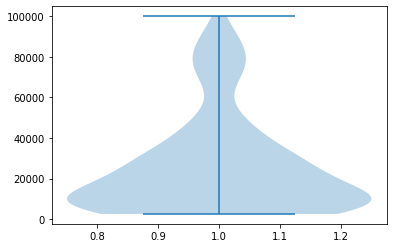

In [38]:
plt.violinplot(final_comps_rto[:,0])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f070d648410>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f070d6e26d0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f070d648510>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f070d648590>}

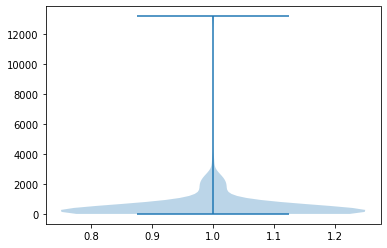

In [39]:
plt.violinplot(final_comps_rto[:,1])

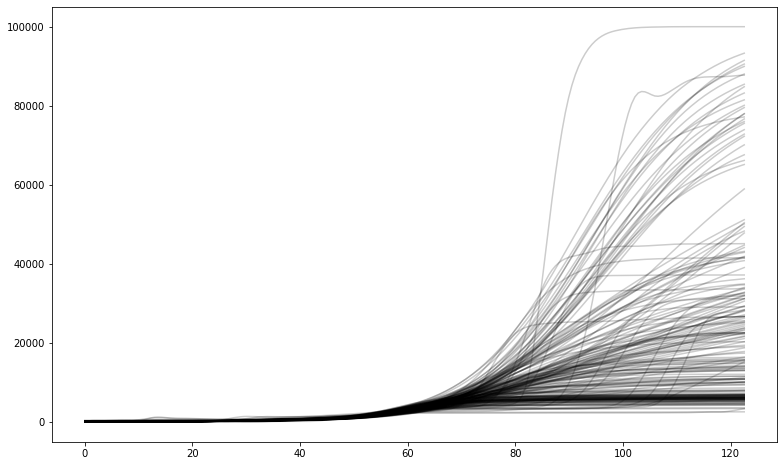

In [41]:
plt.figure(figsize=[13,8])
for sol in resample_rto_sols:
    x = getx(sol['x'])
    plt.plot(model.observation_times, x[-2], 'k', alpha=0.2)

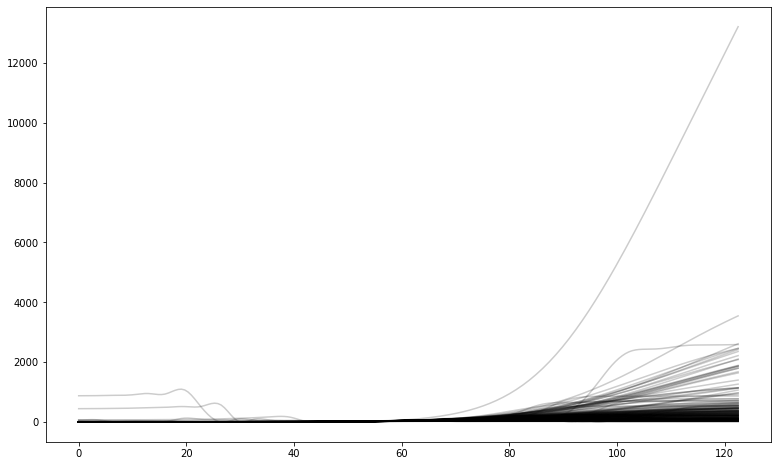

In [42]:
plt.figure(figsize=[13,8])
for sol in resample_rto_sols:
    x = getx(sol['x'])
    plt.plot(model.observation_times, x[-3], 'k', alpha=0.2)

In [66]:
deaths = sorted(final_comps_rto[:,1])
print(deaths[5], deaths[-6])

25.6876303795112 2461.957848529092


In [67]:
cases = sorted(final_comps_rto[:,0])
print(cases[5], cases[-6])

4347.514473116643 88025.07126903732


Text(0.5, 1.0, 'Distribution of final sizes')

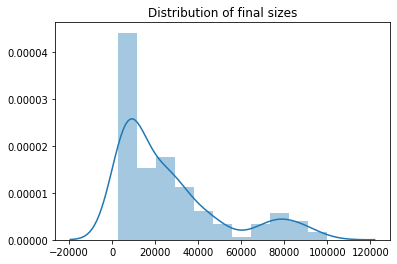

In [77]:
sns.distplot(final_comps_rto[:,0])
plt.title('Distribution of final sizes')

Text(0.5, 1.0, 'Distribution of final death count')

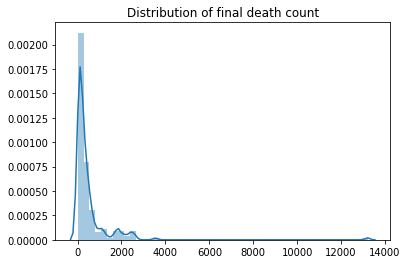

In [78]:
sns.distplot(final_comps_rto[:,1])
plt.title('Distribution of final death count')